In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self):

        super(Generator, self).__init__()

        self.model = nn.Sequential(                                                         # B 1 28 14
                                   
            torch.nn.Conv2d(1, 32, 3, stride = 1, padding = (3, 2)),                        # B 32 32 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(32, 32, 3, stride = 1, padding = 1),                            # B 32 32 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 32 16 8

            torch.nn.Conv2d(32, 64, 3, stride = 1, padding = 1),                            # B 64 16 8
            torch.nn.LeakyReLU(0.2, inplace = 0.2),
            torch.nn.Conv2d(64, 64, 3, stride = 1, padding = 1),                            # B 64 16 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 64 8 4
            
            torch.nn.Conv2d(64, 128, 3, stride = 1, padding = 1),                           # B 128 8 4   
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),                          # B 128 8 4
            torch.nn.LeakyReLU(0.2, inplace = True),               
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 128 8 4

            torch.nn.Conv2d(128, 256, 3, stride = 1, padding = (1, 3)),                     # B 256 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 4 4
            torch.nn.LeakyReLU(0.2, inplace = True),  

            torch.nn.Conv2d(256, 256, 3, stride = 1, padding = 1),                          # B 256 4 4
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 2 2
            torch.nn.LeakyReLU(0.2, inplace = True),           
        )    
        
        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128),                                                      # B 128
            torch.nn.LeakyReLU(),
        )


        self.sequential_transpose = nn.Sequential( # B 128 2 1
                                                  
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0),    # B 64 4 2    
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),             # B 64 4 2
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0),     # B 64 8 4
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),             # B 64 8 4
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2, padding = 0),     # B 32 16 8
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),              # B 32 16 8
            torch.nn.Dropout(0.2),
            torch.nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding = 0),     # B 16 32 16
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 0),              # B 16 30 14
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(16, 1, kernel_size = 3, stride = 1, padding = (0, 1)),          # B 1 28 14
            torch.nn.BatchNorm2d(num_features = 1),
            torch.nn.ReLU(),
        )

        self.lin = torch.nn.Linear(100, 128)

    def unsqueeze(self, input):
        half = torch.unsqueeze(input, 2)
        return torch.unsqueeze(half, 2)
    
    def forward(self, left, noise):
        out = self.model(left)
        out = self.decider(out.flatten(1))
        out = self.unsqueeze(out)
        noise = self.lin(noise.flatten(1))
        noise =self.unsqueeze(noise)
        gen_out = torch.cat([out, noise], 2)
        picture = self.sequential_transpose(gen_out)
        return picture.clamp(0, 255)



In [3]:
class Discriminator(nn.Module):
    def __init__(self):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(                                                         # B 1 28 28
                                   
            torch.nn.Conv2d(1, 32, 3, stride = 1, padding = 3),                             # B 32 32 32
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 32 16 16

            torch.nn.Conv2d(32, 64, 3, stride = 1, padding = 1),                            # B 64 16 16
            torch.nn.LeakyReLU(0.2, inplace = 0.2),
            torch.nn.Conv2d(64, 64, 3, stride = 1, padding = 1),                            # B 64 16 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 64 8 8
            
            torch.nn.Conv2d(64, 128, 3, stride = 1, padding = 1),                           # B 128 16 16  
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),                          # B 128 16 16
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 128 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),

            torch.nn.Conv2d(128, 256, 3, stride = 1, padding = 1),                          # B 256 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(256, 256, 3, stride = 1, padding = 1),                          # B 256 8 8
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 4 4
            torch.nn.LeakyReLU(0.2, inplace = True),  

            torch.nn.MaxPool2d(2, stride = 2, padding = 0),                                 # B 256 2 2
            torch.nn.LeakyReLU(0.2, inplace = True),           
        )   

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128),                                                      # B 128
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 1),                                                      # B 1
            torch.nn.Sigmoid()
        )

    def forward(self, pictures):
        if len(pictures.shape) == 3:
            pictures = pictures.unsqueeze(1)
        features = self.model(pictures)
        out = self.decider(features.flatten(1))
        out = out.squeeze()
        return out




In [4]:
batch_size = 256

In [5]:
array = torch.zeros((batch_size, 1, 28, 14))
noise_example = torch.zeros((batch_size, 100, 1, 1))

In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [7]:
x = mnist.data
y = mnist.target
print(type(y))
print(x.shape)

<class 'numpy.ndarray'>
(70000, 784)


In [8]:
x = x.reshape((70000, 28, 28))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 17)
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=40)
print('%d train, %d validation, %d test data' % (len(x_train), len(x_val), len(x_test)))

39200 train, 9800 validation, 21000 test data


In [11]:
def concat_left_and_right(correct_left, gen_out):
    pictures = torch.cat([correct_left, gen_out], 2)
    return pictures

In [12]:
def generator_trainer(generator, discriminator, b_images, gen_optimizer, criterion, device):    
    
    gen_optimizer.zero_grad()
    B = b_images.shape[0]

    noise = torch.randn(B, 100, 1, 1).to(device, non_blocking=True)
    images = torch.tensor(b_images).to(device, non_blocking=True)

    left = images[:, :, :, :14]                                       # B 28  14
    right = images[:, :, :, 14:]                                      # B 28  14

    fake_right = generator(left, noise)                                 # B 28  14
    validity = discriminator(torch.cat((left, fake_right), dim = 3))     # B

    g_loss = criterion(validity, torch.ones(B).to(device))
    g_loss.backward()
    
    gen_optimizer.step()
    return g_loss

In [13]:
def discriminator_trainer(criterion, discriminator, generator, right_pic, device):    
    
    length = right_pic.shape[0]
    real_images = (right_pic[:length // 2]).to(device)
    fake_images = (right_pic[length // 2:]).to(device)

    noise = torch.randn(fake_images.shape[0], 100, 1, 1, device=torch.device('cuda:0'))
    left = fake_images[:, :, :, :14]
    with torch.no_grad():
        fake_right = generator(left, noise).detach()
    generated_images = torch.cat((left, fake_right), dim=3).to(device)                     # B/2   28  28

    discriminator_inputs = torch.cat((real_images, generated_images), dim=0)   # B     28  28
    ones = torch.ones(real_images.shape[0], device=torch.device('cuda:0'))
    zeros = torch.zeros(generated_images.shape[0], device=torch.device('cuda:0'))
    expect = torch.cat([ones, zeros], dim=0)   # B

    dis_out = discriminator(discriminator_inputs)
    d_loss = criterion(dis_out, expect).to(device) 
    d_loss.backward()

    dis_optimizer.step()
    dis_optimizer.zero_grad()

    return (d_loss)


In [14]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [15]:
epochs = 150

In [16]:
train_loss = np.zeros((epochs,))

In [17]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [18]:
gen_optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, generator.parameters()),
    lr = 0.00001
)

In [19]:
dis_optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, discriminator.parameters()),
    lr = 0.000001
)

In [20]:
from time import time

In [21]:
print(x_train.shape)

(39200, 28, 28)


In [22]:
x_train = np.expand_dims(x_train, axis=1)
print(x_train.shape)

(39200, 1, 28, 28)


In [23]:
x_train = torch.Tensor(x_train)

In [24]:
x_val = np.expand_dims(x_val, axis=1)
x_val.shape

(9800, 1, 28, 28)

In [25]:
x_val = torch.Tensor(x_val)

In [26]:
import matplotlib.pyplot as plt

def draw(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 28)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [27]:
def draw2(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 14)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [28]:
def display(generator, x_val, columns, rows):

    inds = np.arange(len(x_val))
    np.random.shuffle(inds)

    batch_inds = inds[:min(len(inds), columns * rows)]

    with torch.no_grad():
        generator.eval()

        batch = x_val[batch_inds]
        z = torch.randn(columns * rows, 100, 1, 1, device=torch.device('cuda:0'))
        batch_images = batch.to(device)
        left = batch_images[:, :, :, :14]
        right = generator(left, z).detach()
        generated_images = torch.cat((left, right), dim=3).cpu().numpy()      # row*col   28  28
        
        images_to_show = np.zeros((rows * columns, 2, 1, 28, 28))
        images_to_show[:,0] = batch
        images_to_show[:,1] = generated_images
        images_to_show = images_to_show.reshape(rows * columns * 2, 28, 28)

        texts = np.zeros((rows * columns, 2), dtype=object)
        texts[:,0] = np.array(['real' for _ in range(rows * columns)])
        texts[:,1] = np.array(['generated' for _ in range(rows * columns)])
        texts = texts.reshape(rows * columns * 2)

        #draw2(right.cpu().numpy(), texts, columns , rows)
        draw(images_to_show, texts, columns * 2, rows)

In [29]:
criterion = torch.nn.BCELoss().to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Discriminator Loss: 8.5631e+01 and generator loss is: 1.6183e+01
Epoch 0 ended in 5.89 secs.


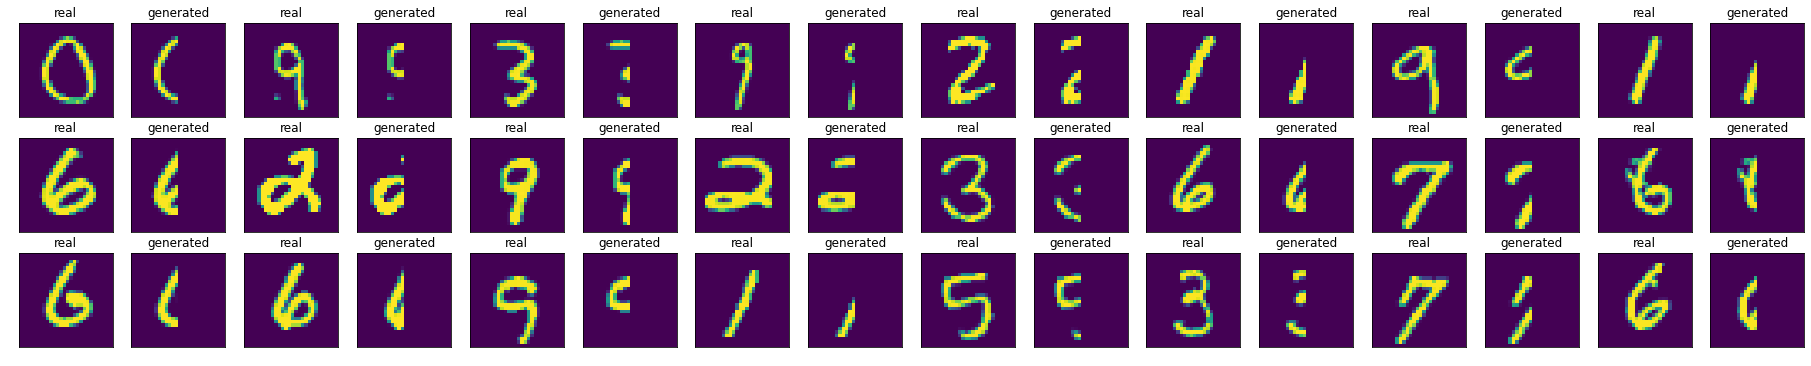

Discriminator Loss: 7.9825e+01 and generator loss is: 1.4914e+01
Epoch 1 ended in 5.84 secs.


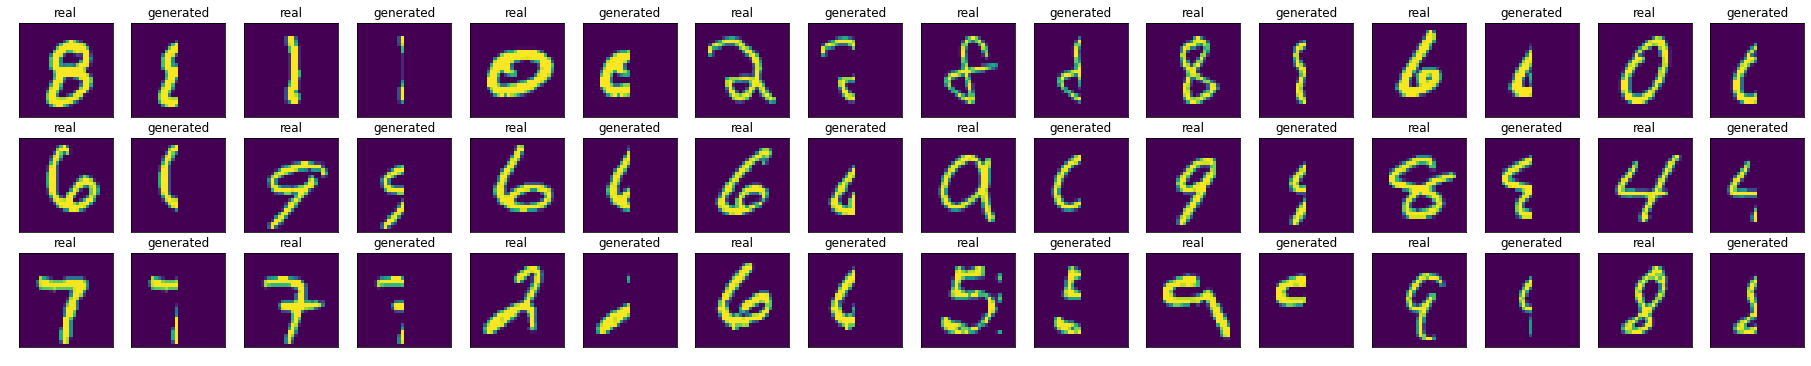

Discriminator Loss: 7.2864e+01 and generator loss is: 1.5292e+01
Epoch 2 ended in 5.87 secs.


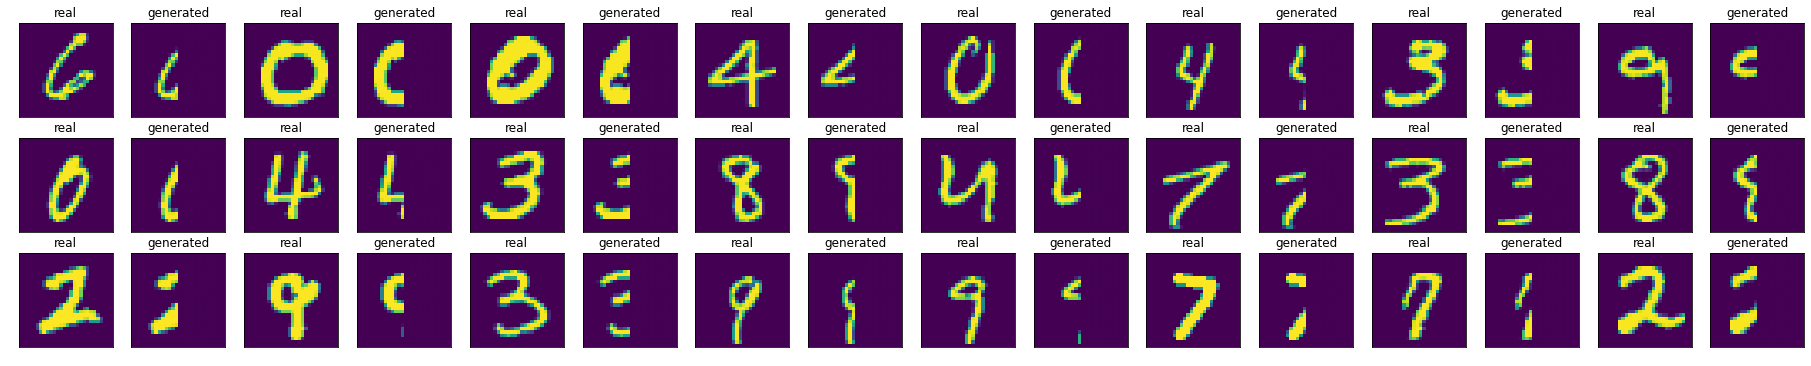

Discriminator Loss: 6.4220e+01 and generator loss is: 1.6890e+01
Epoch 3 ended in 5.91 secs.


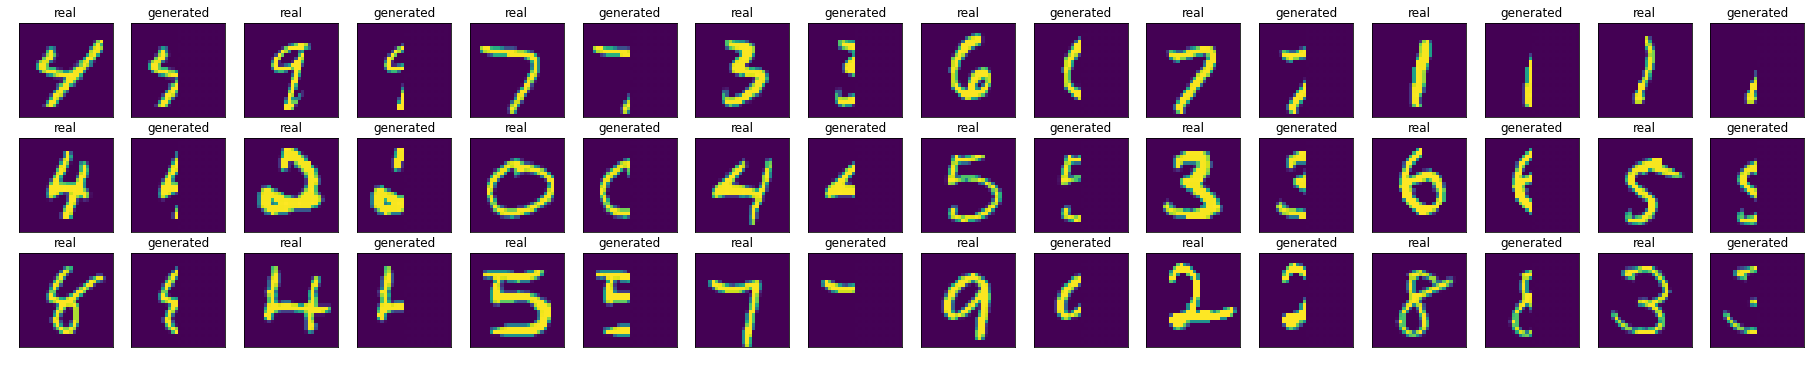

Discriminator Loss: 5.4799e+01 and generator loss is: 1.9253e+01
Epoch 4 ended in 5.95 secs.


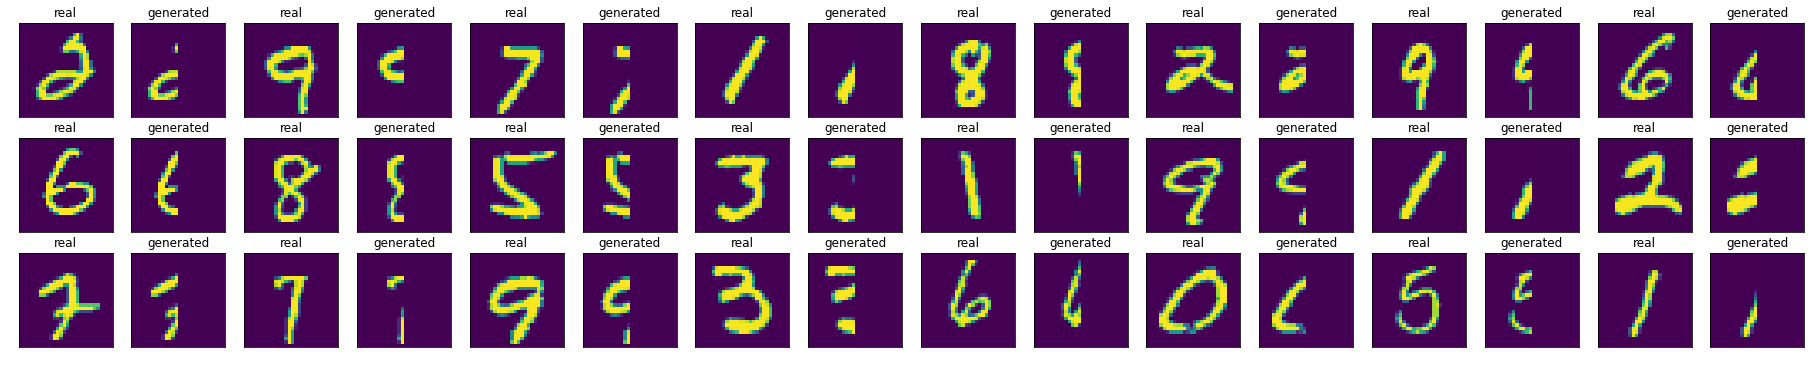

Discriminator Loss: 4.6404e+01 and generator loss is: 2.1679e+01
Epoch 5 ended in 5.96 secs.


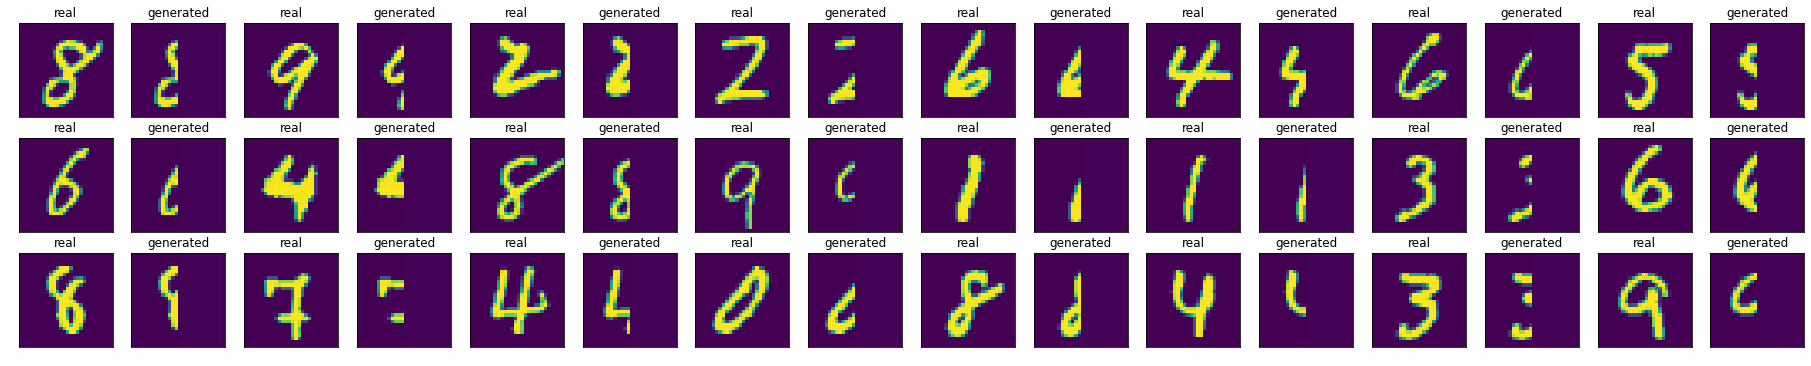

Discriminator Loss: 4.0106e+01 and generator loss is: 2.4181e+01
Epoch 6 ended in 6.01 secs.


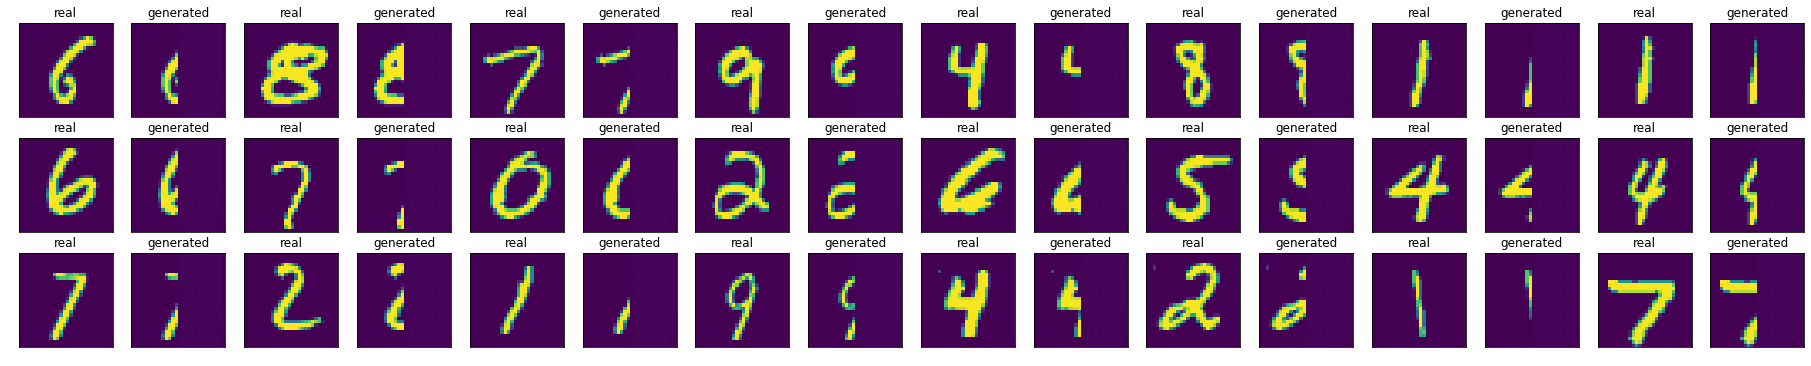

Discriminator Loss: 3.6216e+01 and generator loss is: 2.5746e+01
Epoch 7 ended in 6.03 secs.


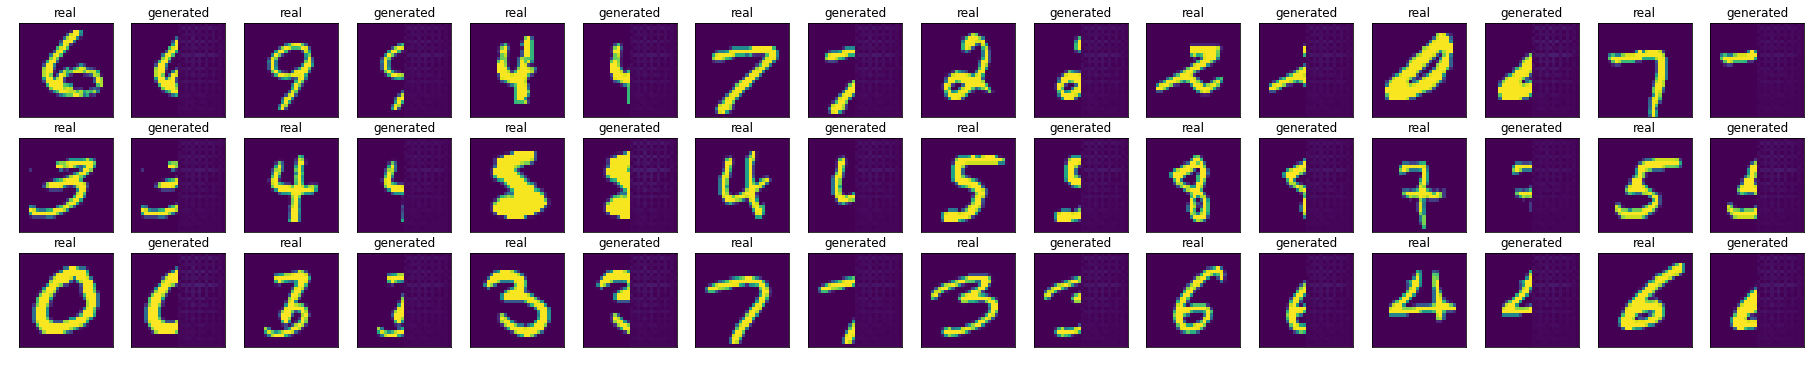

Discriminator Loss: 4.5906e+01 and generator loss is: 2.2022e+01
Epoch 8 ended in 6.05 secs.


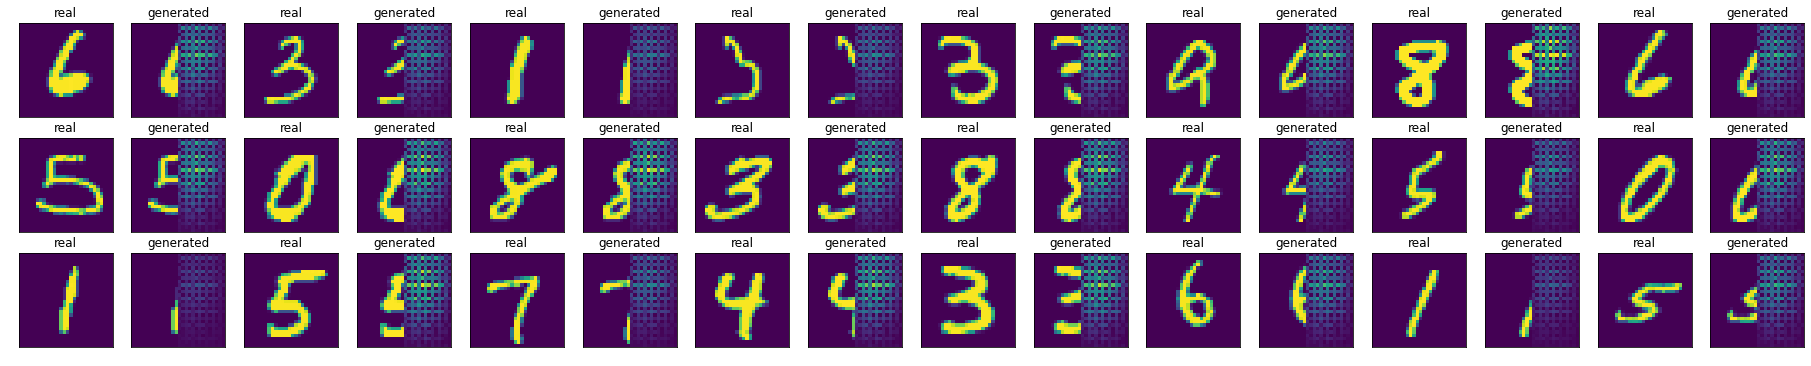

Discriminator Loss: 9.1050e+01 and generator loss is: 1.5429e+01
Epoch 9 ended in 6.07 secs.


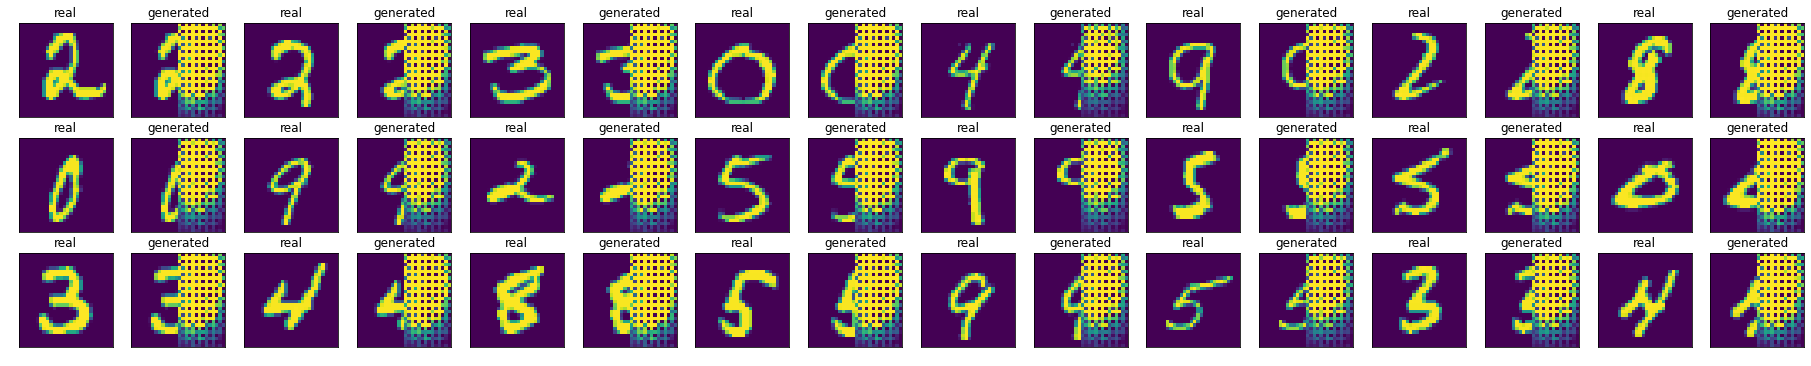

Discriminator Loss: 5.8812e+01 and generator loss is: 2.3319e+01
Epoch 10 ended in 6.10 secs.


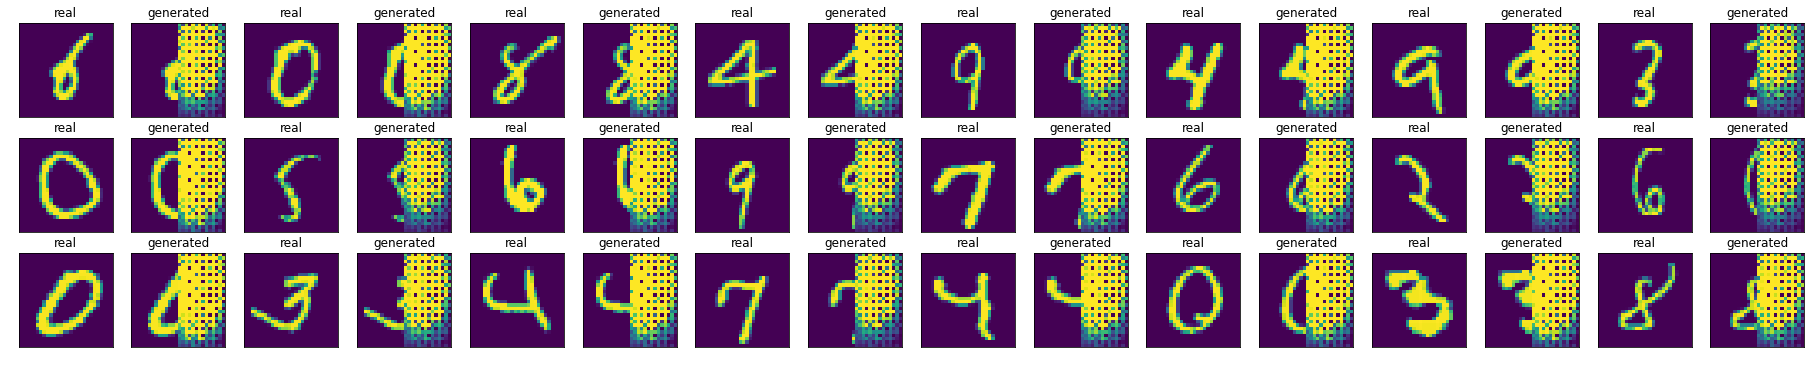

Discriminator Loss: 4.6799e+01 and generator loss is: 2.5858e+01
Epoch 11 ended in 6.08 secs.


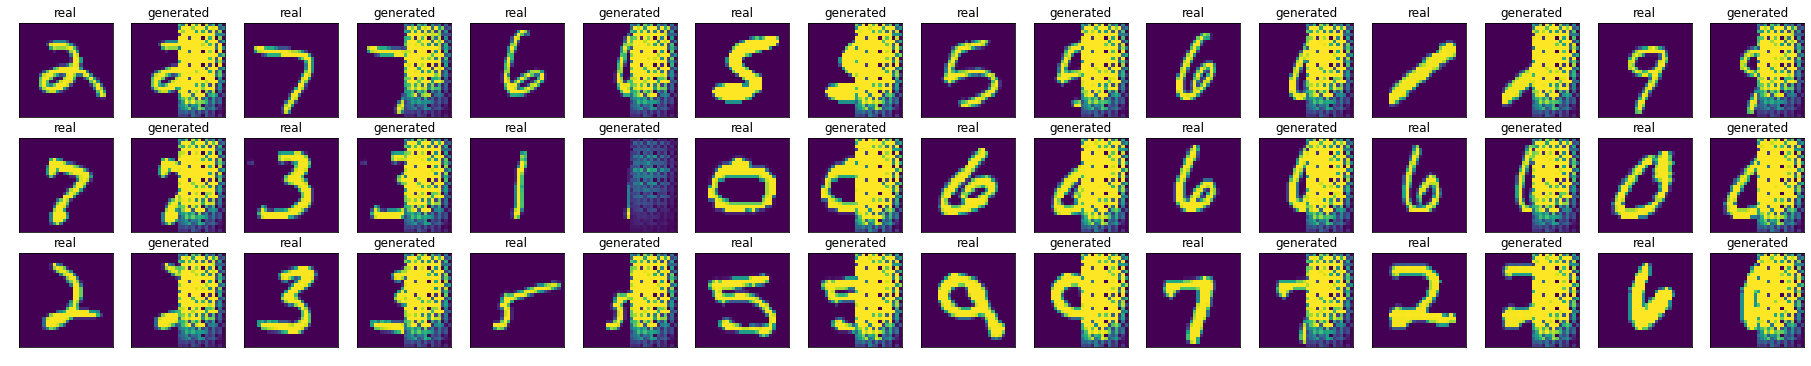

Discriminator Loss: 4.4371e+01 and generator loss is: 2.5477e+01
Epoch 12 ended in 6.11 secs.


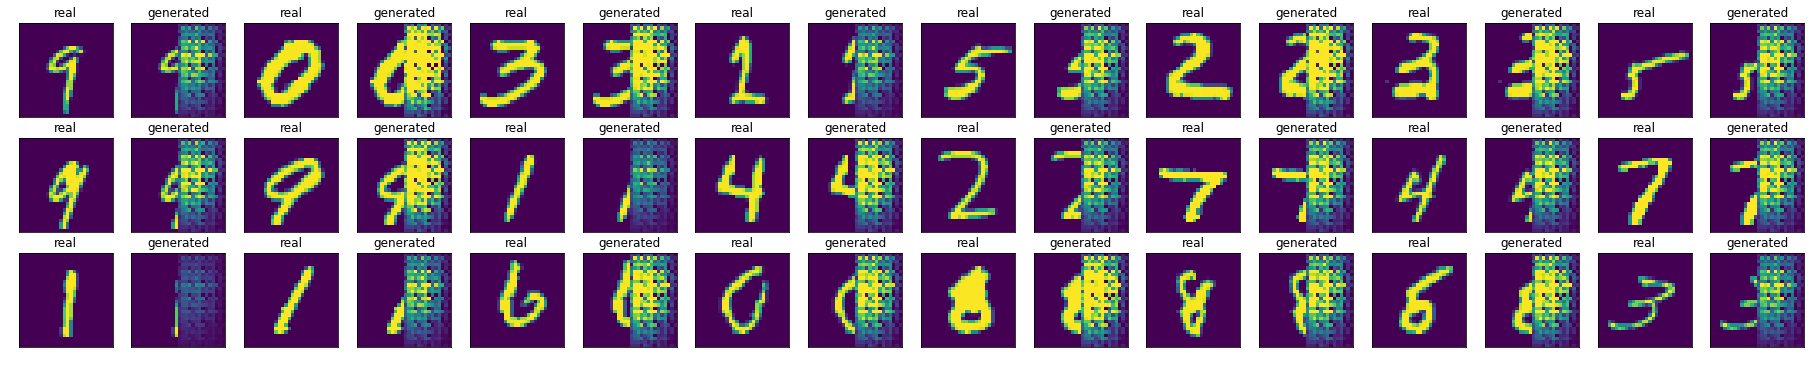

Discriminator Loss: 5.6165e+01 and generator loss is: 2.0186e+01
Epoch 13 ended in 6.14 secs.


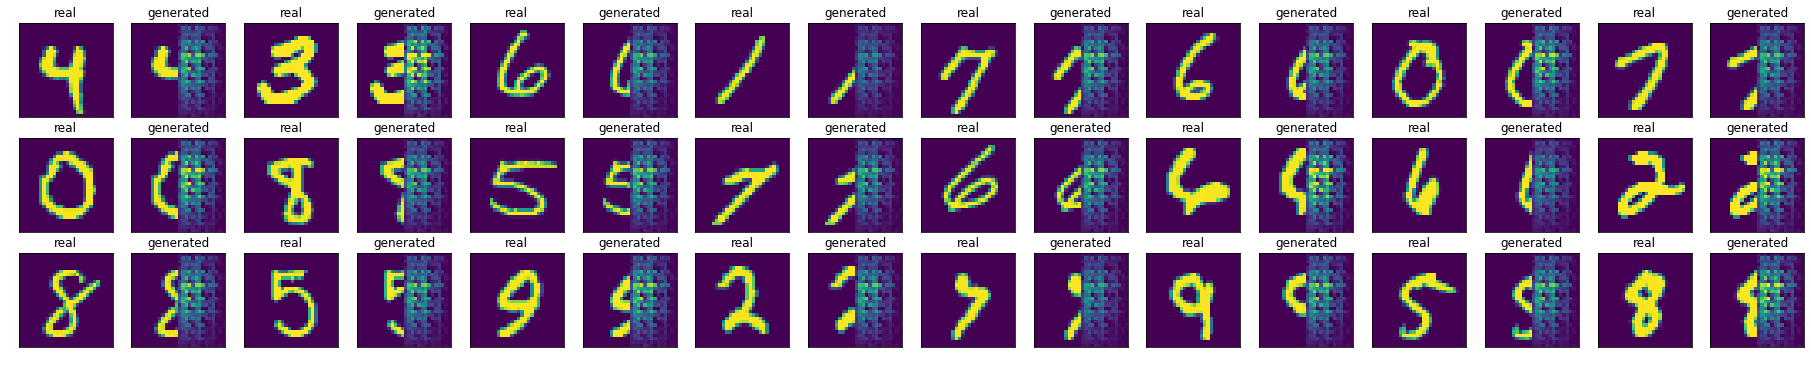

Discriminator Loss: 6.1835e+01 and generator loss is: 1.8640e+01
Epoch 14 ended in 6.13 secs.


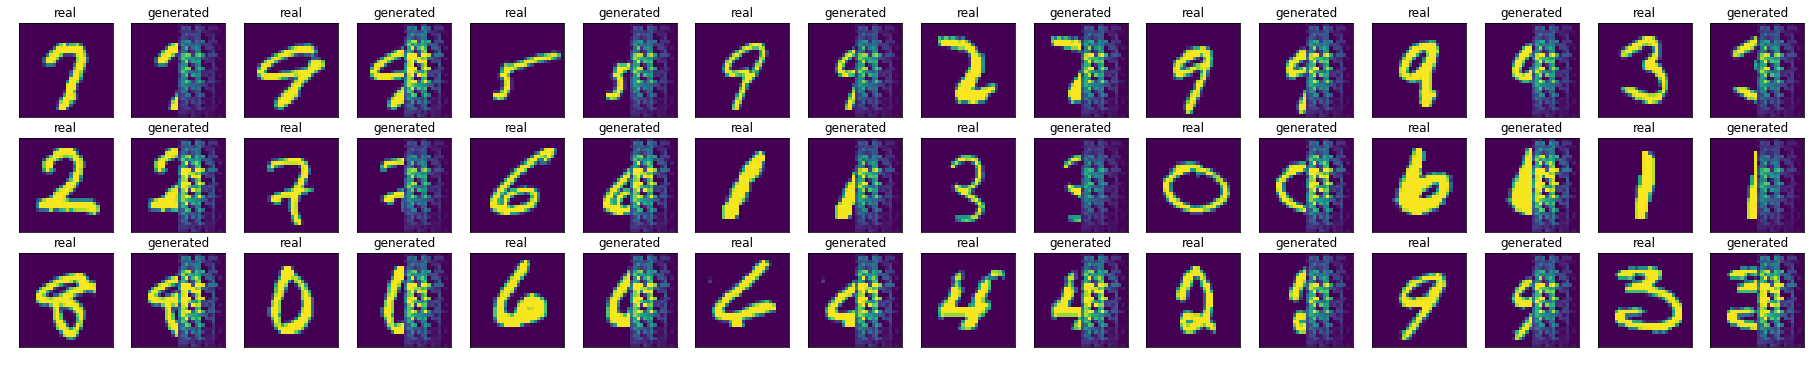

Discriminator Loss: 6.7002e+01 and generator loss is: 1.8316e+01
Epoch 15 ended in 6.12 secs.


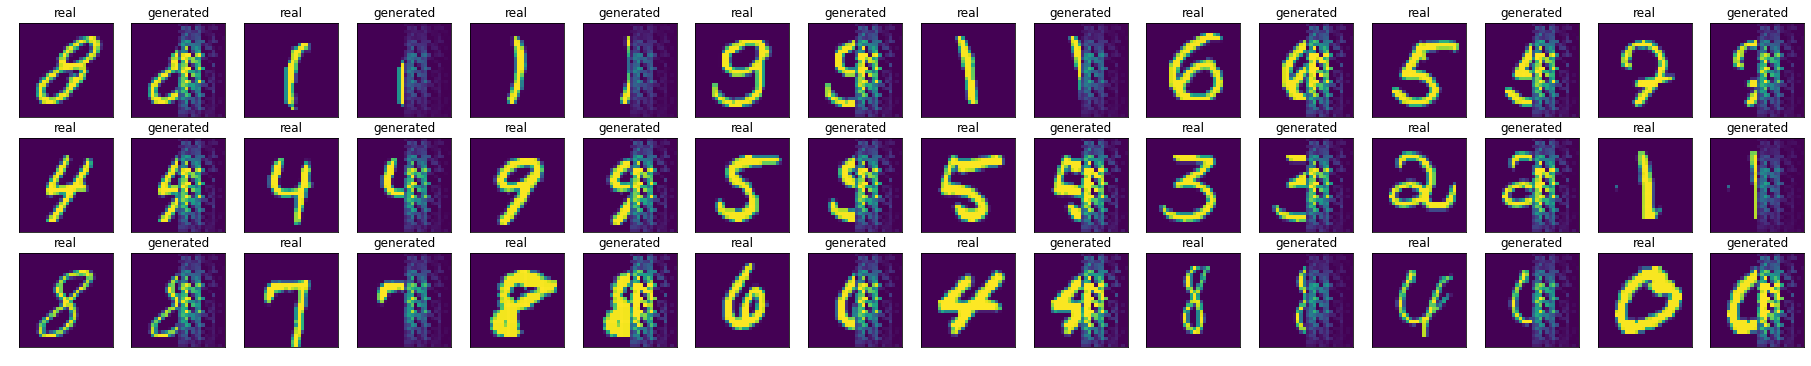

Discriminator Loss: 7.1938e+01 and generator loss is: 1.7512e+01
Epoch 16 ended in 6.11 secs.


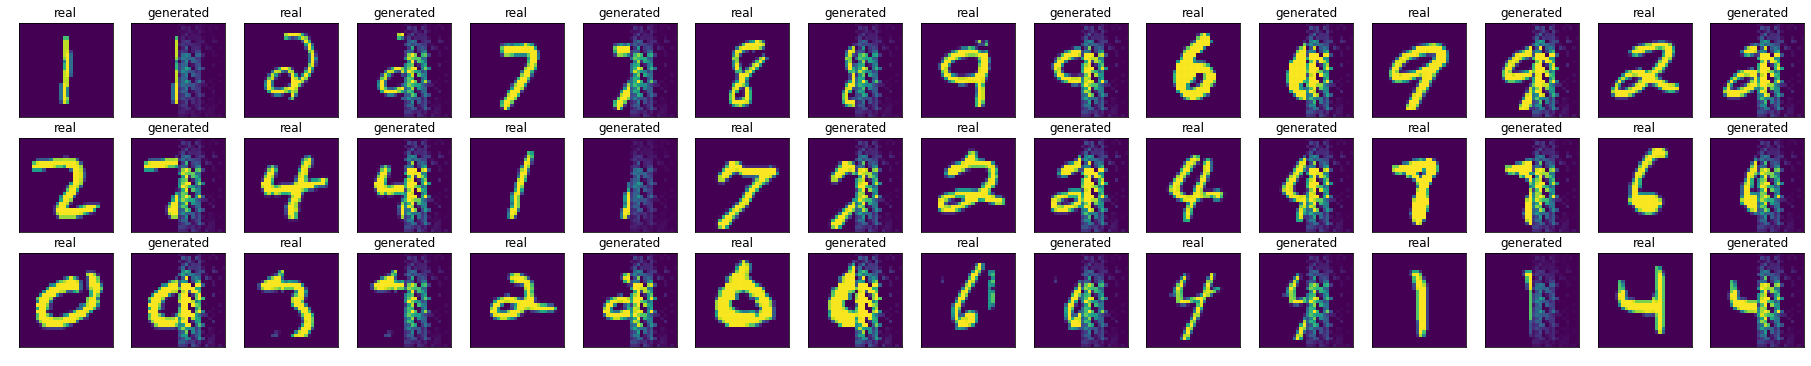

Discriminator Loss: 7.4301e+01 and generator loss is: 1.7319e+01
Epoch 17 ended in 6.11 secs.


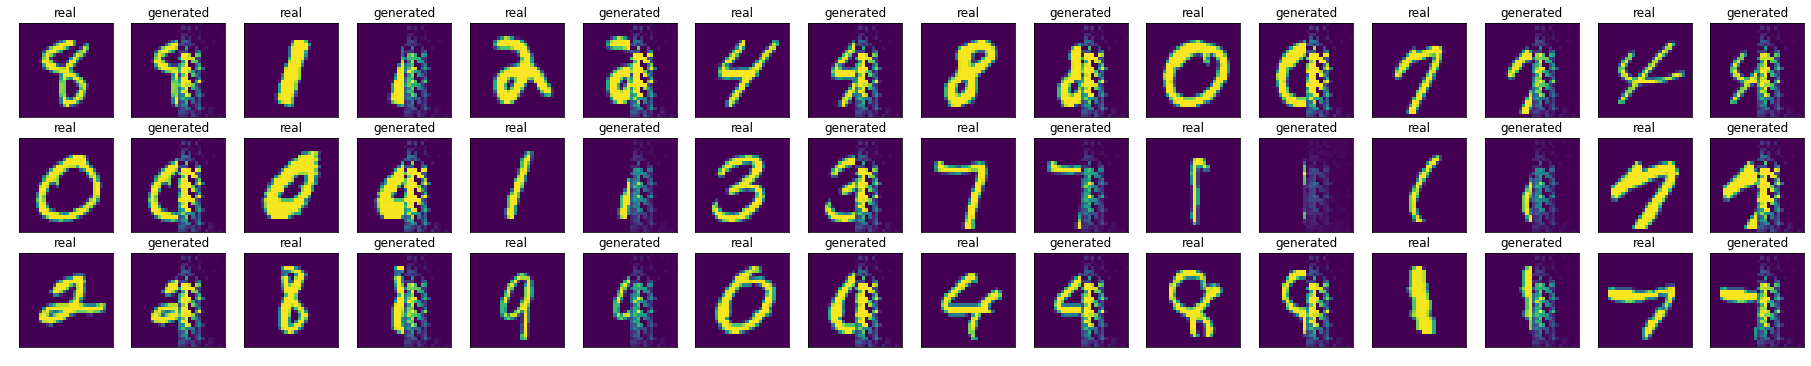

Discriminator Loss: 7.7376e+01 and generator loss is: 1.6366e+01
Epoch 18 ended in 6.10 secs.


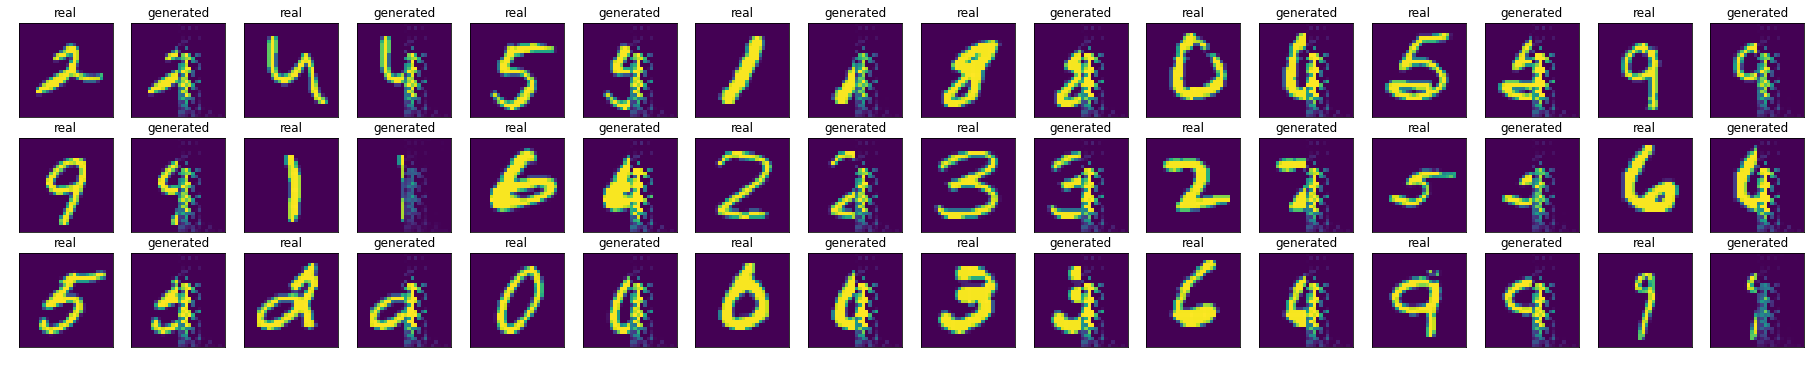

Discriminator Loss: 8.1773e+01 and generator loss is: 1.5771e+01
Epoch 19 ended in 6.09 secs.


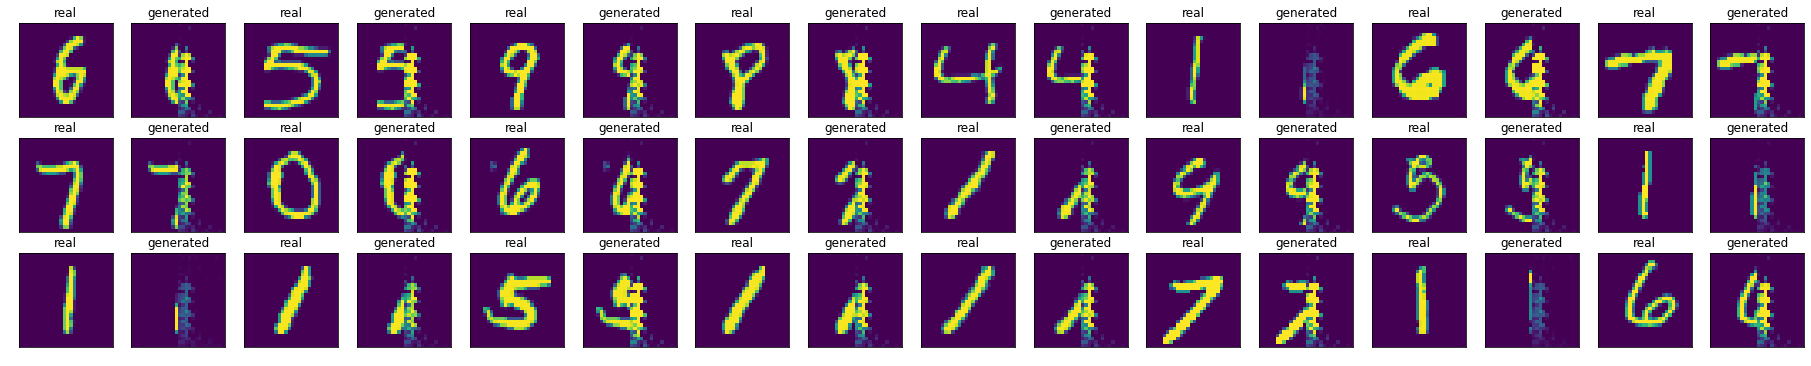

Discriminator Loss: 7.4757e+01 and generator loss is: 1.7697e+01
Epoch 20 ended in 6.10 secs.


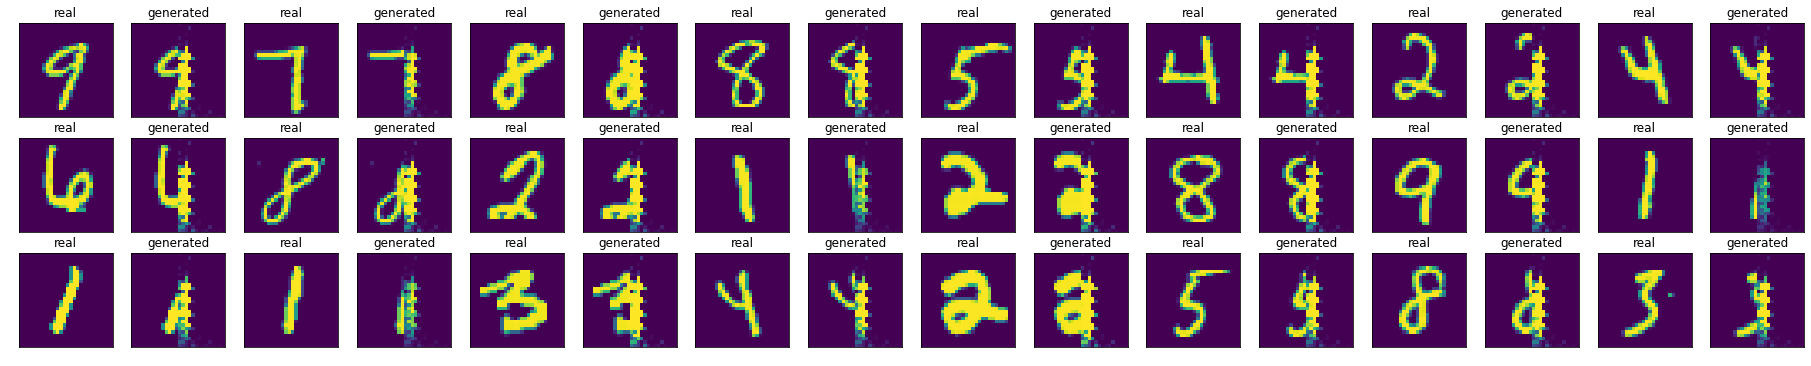

Discriminator Loss: 6.7103e+01 and generator loss is: 1.9246e+01
Epoch 21 ended in 6.09 secs.


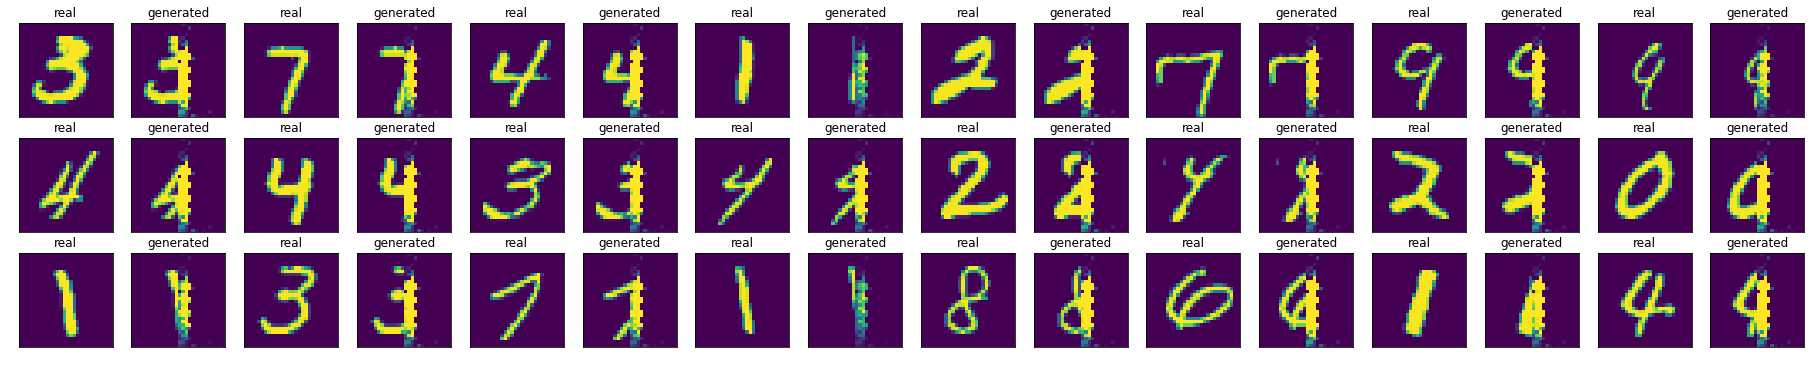

Discriminator Loss: 6.0413e+01 and generator loss is: 2.1042e+01
Epoch 22 ended in 6.12 secs.


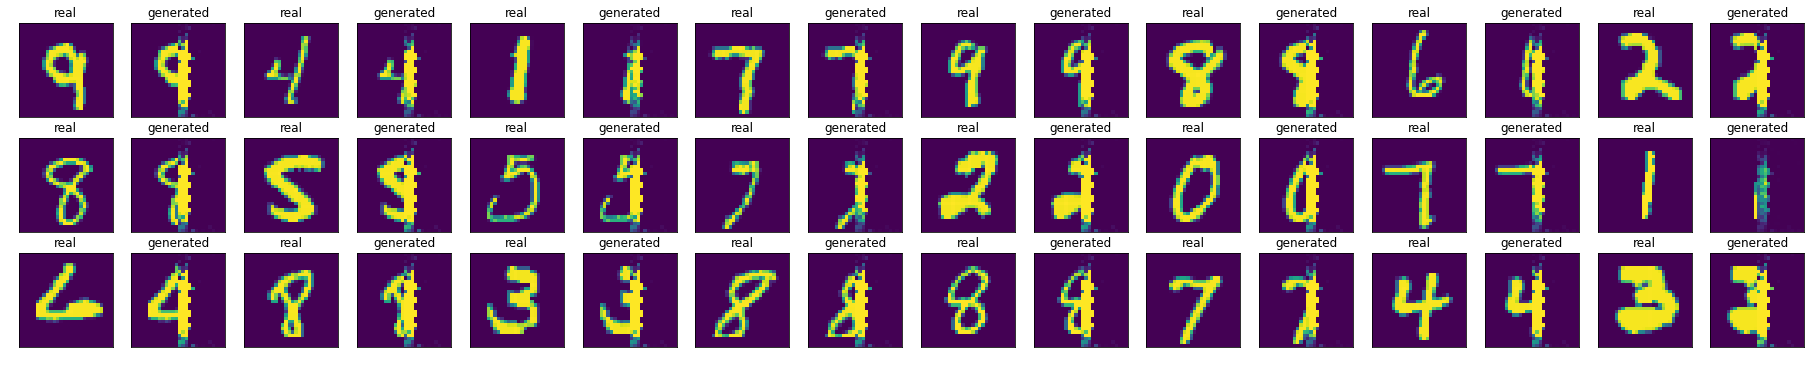

Discriminator Loss: 5.5745e+01 and generator loss is: 2.2177e+01
Epoch 23 ended in 6.11 secs.


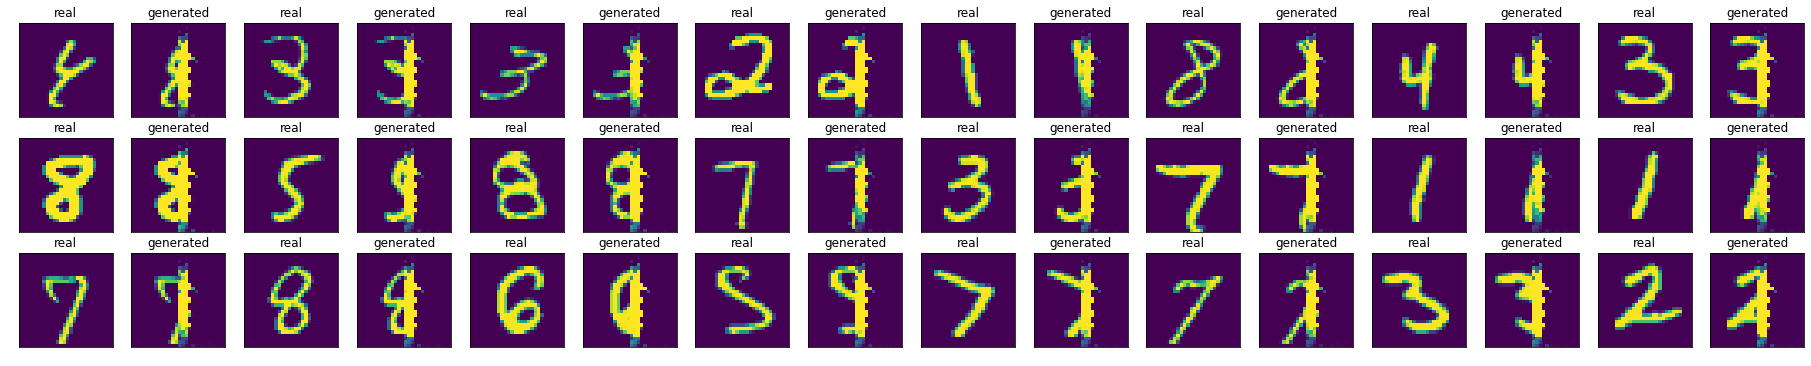

Discriminator Loss: 5.3030e+01 and generator loss is: 2.2968e+01
Epoch 24 ended in 6.11 secs.


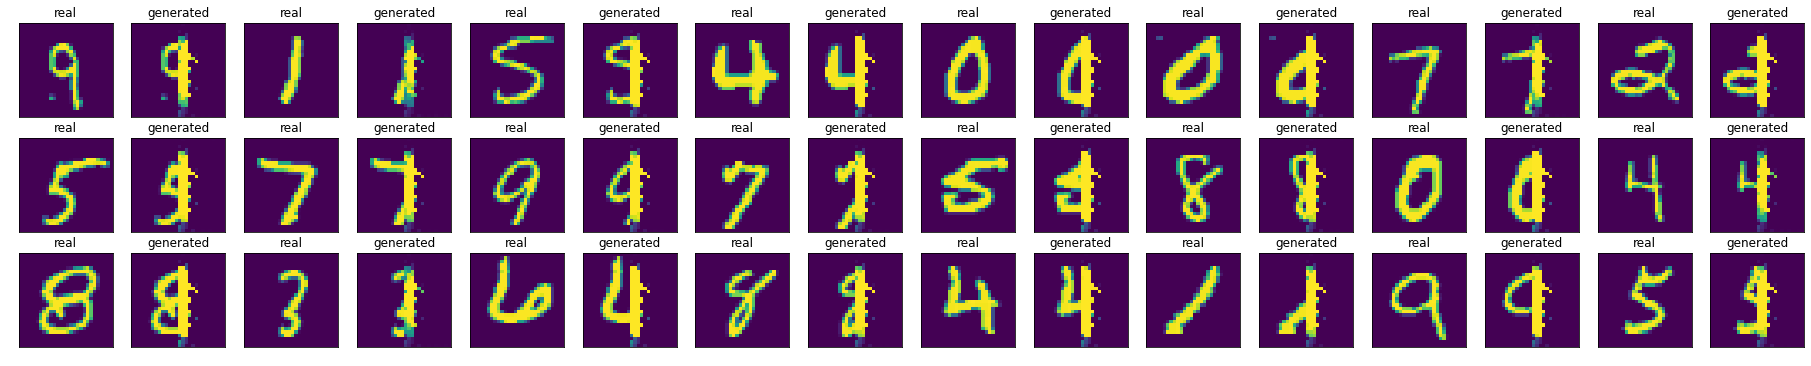

Discriminator Loss: 5.1285e+01 and generator loss is: 2.3558e+01
Epoch 25 ended in 6.11 secs.


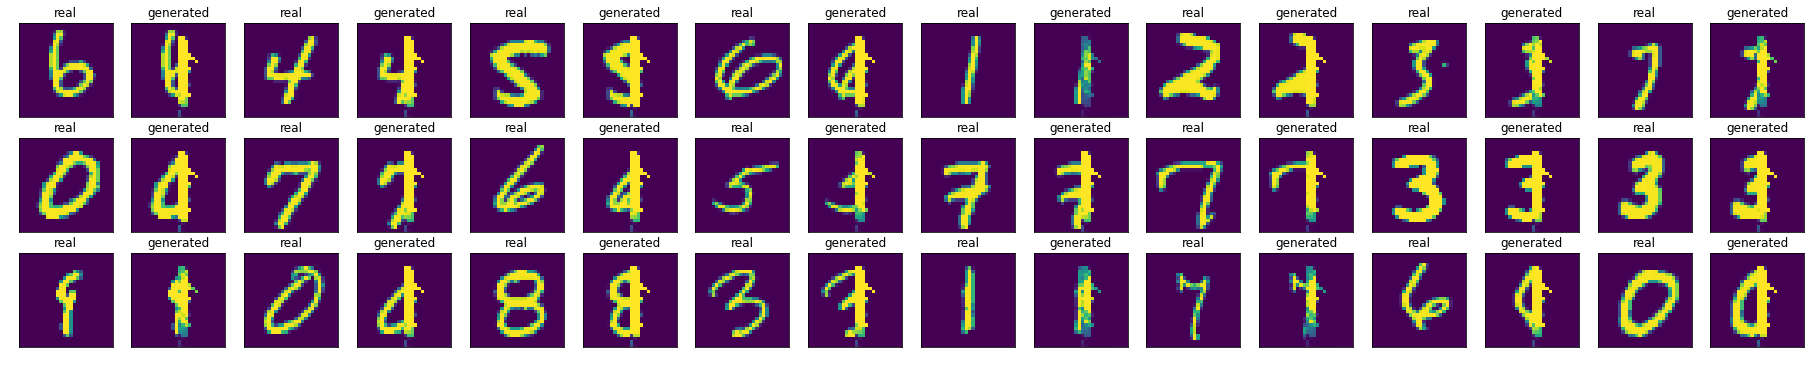

Discriminator Loss: 5.0555e+01 and generator loss is: 2.3586e+01
Epoch 26 ended in 6.11 secs.


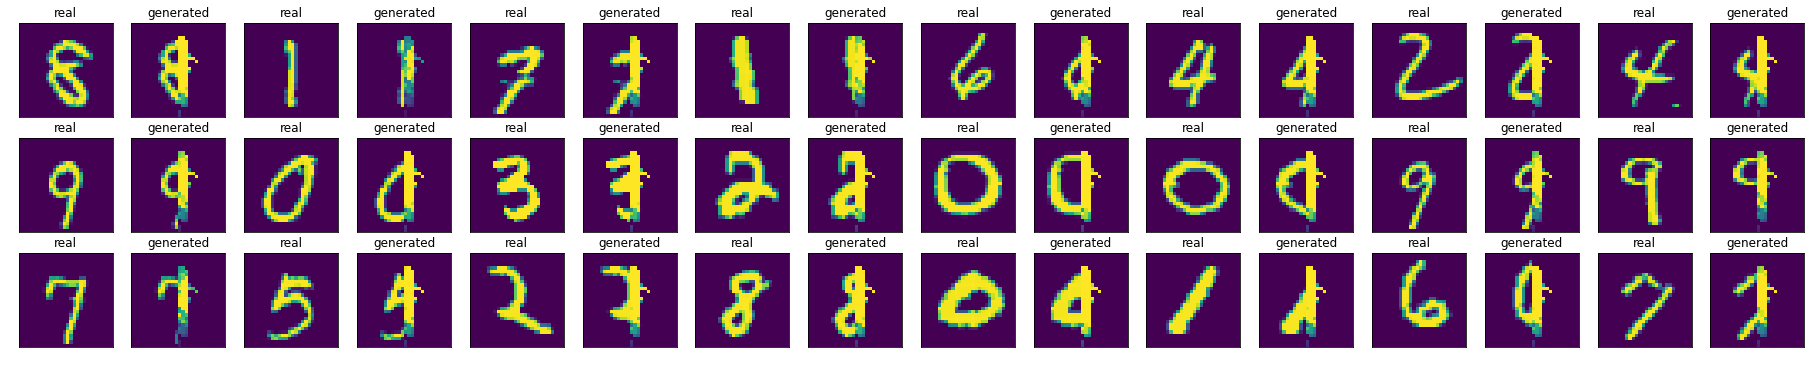

Discriminator Loss: 5.3645e+01 and generator loss is: 2.2264e+01
Epoch 27 ended in 6.10 secs.


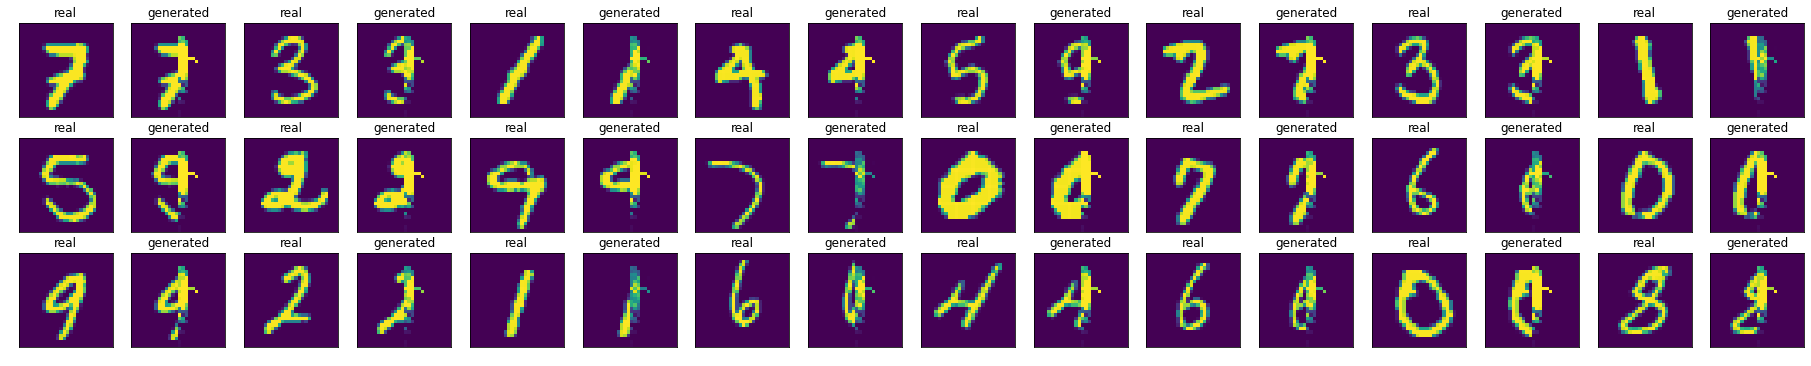

Discriminator Loss: 5.7542e+01 and generator loss is: 2.0814e+01
Epoch 28 ended in 6.10 secs.


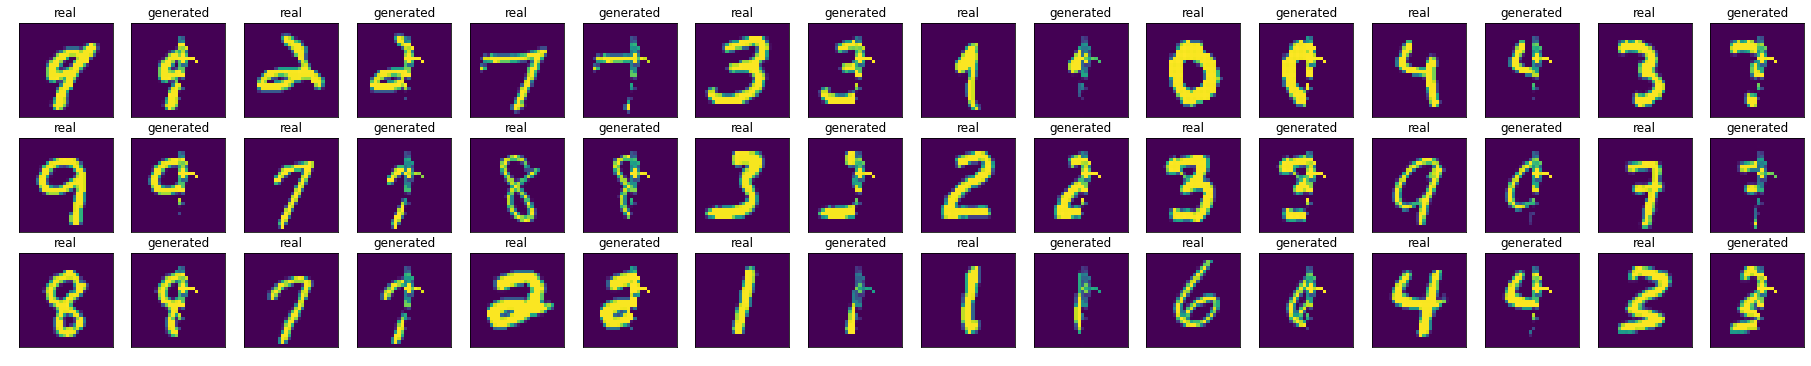

Discriminator Loss: 5.4583e+01 and generator loss is: 2.1287e+01
Epoch 29 ended in 6.10 secs.


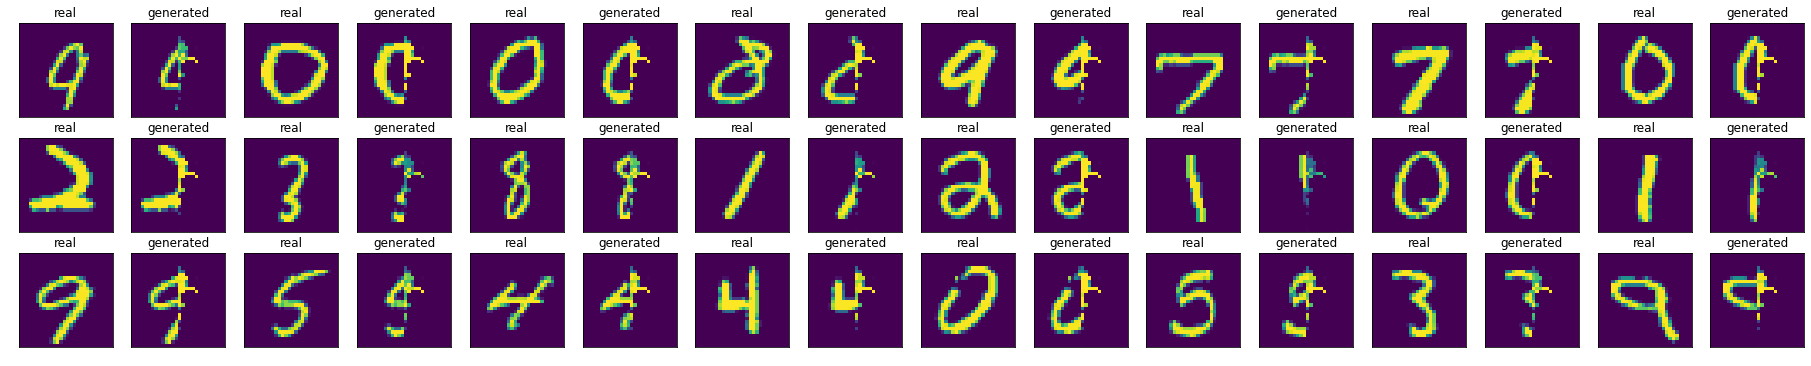

Discriminator Loss: 5.0689e+01 and generator loss is: 2.2891e+01
Epoch 30 ended in 6.10 secs.


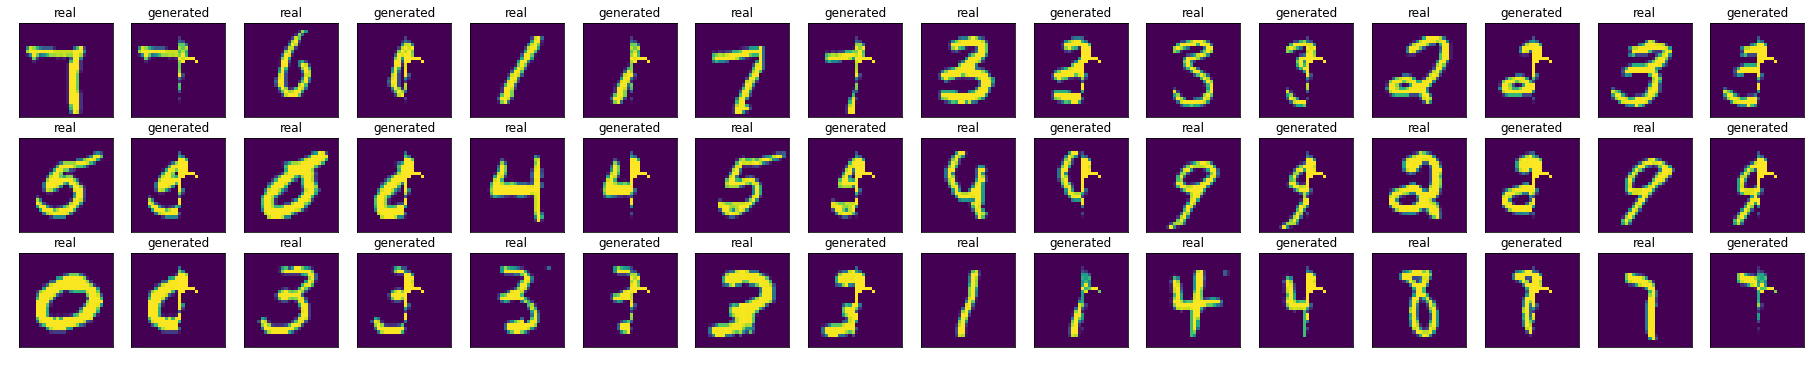

Discriminator Loss: 4.7450e+01 and generator loss is: 2.4138e+01
Epoch 31 ended in 6.10 secs.


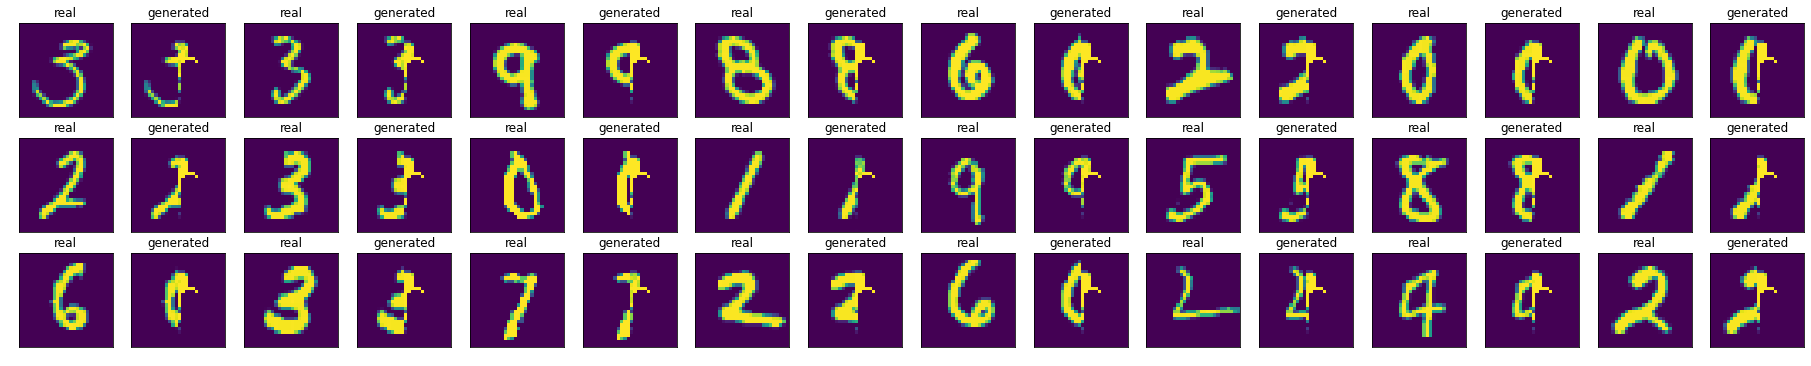

Discriminator Loss: 4.4127e+01 and generator loss is: 2.4926e+01
Epoch 32 ended in 6.11 secs.


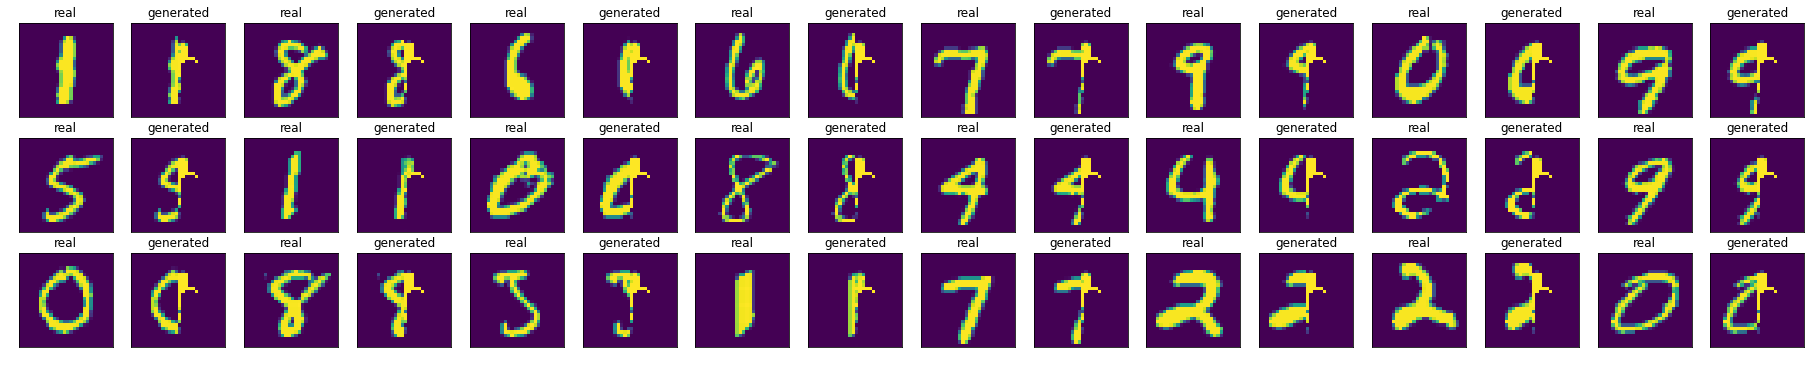

Discriminator Loss: 4.1901e+01 and generator loss is: 2.6014e+01
Epoch 33 ended in 6.10 secs.


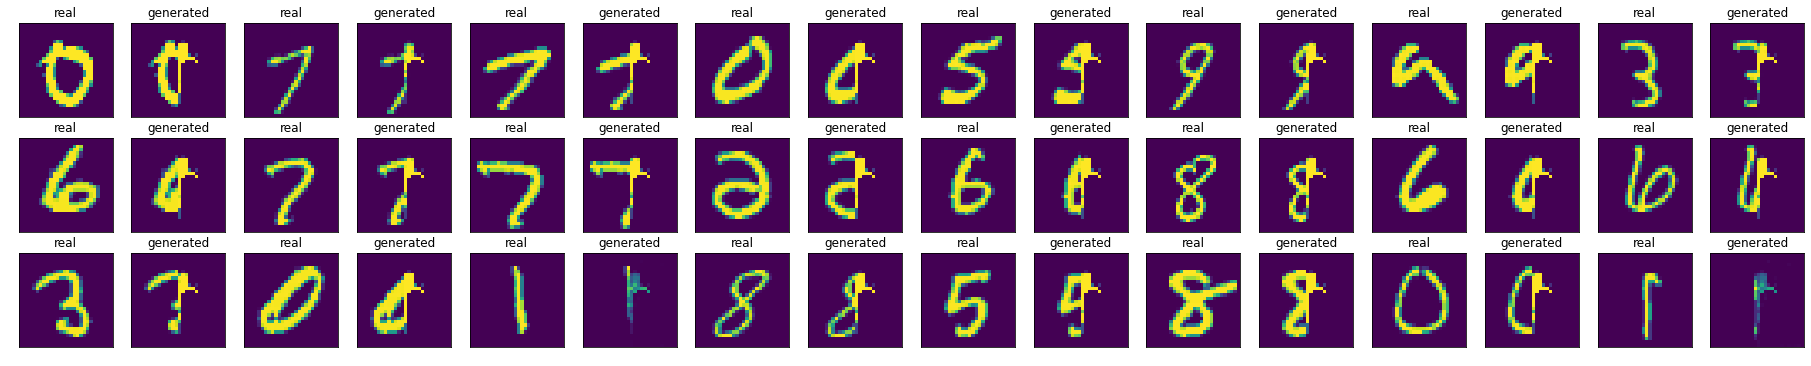

Discriminator Loss: 4.3174e+01 and generator loss is: 2.5480e+01
Epoch 34 ended in 6.10 secs.


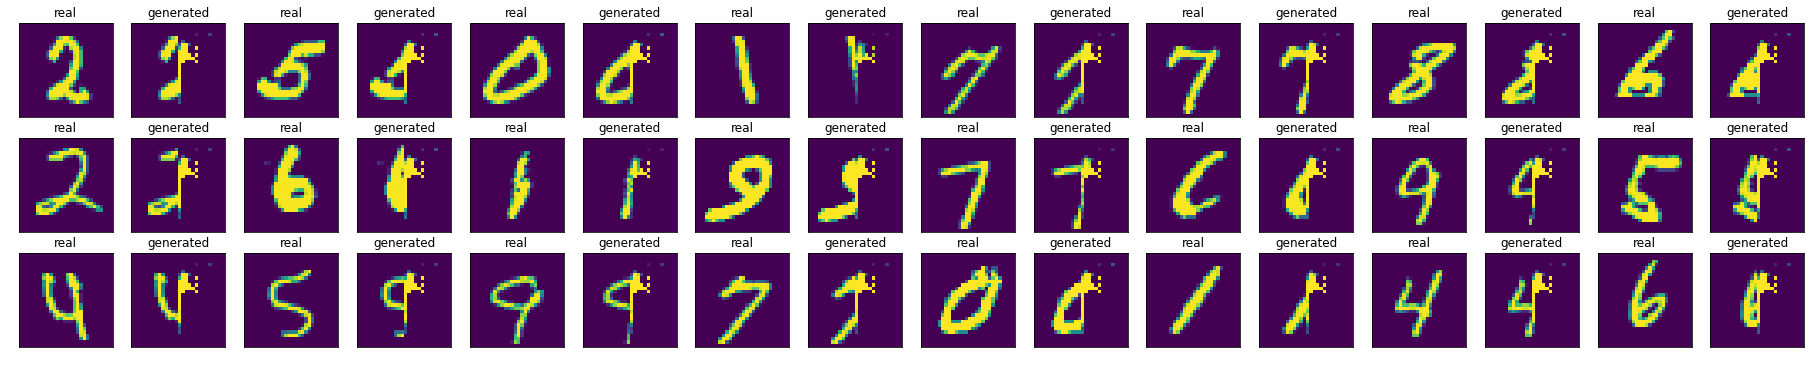

Discriminator Loss: 4.4274e+01 and generator loss is: 2.5087e+01
Epoch 35 ended in 6.10 secs.


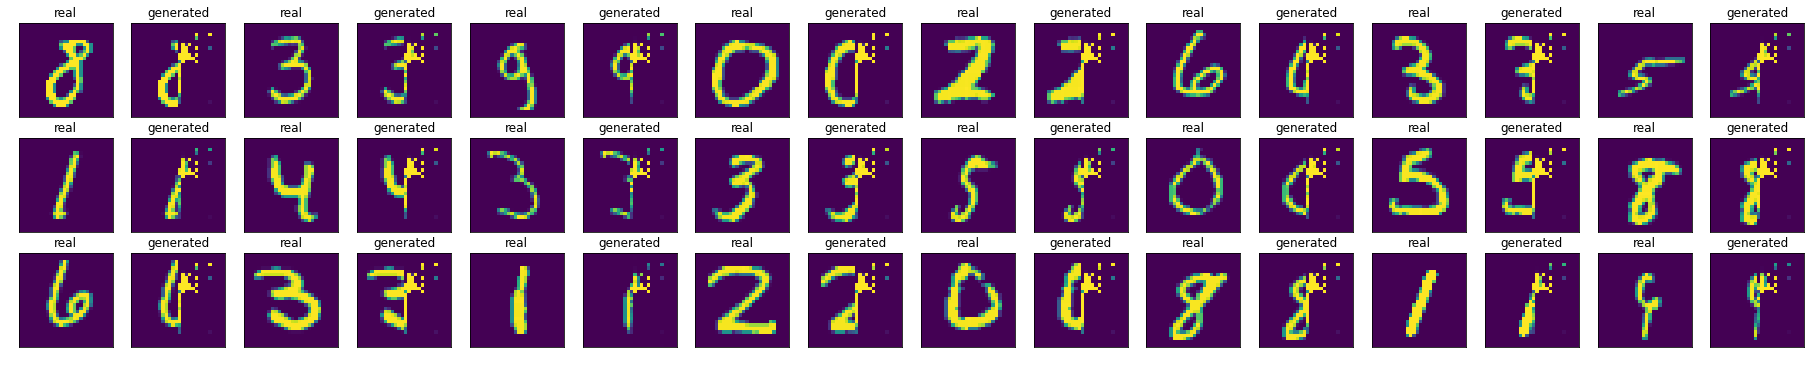

Discriminator Loss: 4.4372e+01 and generator loss is: 2.5394e+01
Epoch 36 ended in 6.09 secs.


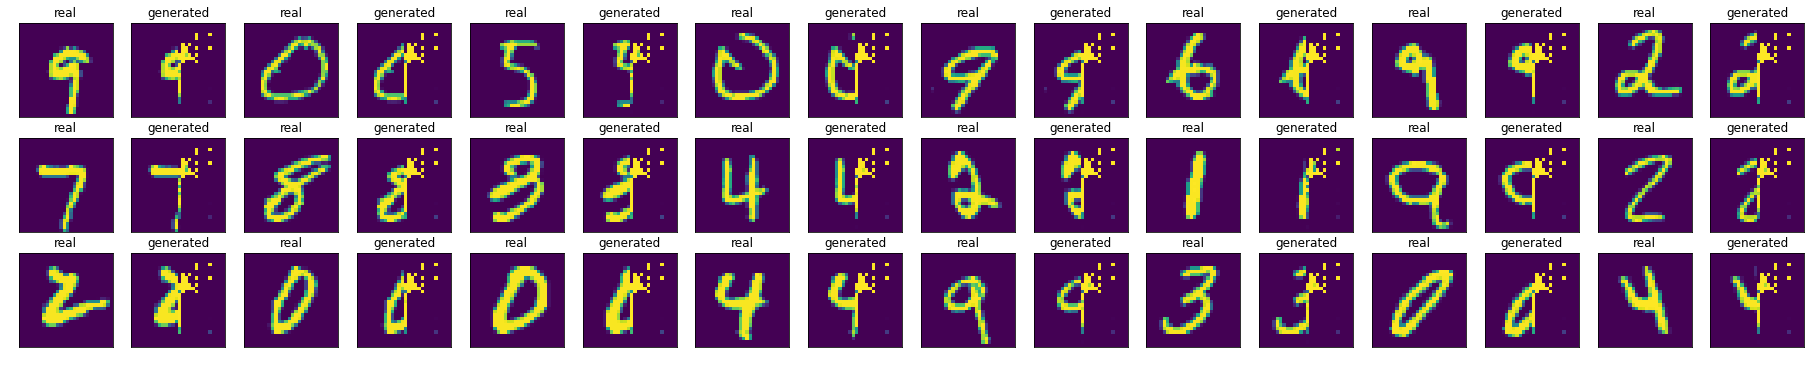

Discriminator Loss: 4.1474e+01 and generator loss is: 2.6226e+01
Epoch 37 ended in 6.10 secs.


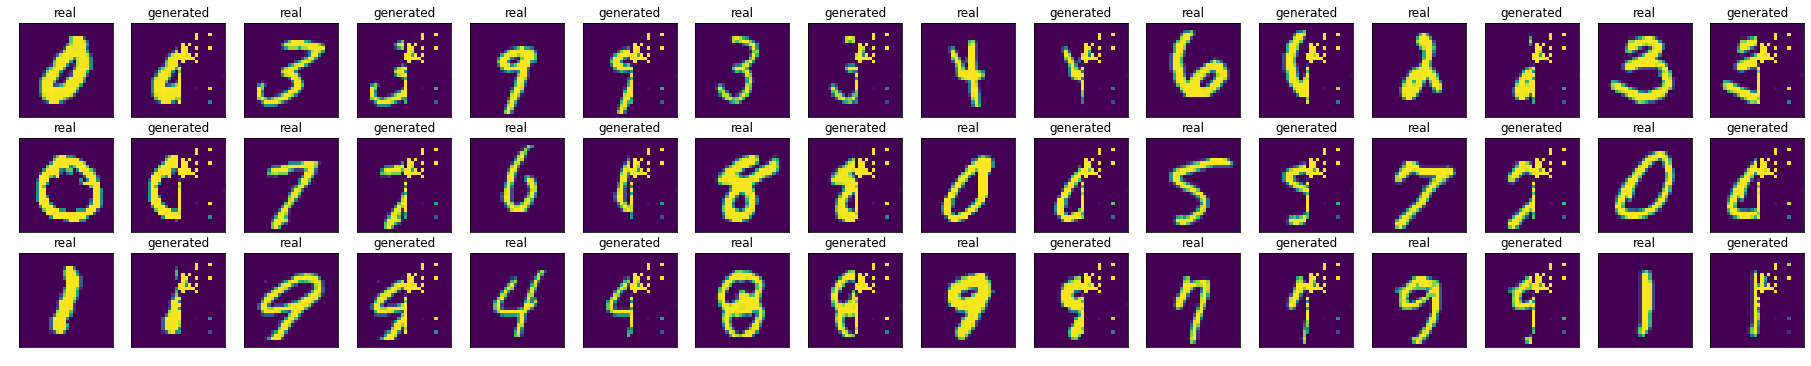

Discriminator Loss: 4.4672e+01 and generator loss is: 2.4996e+01
Epoch 38 ended in 6.10 secs.


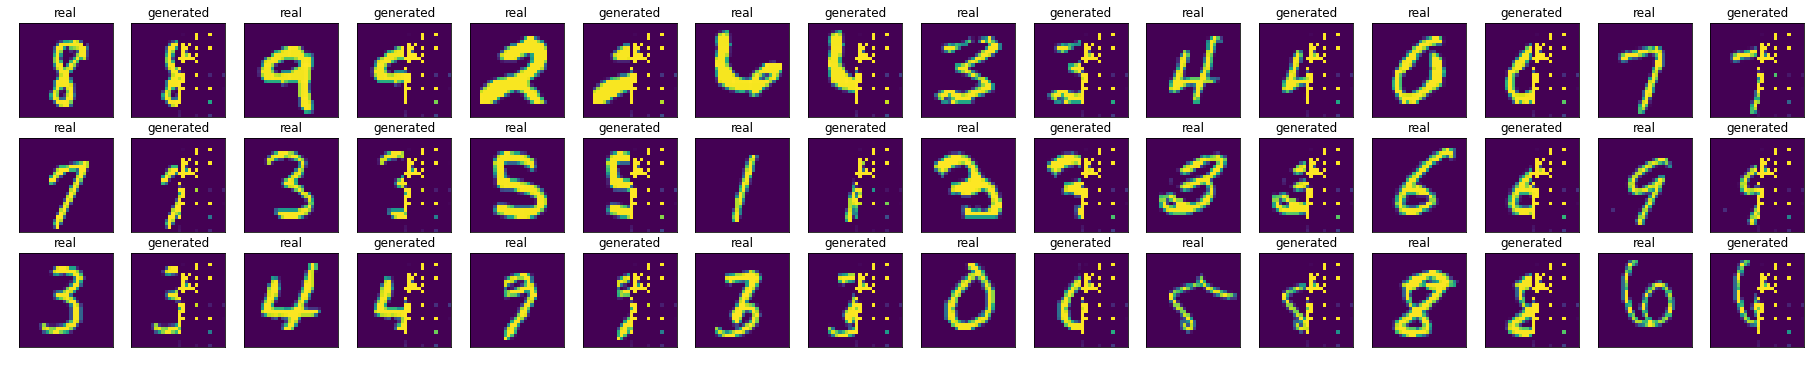

Discriminator Loss: 4.3481e+01 and generator loss is: 2.5950e+01
Epoch 39 ended in 6.10 secs.


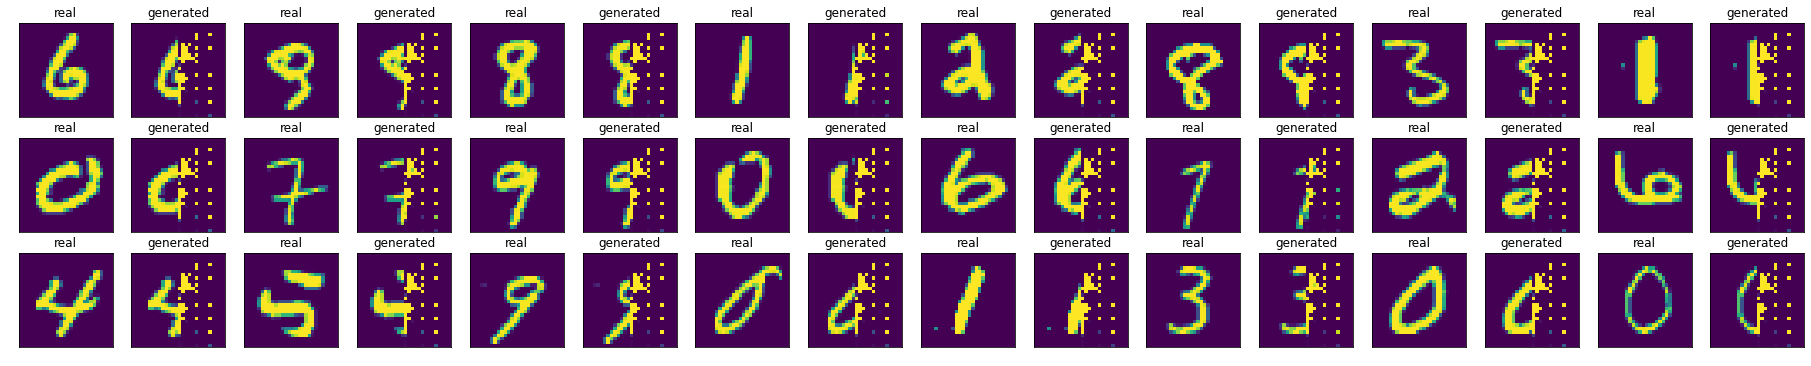

Discriminator Loss: 4.0203e+01 and generator loss is: 2.7294e+01
Epoch 40 ended in 6.10 secs.


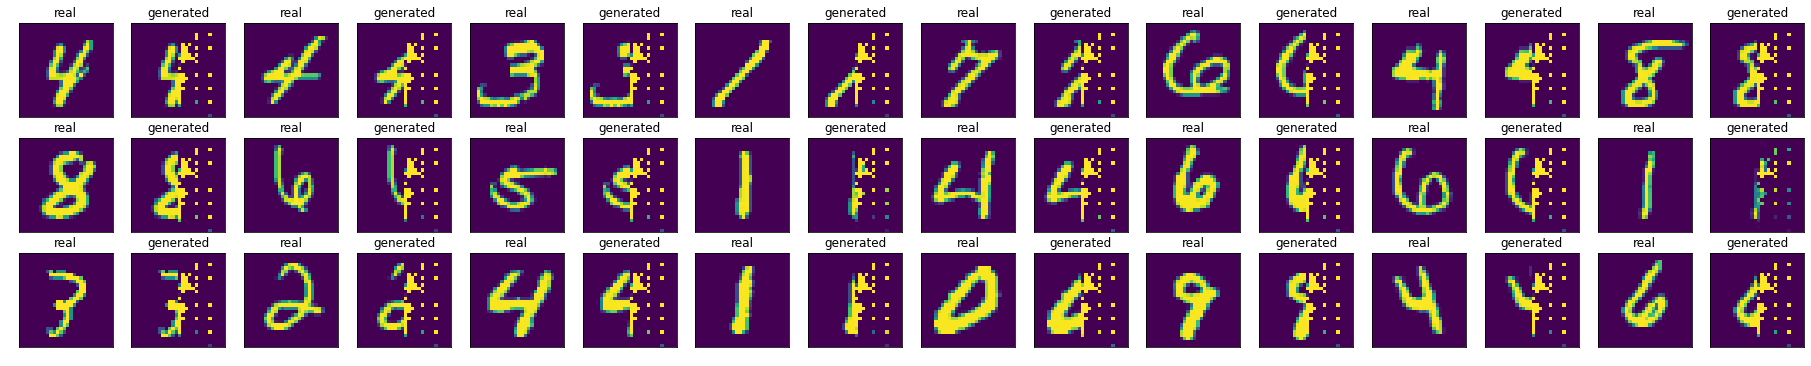

Discriminator Loss: 3.7113e+01 and generator loss is: 2.8242e+01
Epoch 41 ended in 6.11 secs.


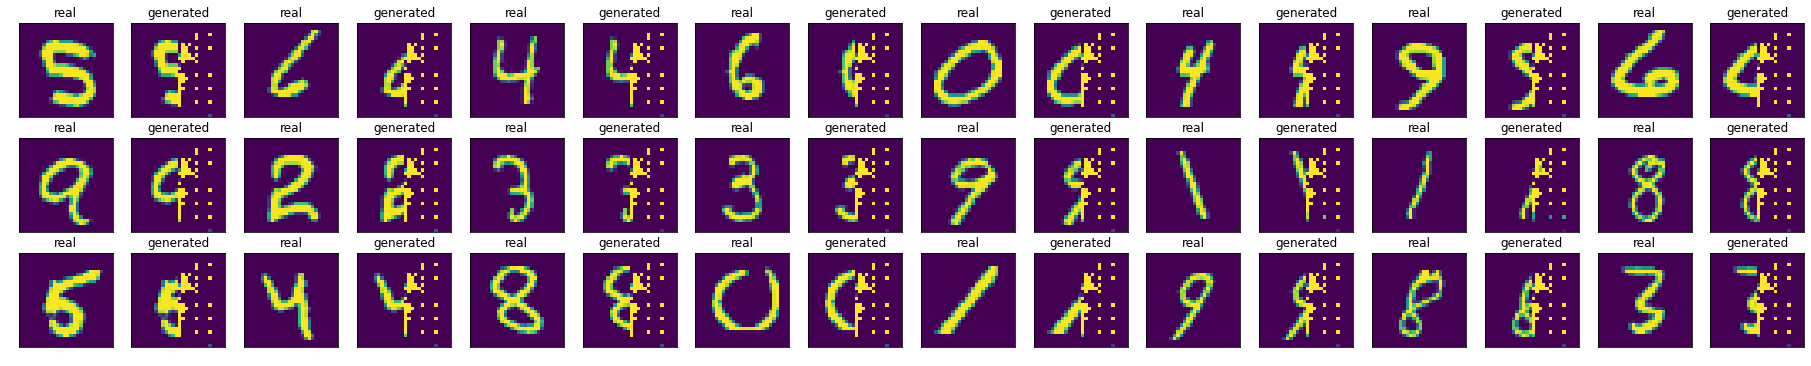

Discriminator Loss: 3.4533e+01 and generator loss is: 2.9011e+01
Epoch 42 ended in 6.10 secs.


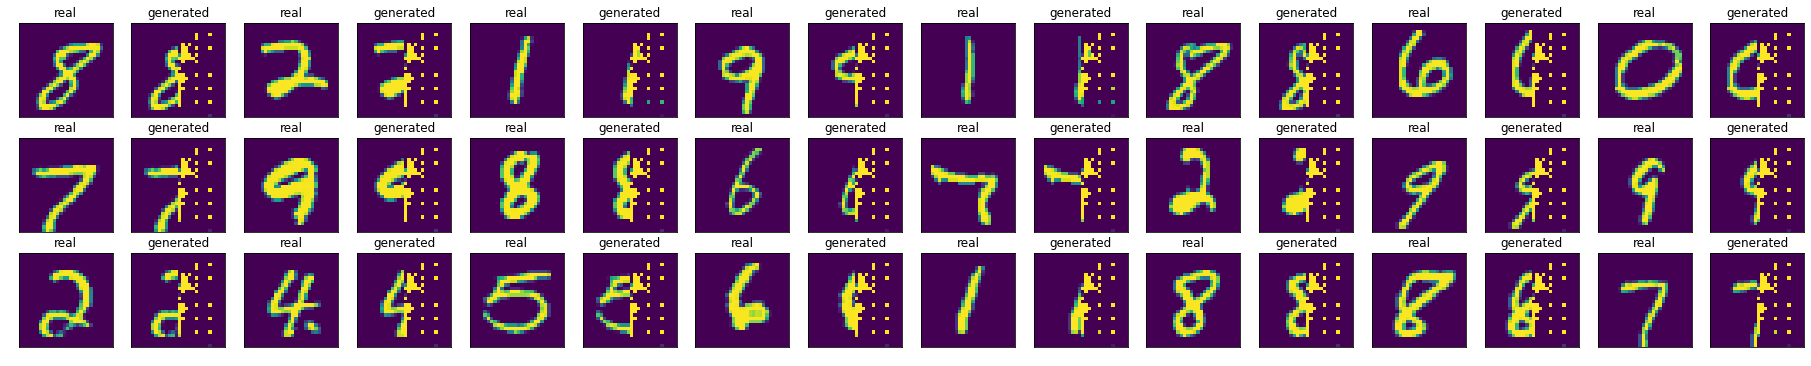

Discriminator Loss: 3.2889e+01 and generator loss is: 2.9506e+01
Epoch 43 ended in 6.09 secs.


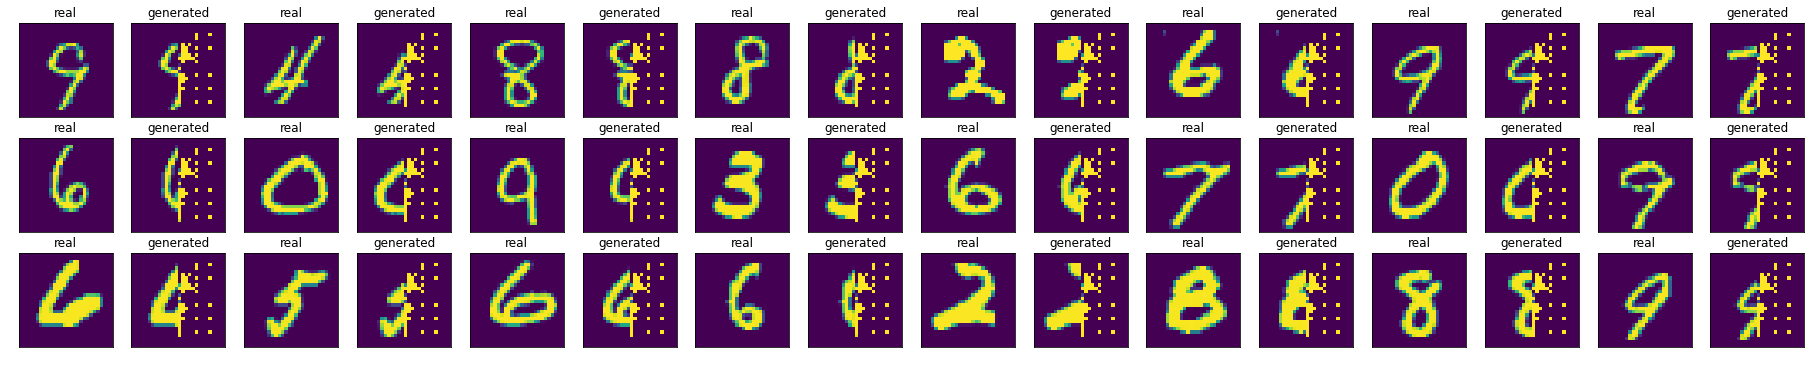

Discriminator Loss: 3.1384e+01 and generator loss is: 2.9905e+01
Epoch 44 ended in 6.12 secs.


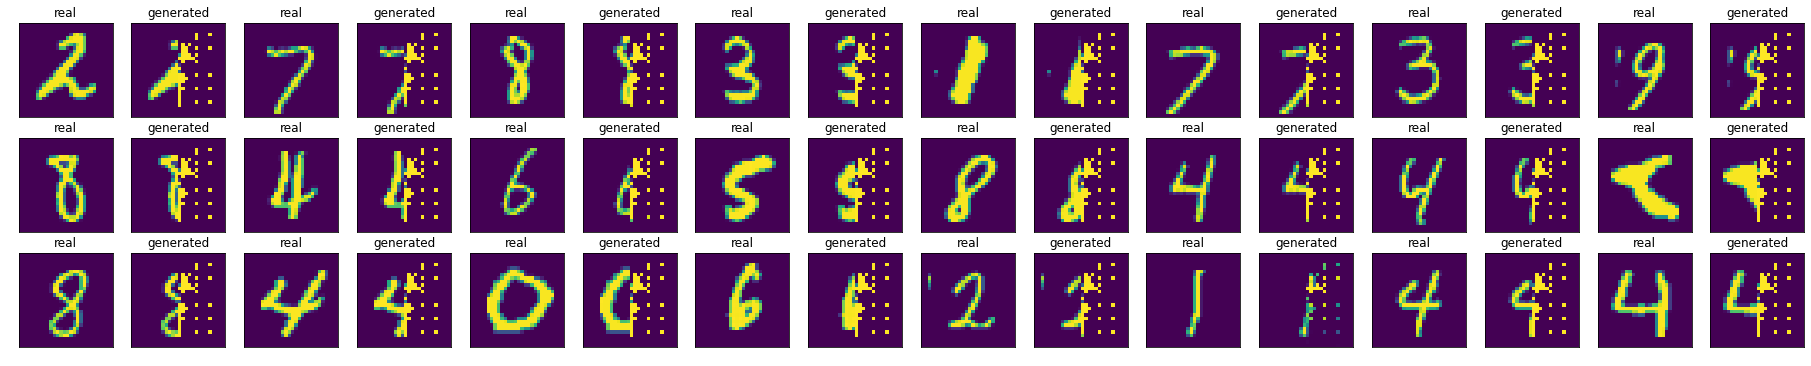

Discriminator Loss: 3.0296e+01 and generator loss is: 3.0533e+01
Epoch 45 ended in 6.10 secs.


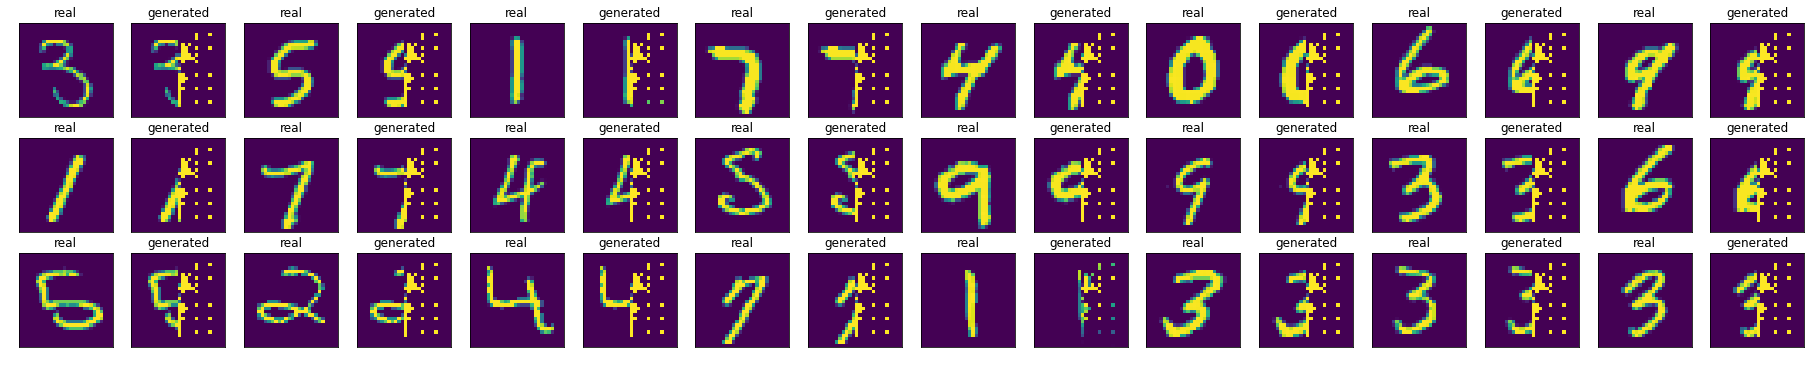

Discriminator Loss: 2.9519e+01 and generator loss is: 3.0721e+01
Epoch 46 ended in 6.09 secs.


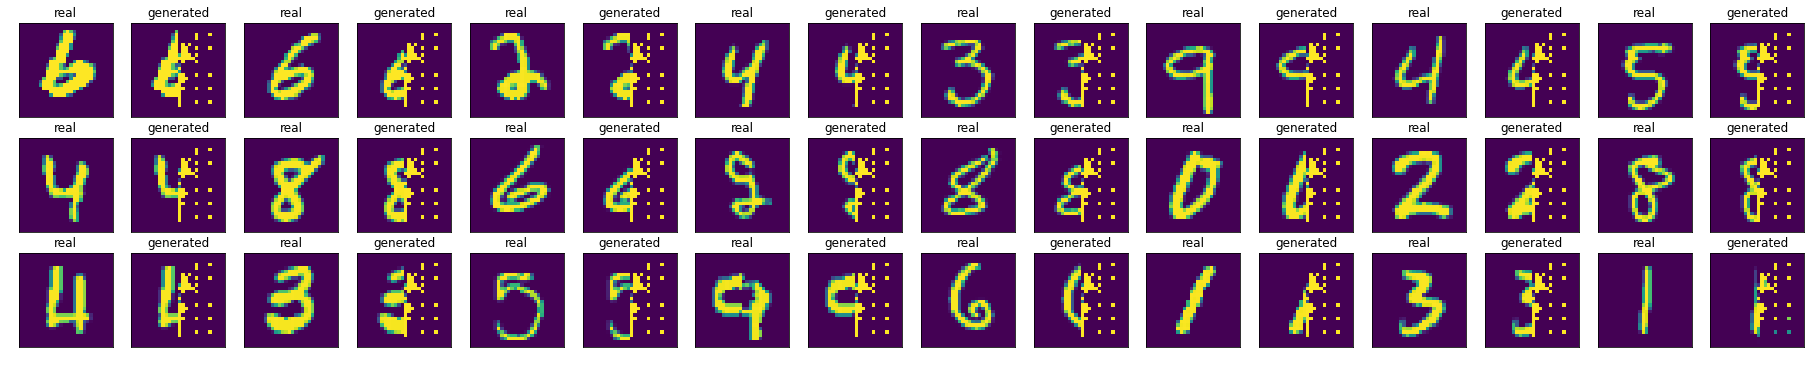

Discriminator Loss: 2.8670e+01 and generator loss is: 3.1055e+01
Epoch 47 ended in 6.09 secs.


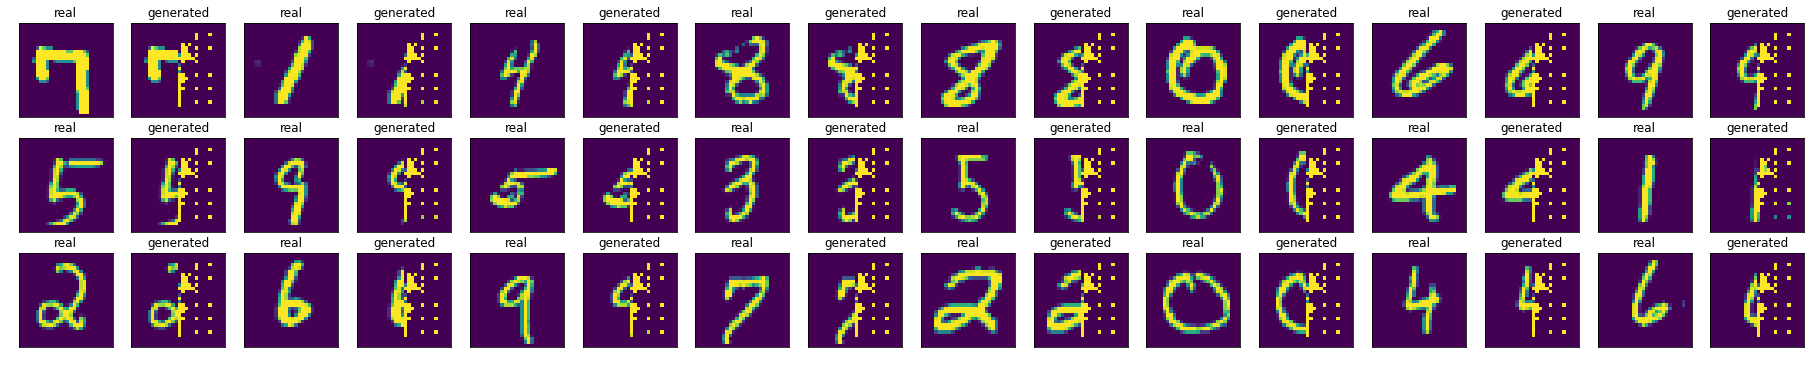

Discriminator Loss: 2.8058e+01 and generator loss is: 3.0999e+01
Epoch 48 ended in 6.10 secs.


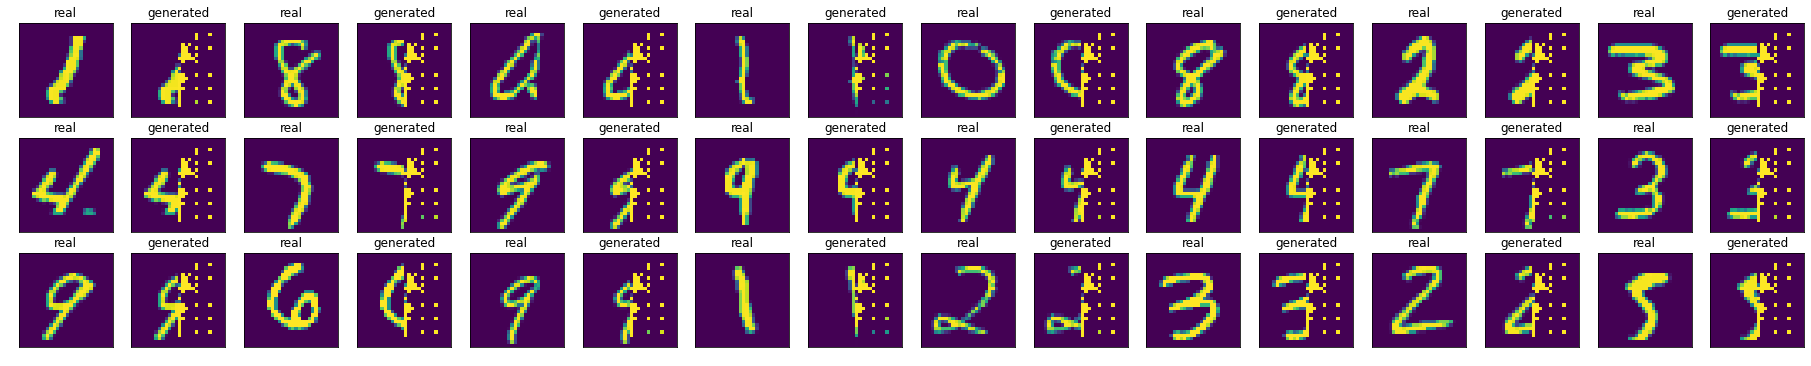

Discriminator Loss: 2.7552e+01 and generator loss is: 3.1191e+01
Epoch 49 ended in 6.11 secs.


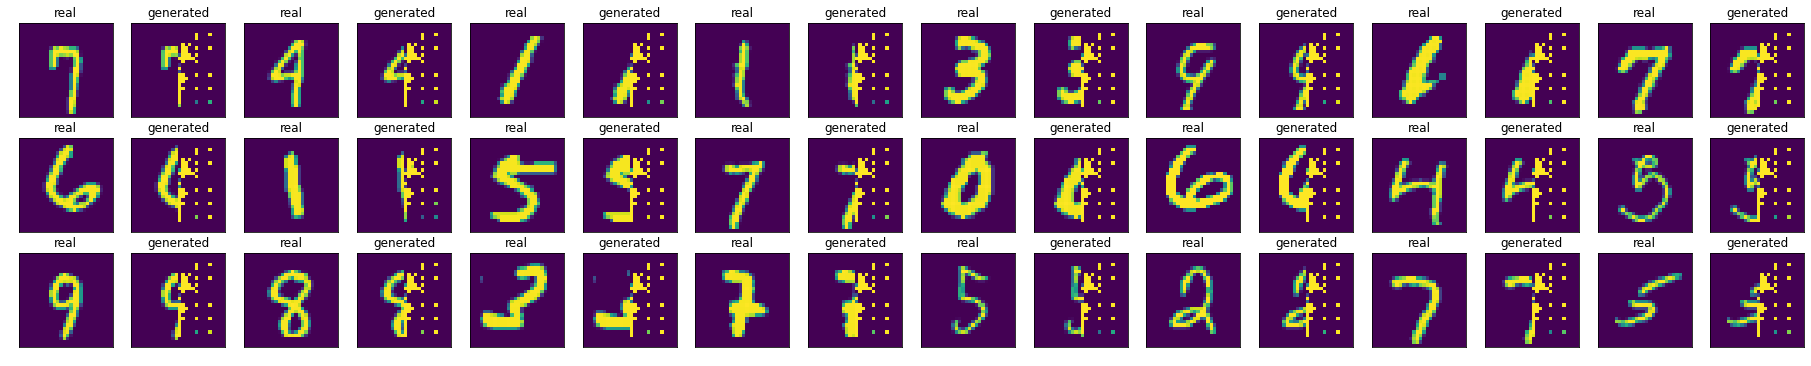

Discriminator Loss: 2.7917e+01 and generator loss is: 3.1089e+01
Epoch 50 ended in 6.10 secs.


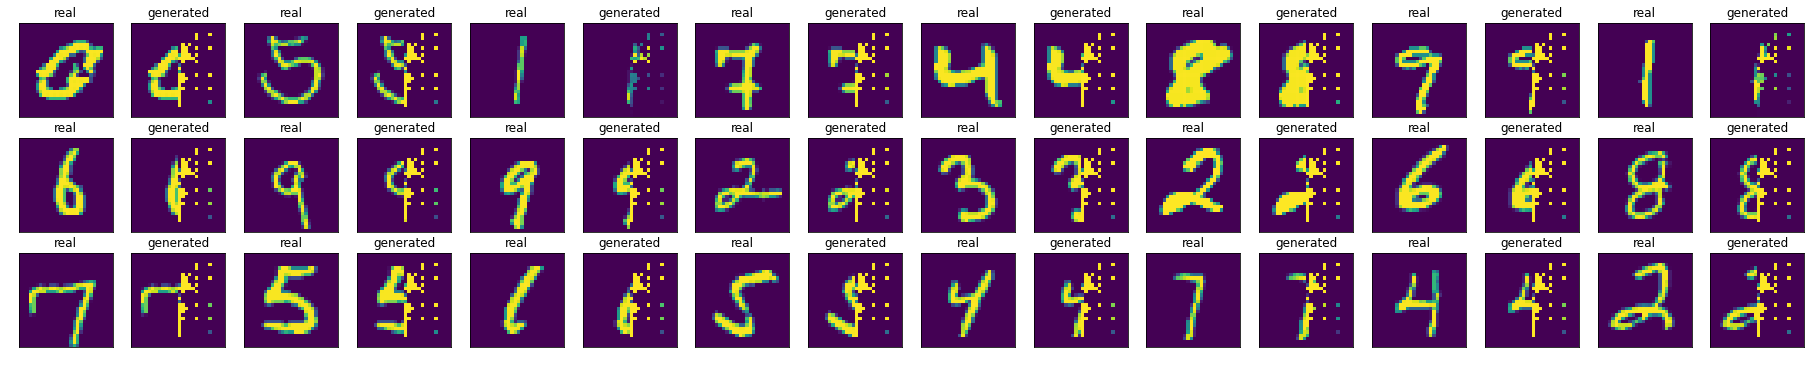

Discriminator Loss: 3.0472e+01 and generator loss is: 2.9697e+01
Epoch 51 ended in 6.10 secs.


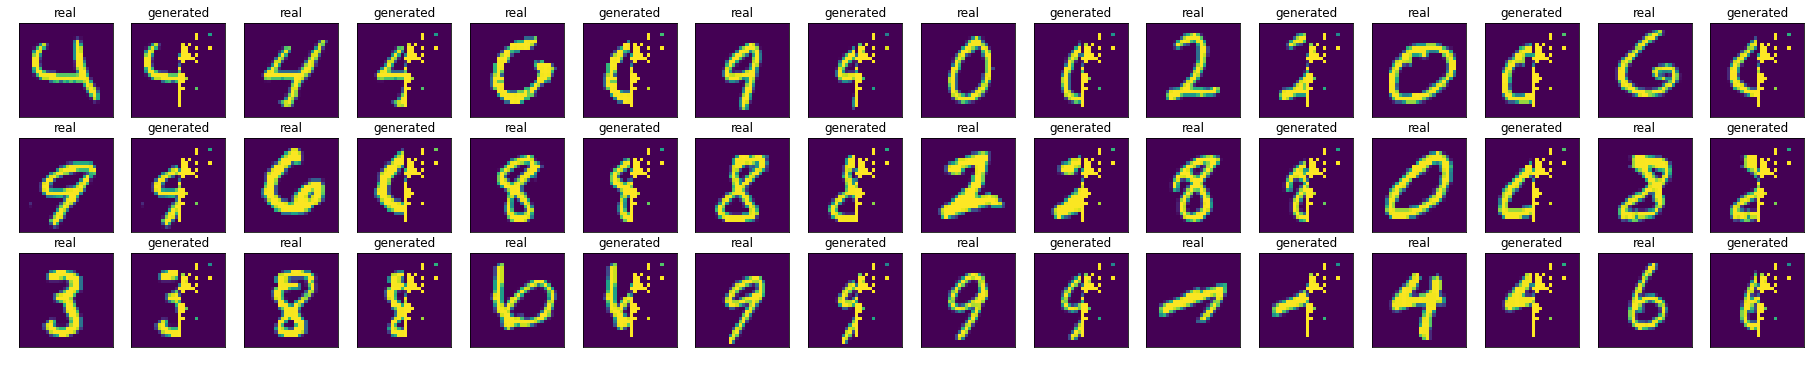

Discriminator Loss: 3.8373e+01 and generator loss is: 2.6447e+01
Epoch 52 ended in 6.10 secs.


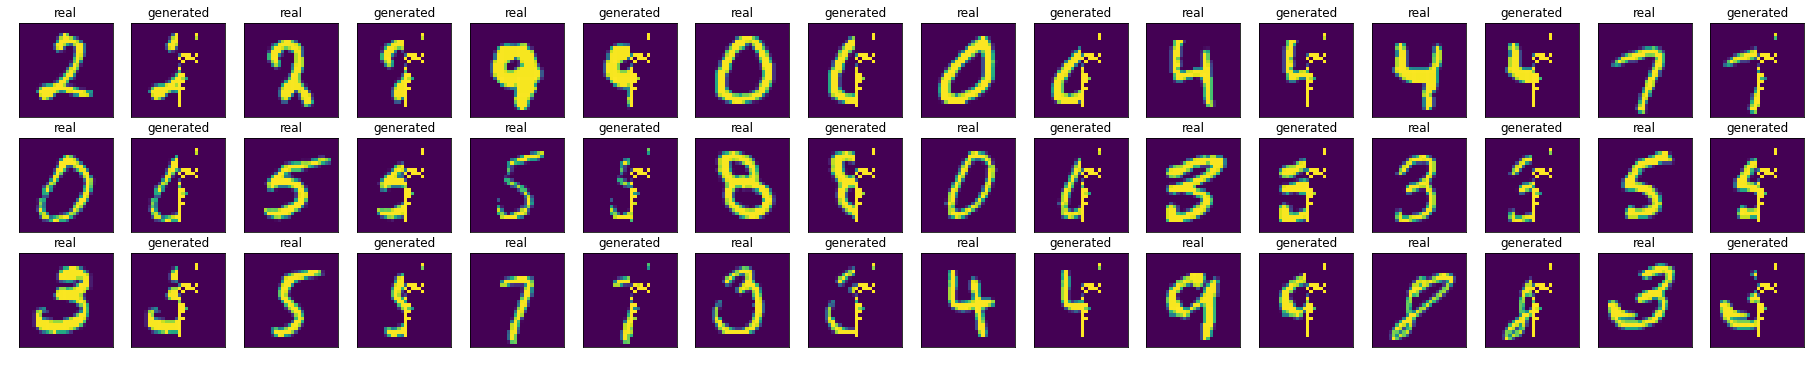

Discriminator Loss: 3.7352e+01 and generator loss is: 2.7512e+01
Epoch 53 ended in 6.09 secs.


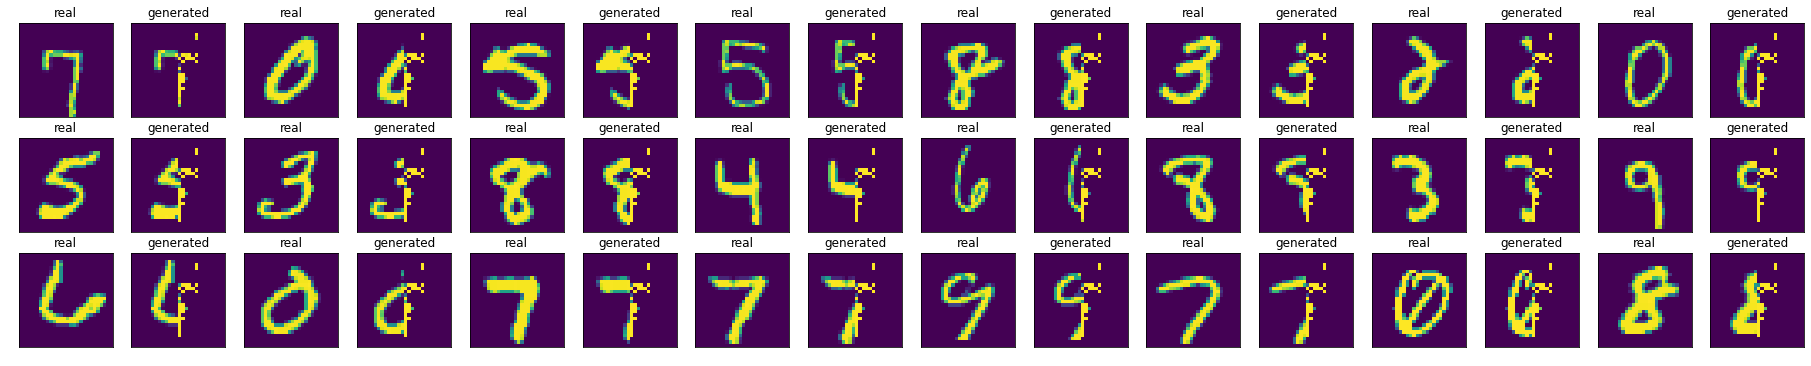

Discriminator Loss: 3.5515e+01 and generator loss is: 2.8174e+01
Epoch 54 ended in 6.10 secs.


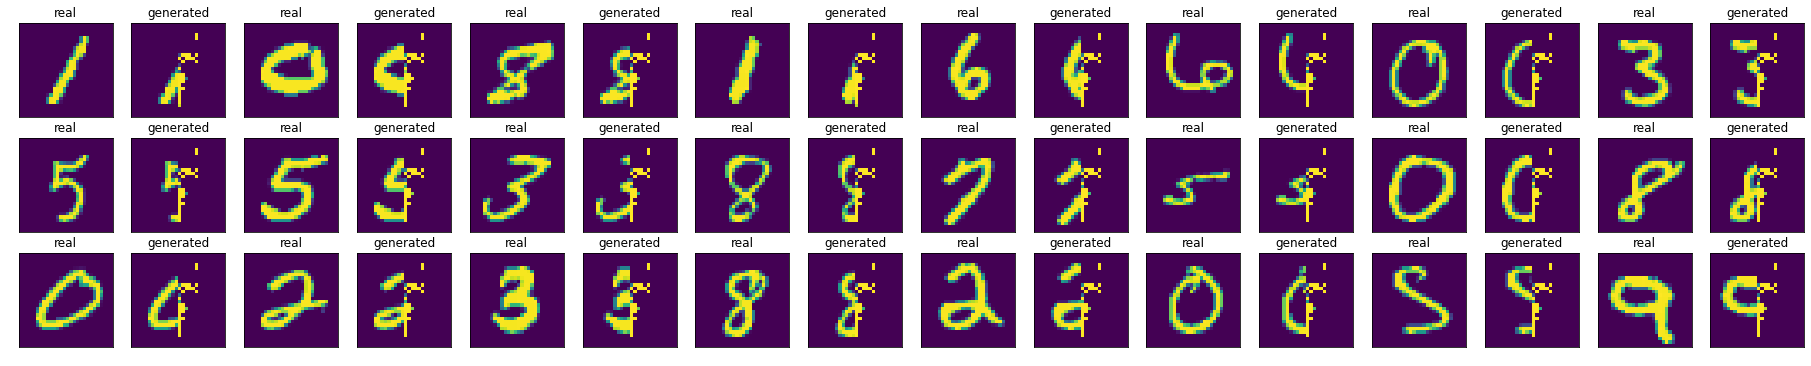

Discriminator Loss: 3.4421e+01 and generator loss is: 2.8660e+01
Epoch 55 ended in 6.09 secs.


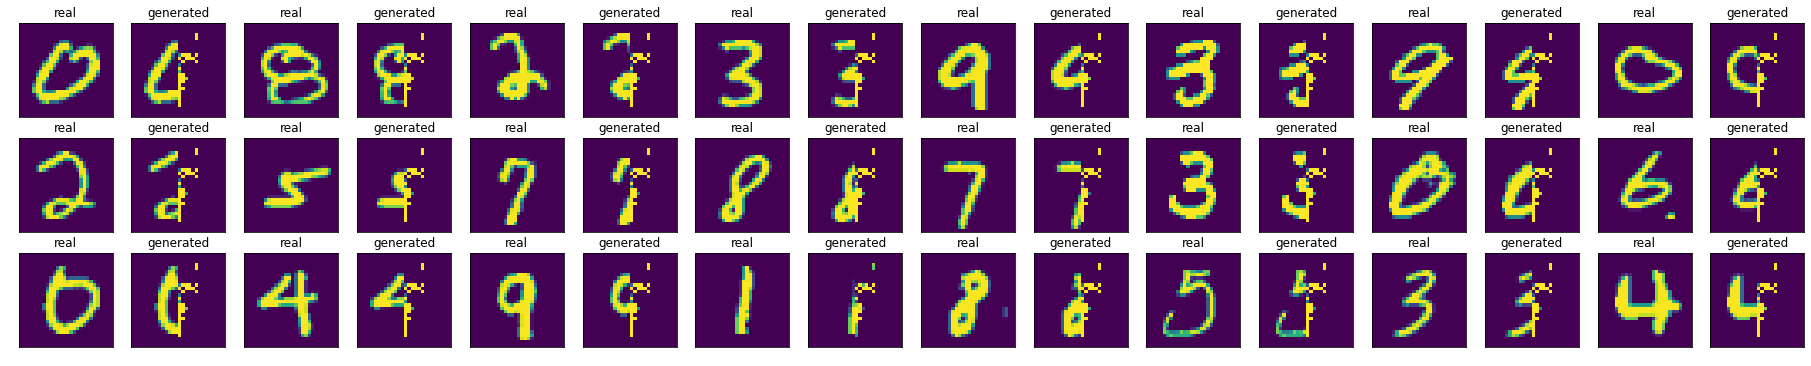

Discriminator Loss: 3.3024e+01 and generator loss is: 2.9161e+01
Epoch 56 ended in 6.08 secs.


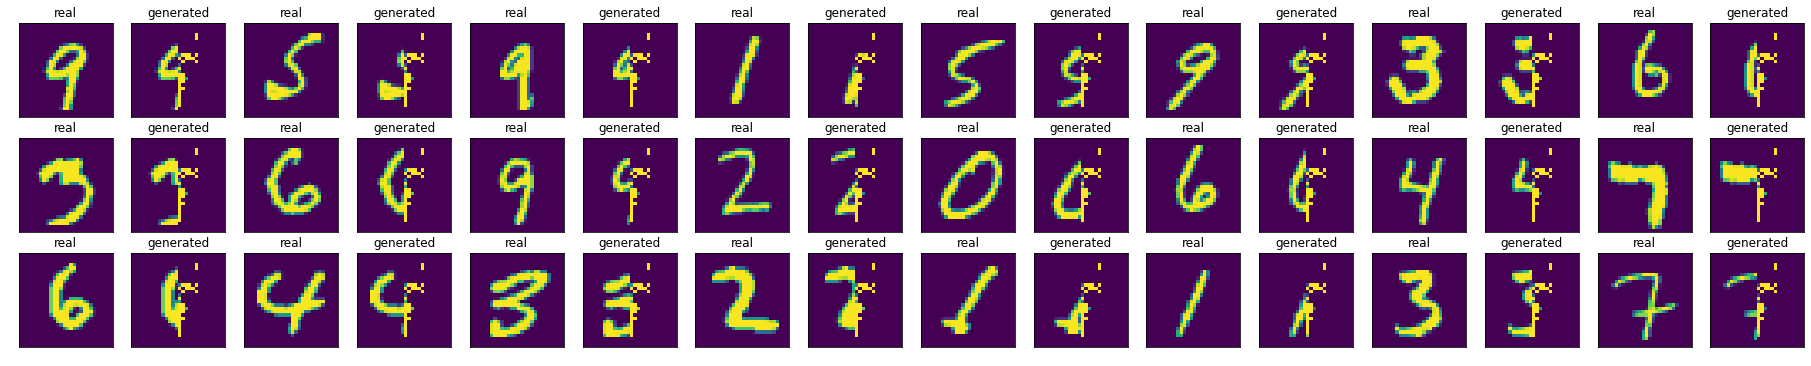

Discriminator Loss: 3.2120e+01 and generator loss is: 2.9385e+01
Epoch 57 ended in 6.10 secs.


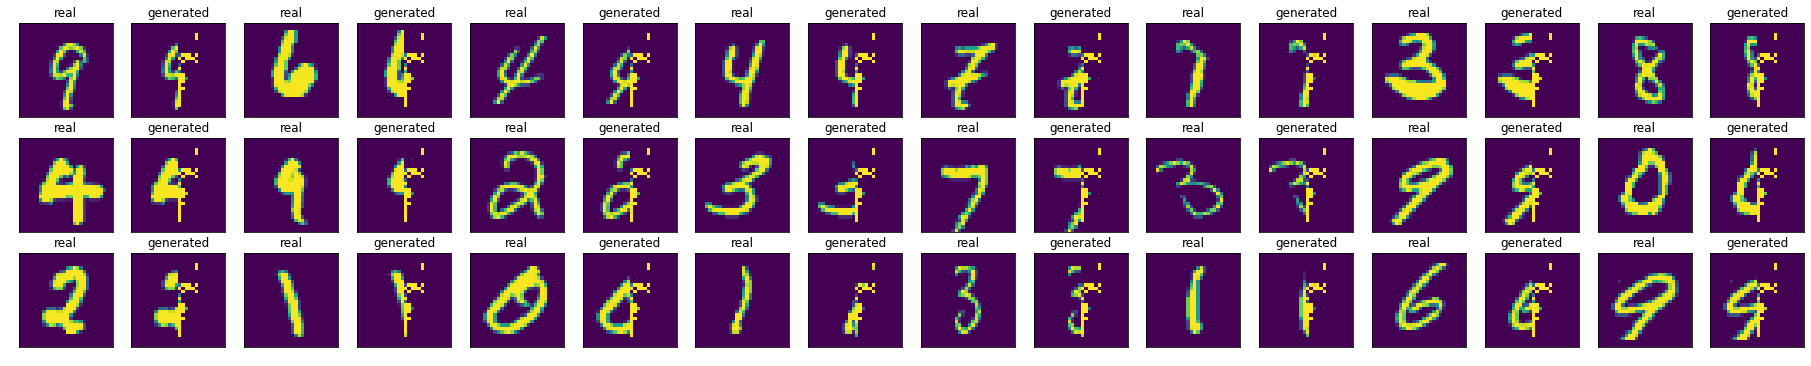

Discriminator Loss: 3.1568e+01 and generator loss is: 2.9638e+01
Epoch 58 ended in 6.10 secs.


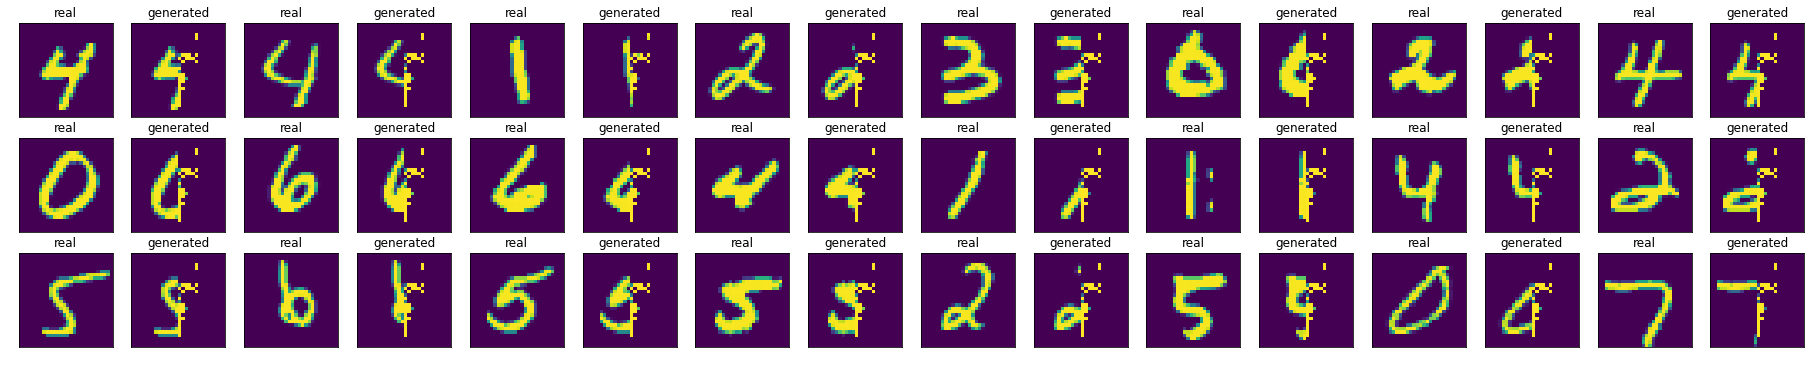

Discriminator Loss: 3.0805e+01 and generator loss is: 2.9786e+01
Epoch 59 ended in 6.10 secs.


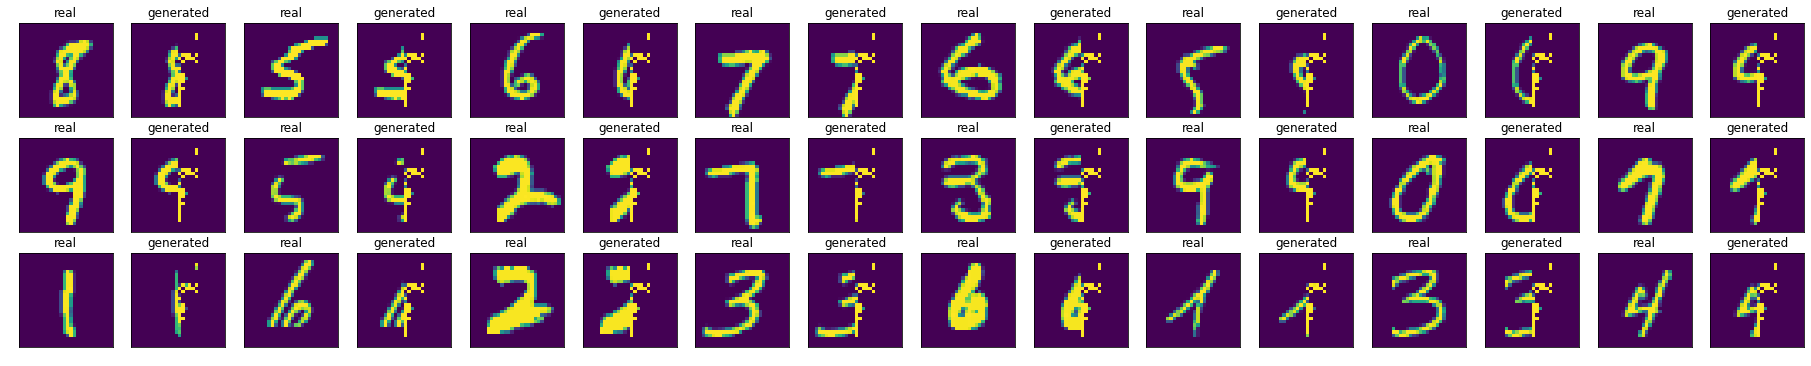

Discriminator Loss: 3.0284e+01 and generator loss is: 3.0046e+01
Epoch 60 ended in 6.10 secs.


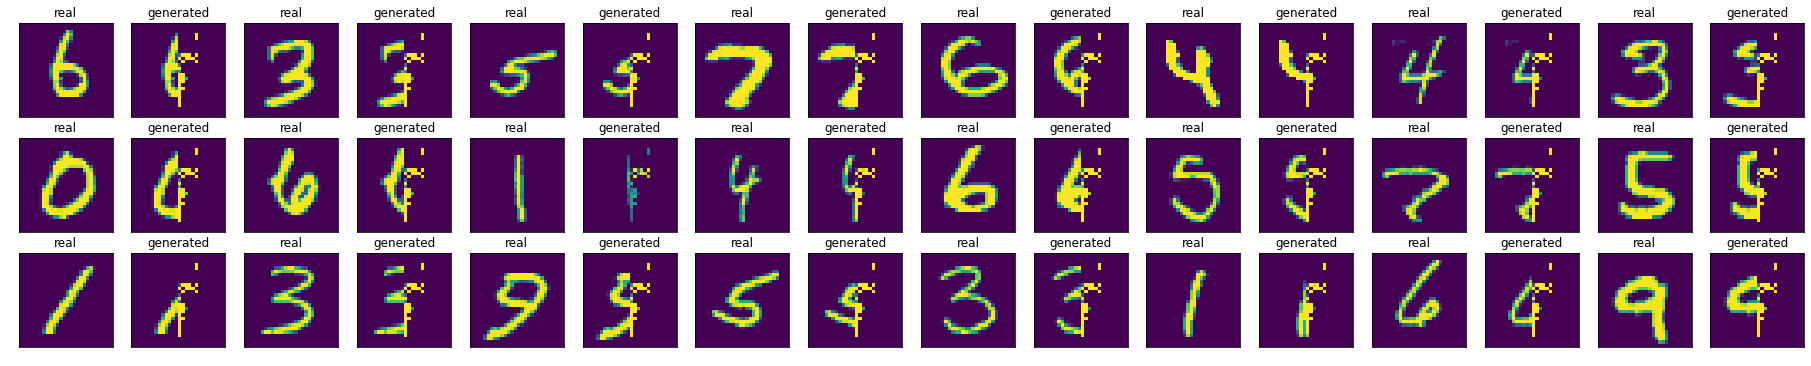

Discriminator Loss: 3.0011e+01 and generator loss is: 3.0261e+01
Epoch 61 ended in 6.10 secs.


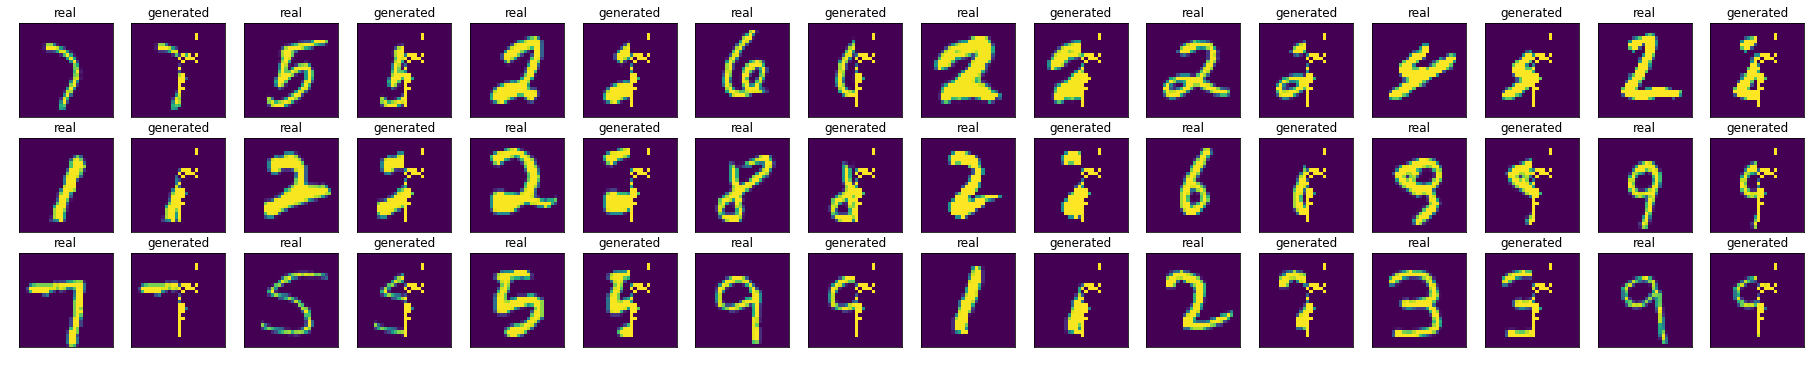

Discriminator Loss: 2.9524e+01 and generator loss is: 3.0492e+01
Epoch 62 ended in 6.09 secs.


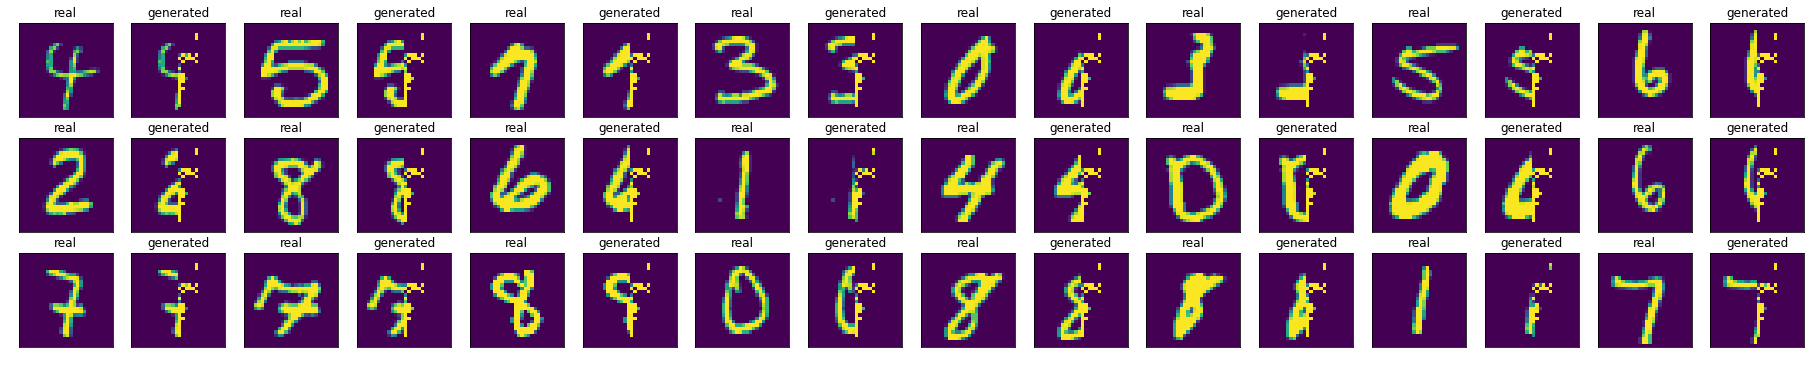

Discriminator Loss: 2.9111e+01 and generator loss is: 3.0342e+01
Epoch 63 ended in 6.08 secs.


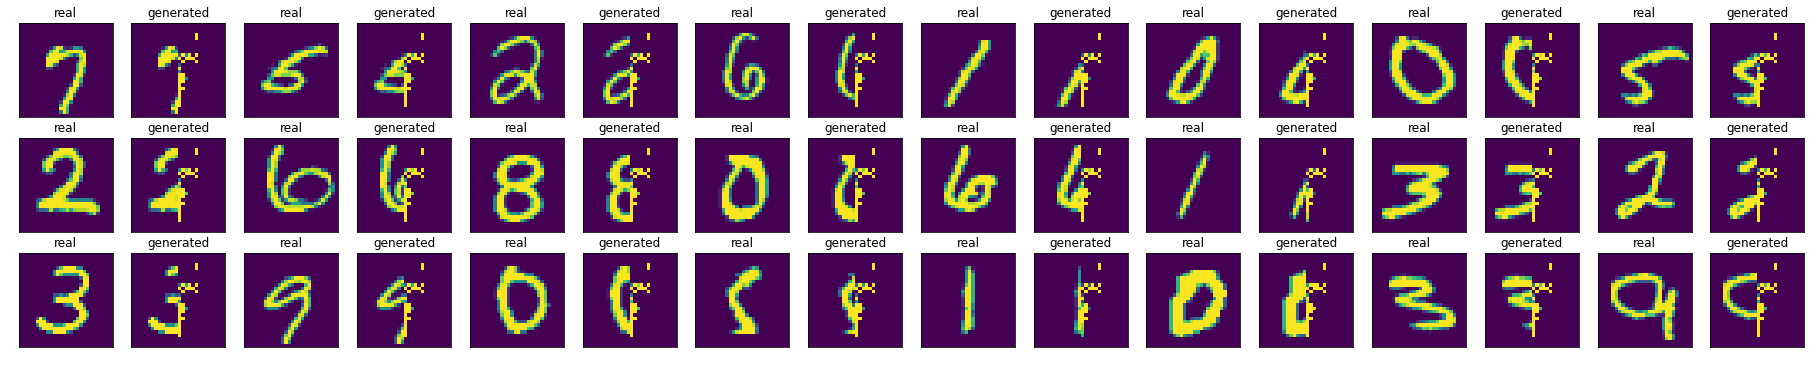

Discriminator Loss: 2.8795e+01 and generator loss is: 3.0617e+01
Epoch 64 ended in 6.09 secs.


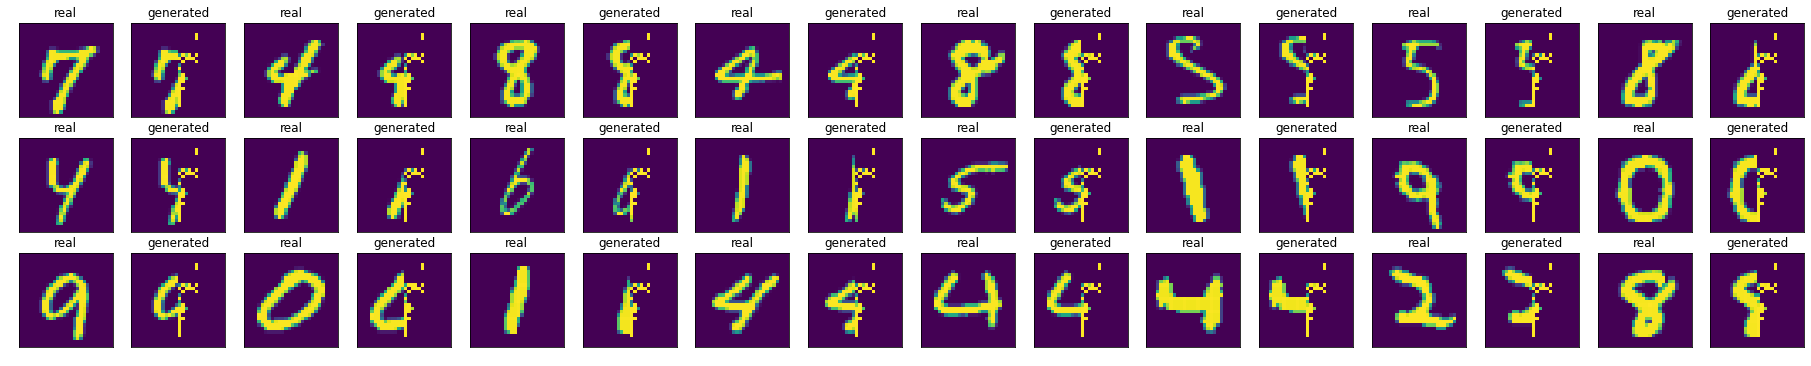

Discriminator Loss: 2.8396e+01 and generator loss is: 3.0665e+01
Epoch 65 ended in 6.10 secs.


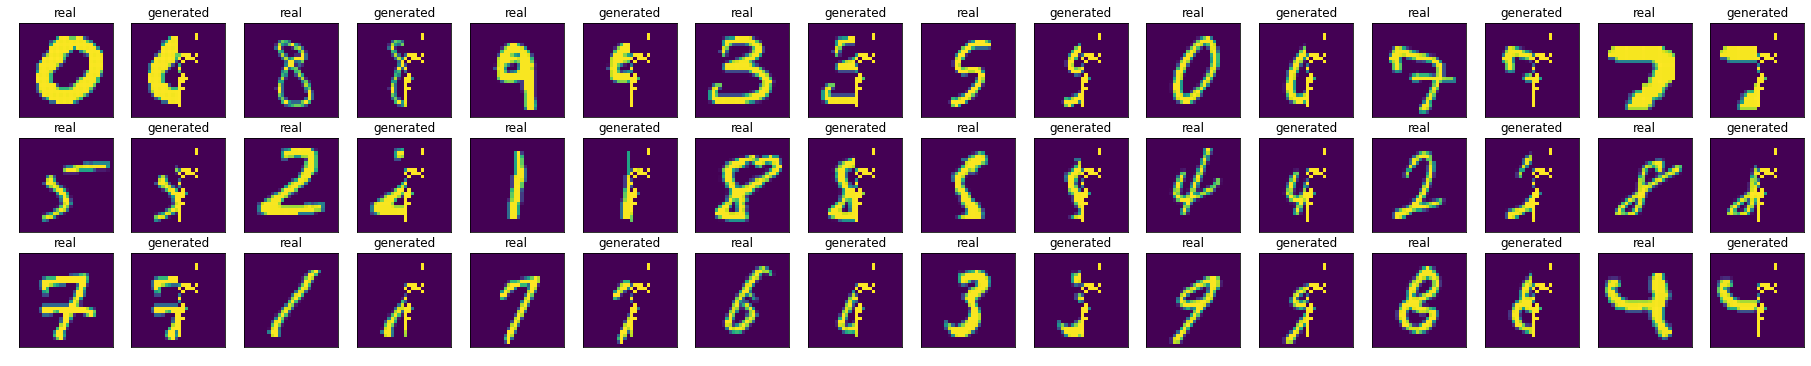

Discriminator Loss: 2.8248e+01 and generator loss is: 3.0723e+01
Epoch 66 ended in 6.10 secs.


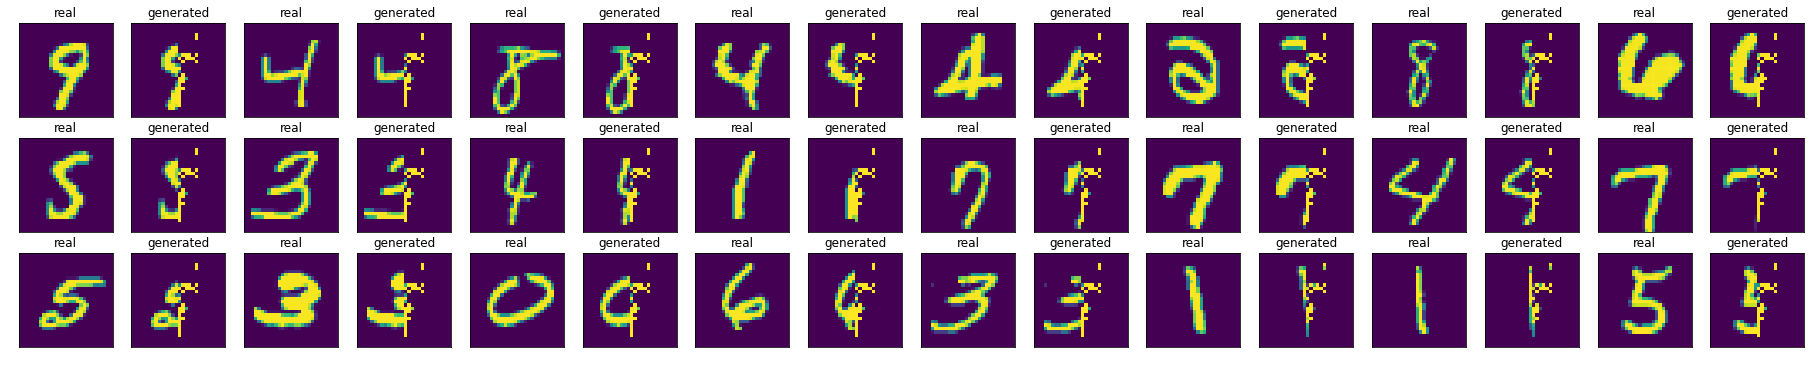

Discriminator Loss: 2.7693e+01 and generator loss is: 3.0857e+01
Epoch 67 ended in 6.10 secs.


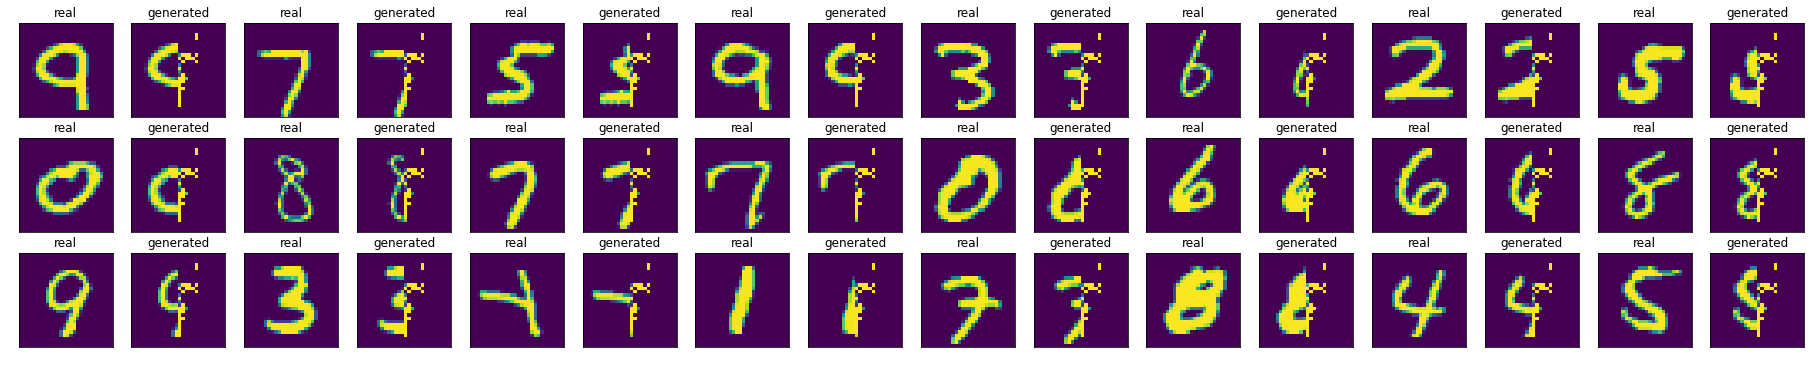

Discriminator Loss: 2.7646e+01 and generator loss is: 3.0986e+01
Epoch 68 ended in 6.09 secs.


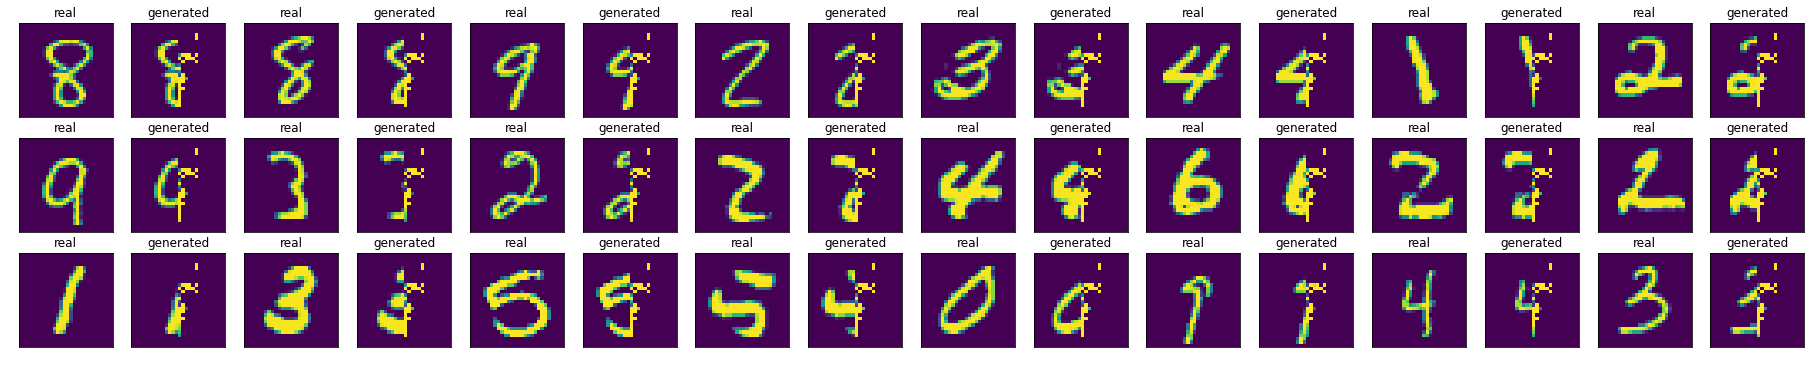

Discriminator Loss: 2.7510e+01 and generator loss is: 3.1000e+01
Epoch 69 ended in 6.11 secs.


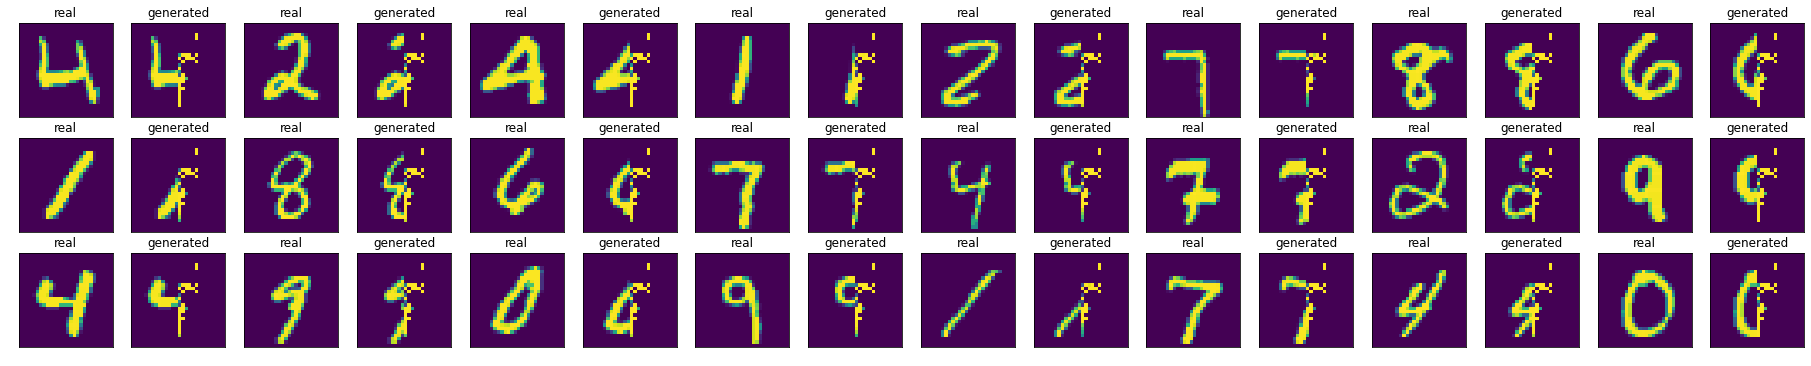

Discriminator Loss: 2.7200e+01 and generator loss is: 3.1109e+01
Epoch 70 ended in 6.10 secs.


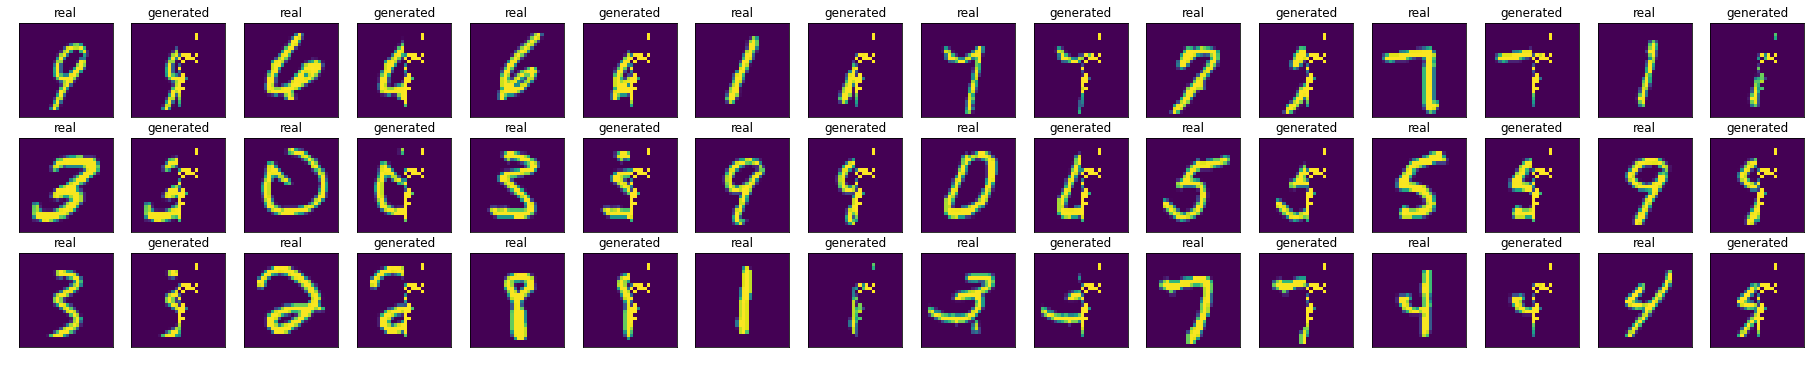

Discriminator Loss: 2.7302e+01 and generator loss is: 3.1217e+01
Epoch 71 ended in 6.10 secs.


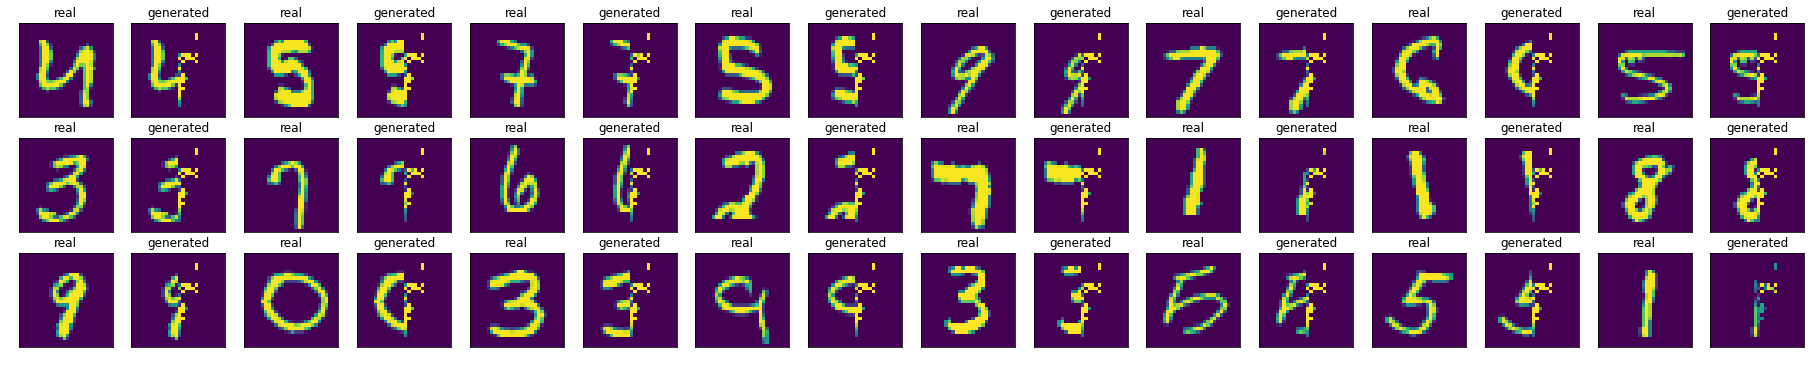

Discriminator Loss: 2.7949e+01 and generator loss is: 3.0624e+01
Epoch 72 ended in 6.10 secs.


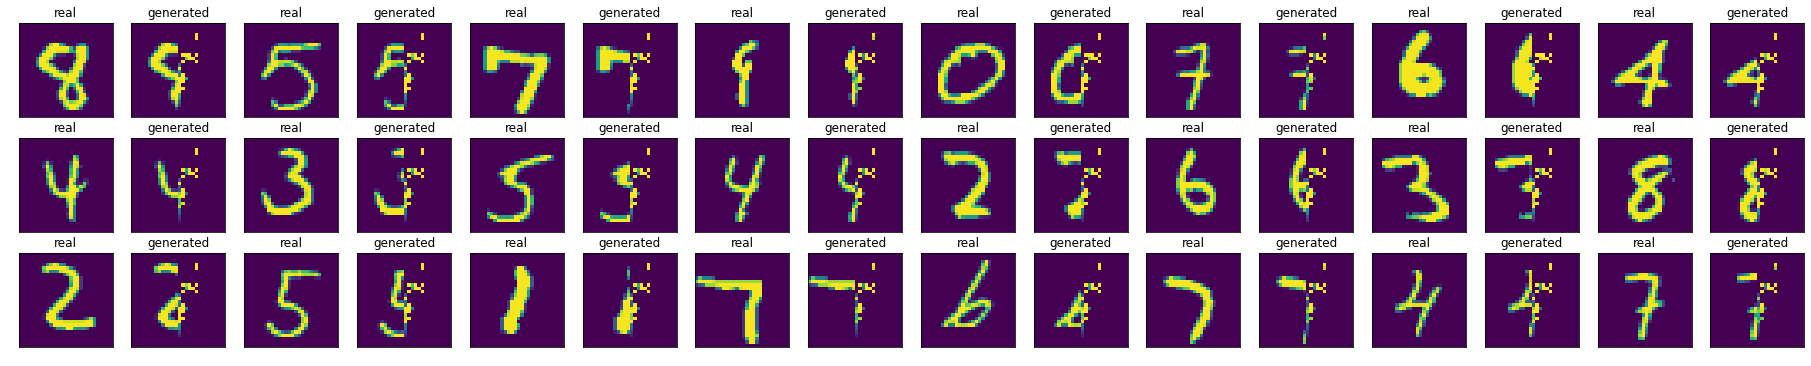

Discriminator Loss: 2.8299e+01 and generator loss is: 3.0395e+01
Epoch 73 ended in 6.09 secs.


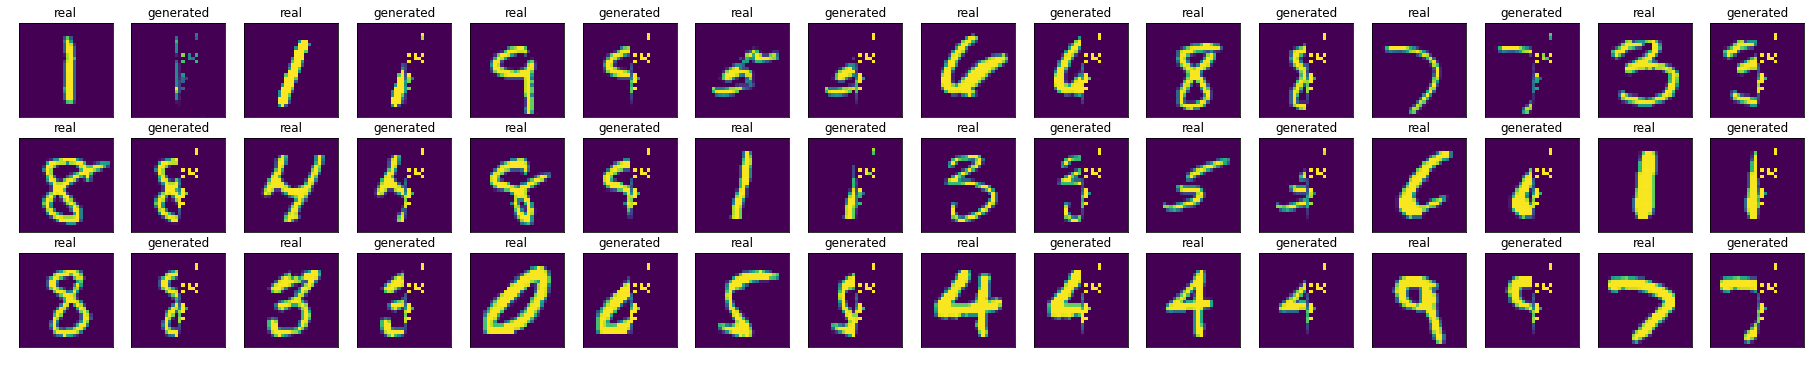

Discriminator Loss: 2.7898e+01 and generator loss is: 3.0679e+01
Epoch 74 ended in 6.09 secs.


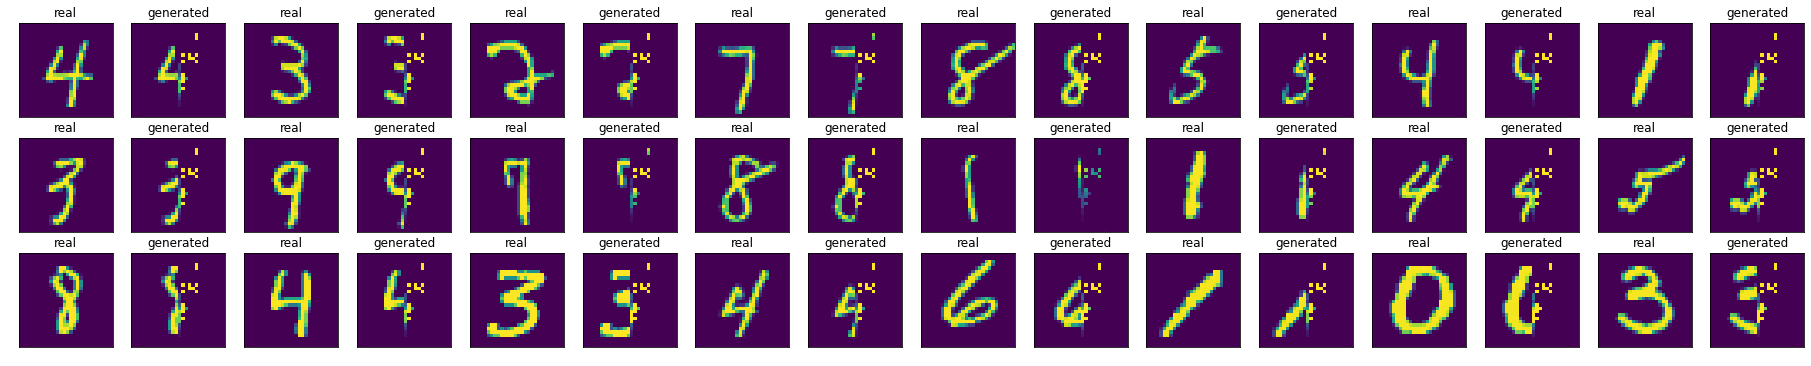

Discriminator Loss: 2.7534e+01 and generator loss is: 3.0930e+01
Epoch 75 ended in 6.09 secs.


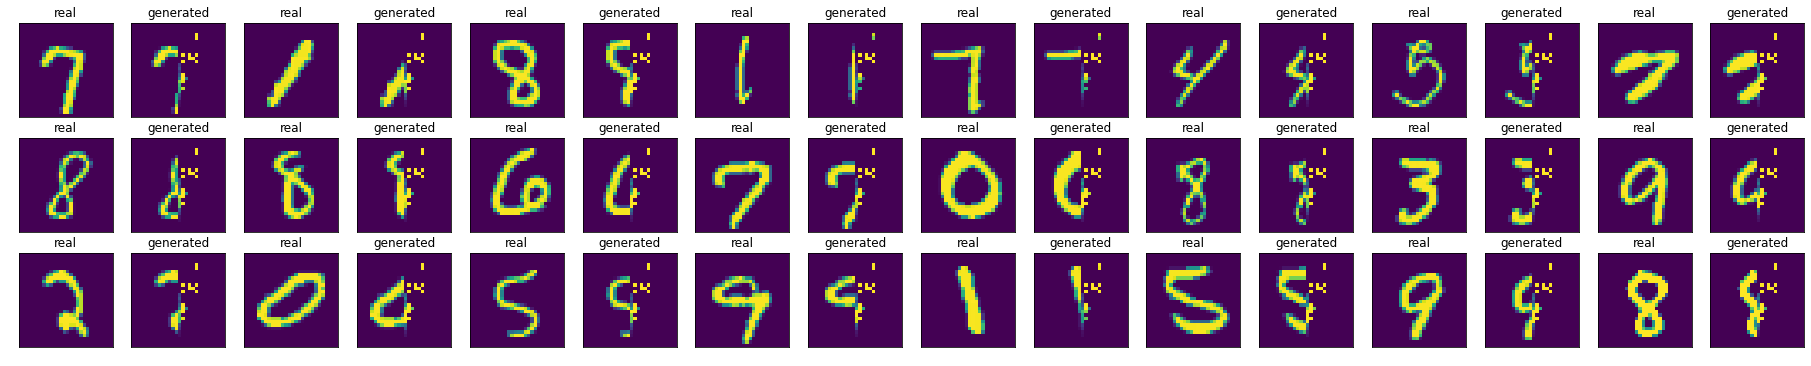

Discriminator Loss: 2.7127e+01 and generator loss is: 3.0964e+01
Epoch 76 ended in 6.09 secs.


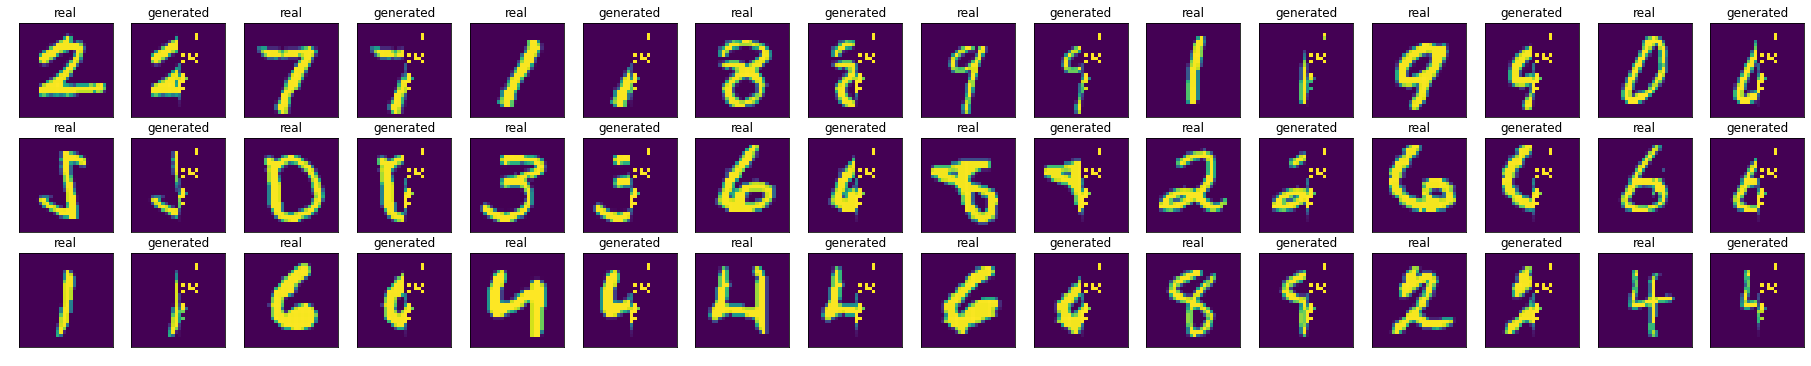

Discriminator Loss: 2.7049e+01 and generator loss is: 3.1014e+01
Epoch 77 ended in 6.10 secs.


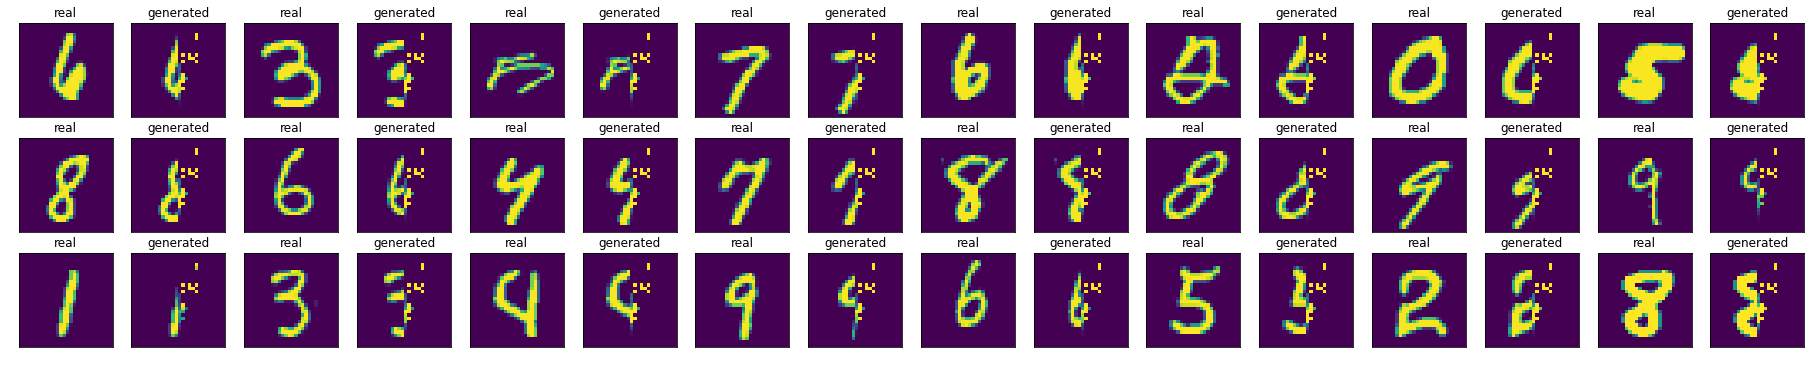

Discriminator Loss: 2.6806e+01 and generator loss is: 3.1120e+01
Epoch 78 ended in 6.09 secs.


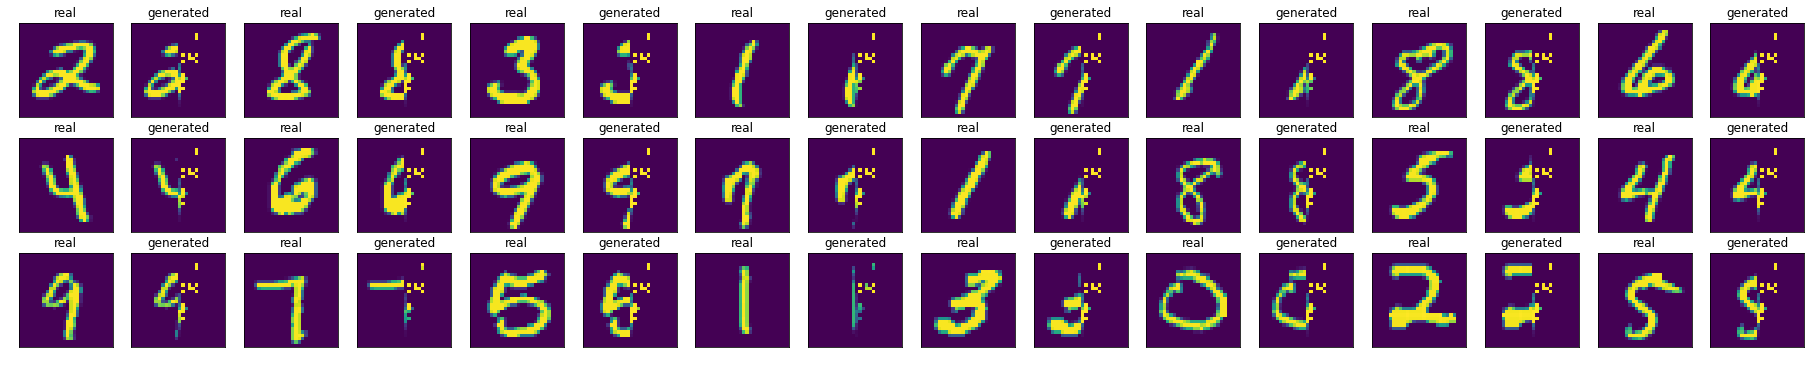

Discriminator Loss: 2.6649e+01 and generator loss is: 3.1185e+01
Epoch 79 ended in 6.09 secs.


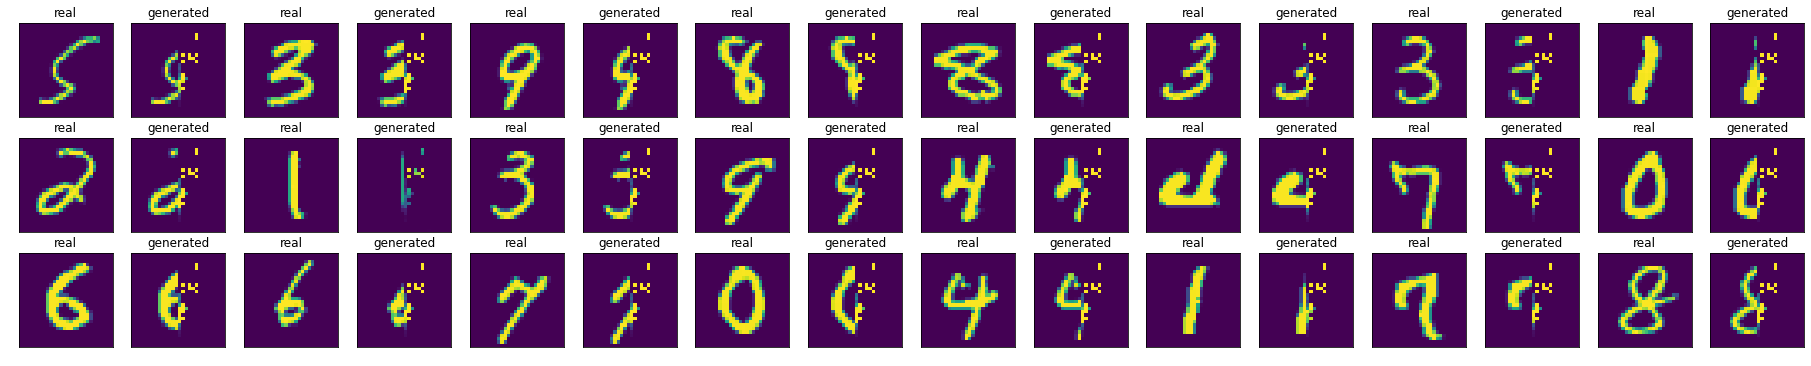

Discriminator Loss: 2.6345e+01 and generator loss is: 3.1429e+01
Epoch 80 ended in 6.09 secs.


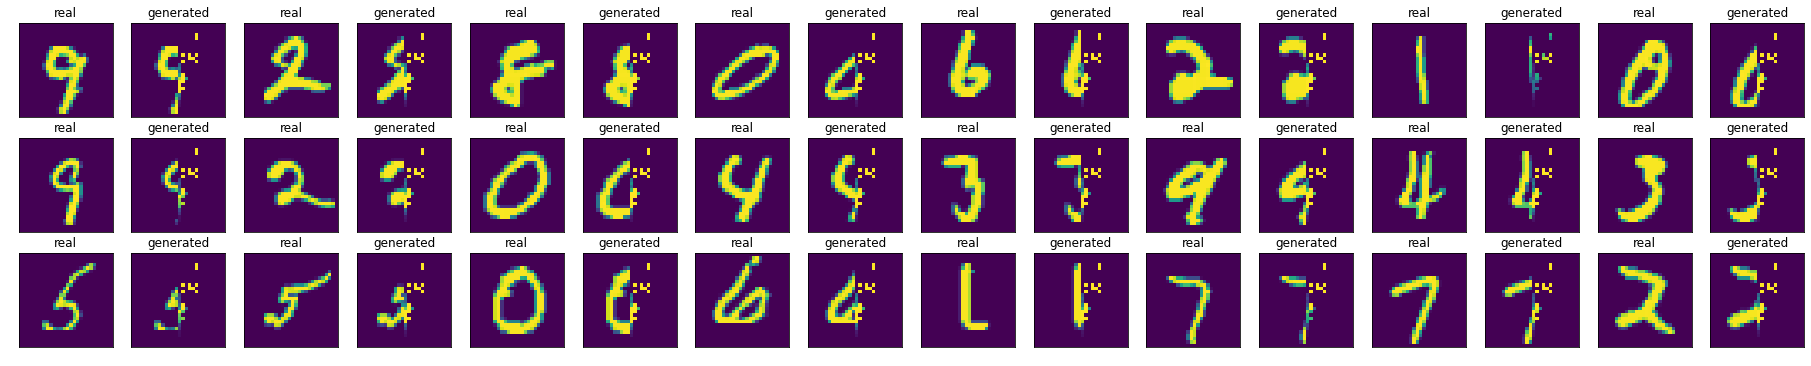

Discriminator Loss: 2.6308e+01 and generator loss is: 3.1335e+01
Epoch 81 ended in 6.10 secs.


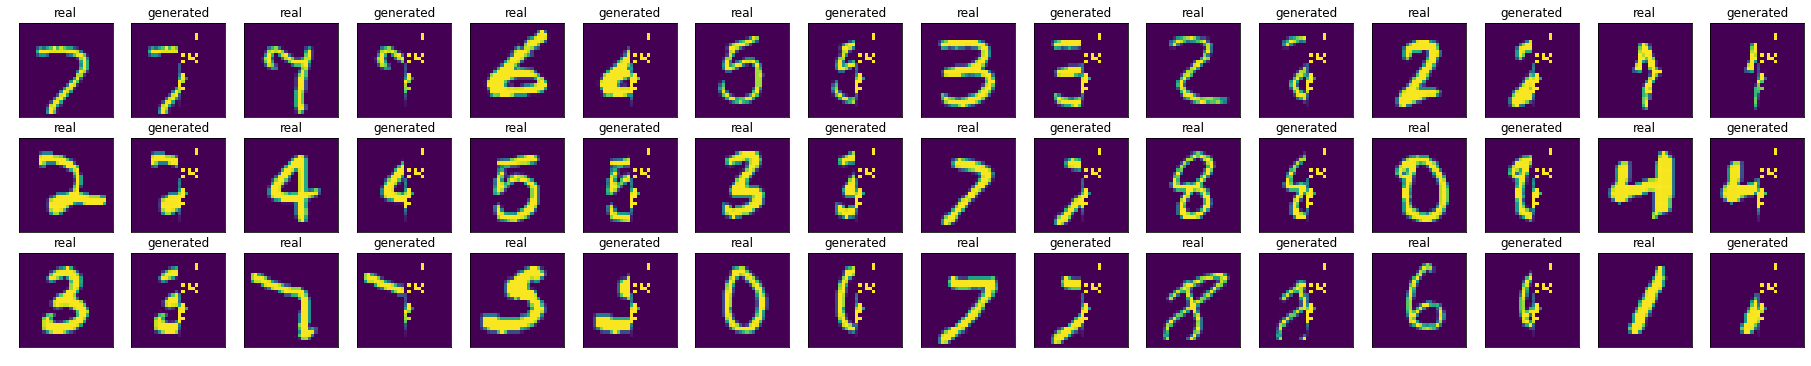

Discriminator Loss: 2.6202e+01 and generator loss is: 3.1544e+01
Epoch 82 ended in 6.10 secs.


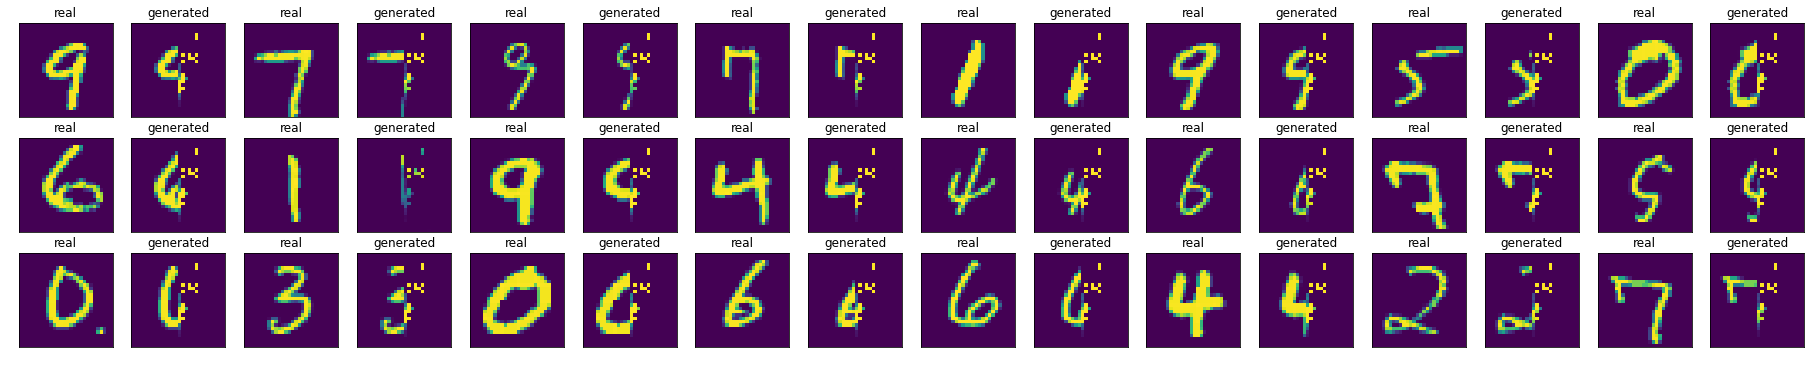

Discriminator Loss: 2.6056e+01 and generator loss is: 3.1559e+01
Epoch 83 ended in 6.10 secs.


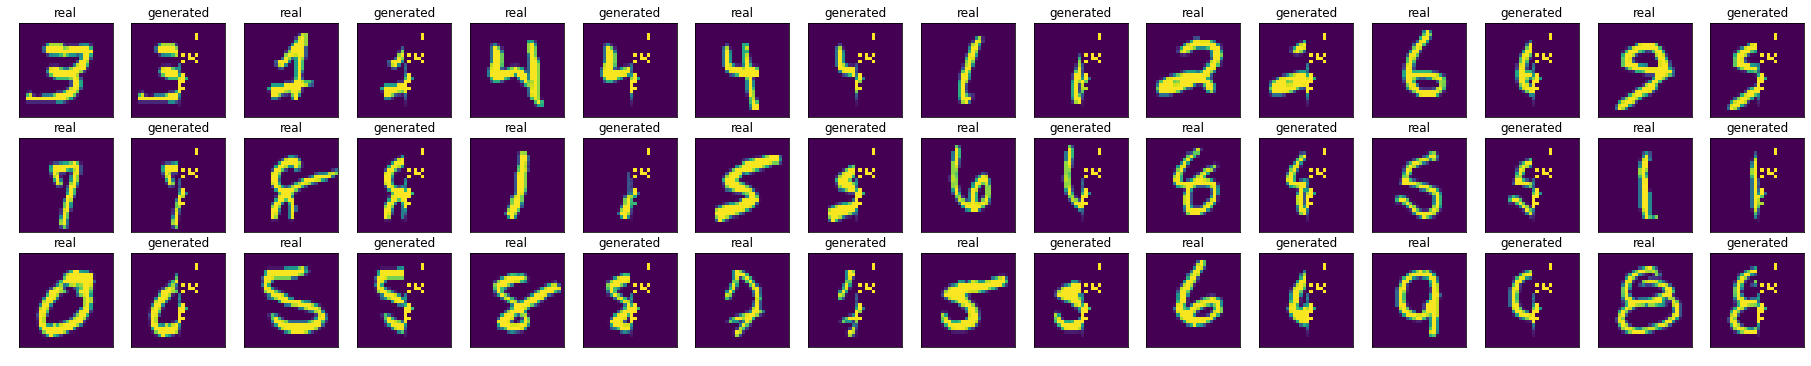

Discriminator Loss: 2.5936e+01 and generator loss is: 3.1528e+01
Epoch 84 ended in 6.11 secs.


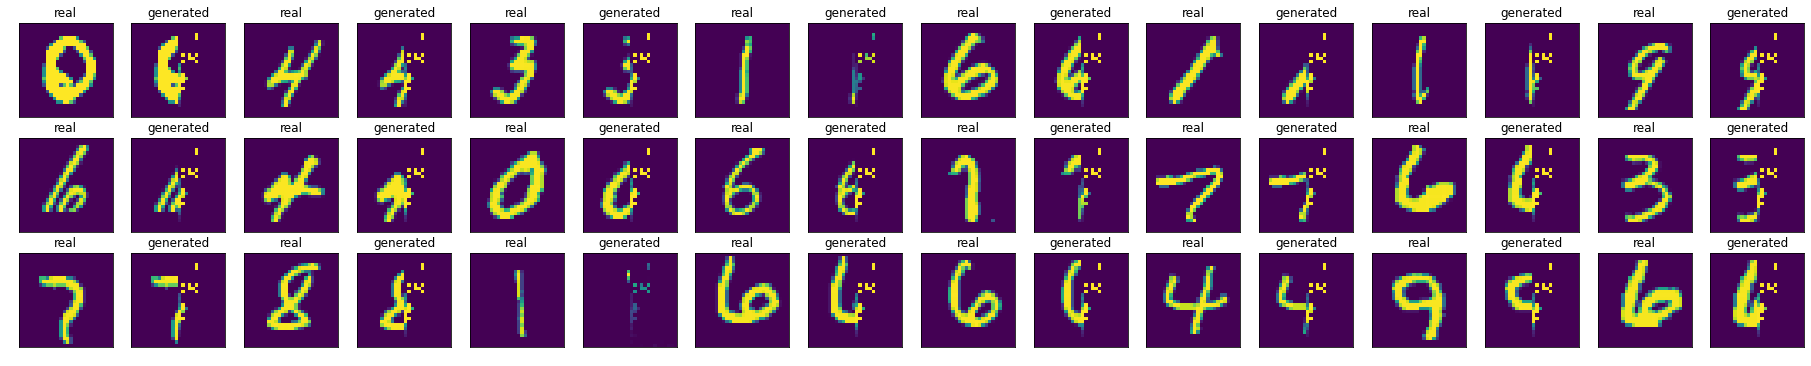

Discriminator Loss: 2.5719e+01 and generator loss is: 3.1657e+01
Epoch 85 ended in 6.11 secs.


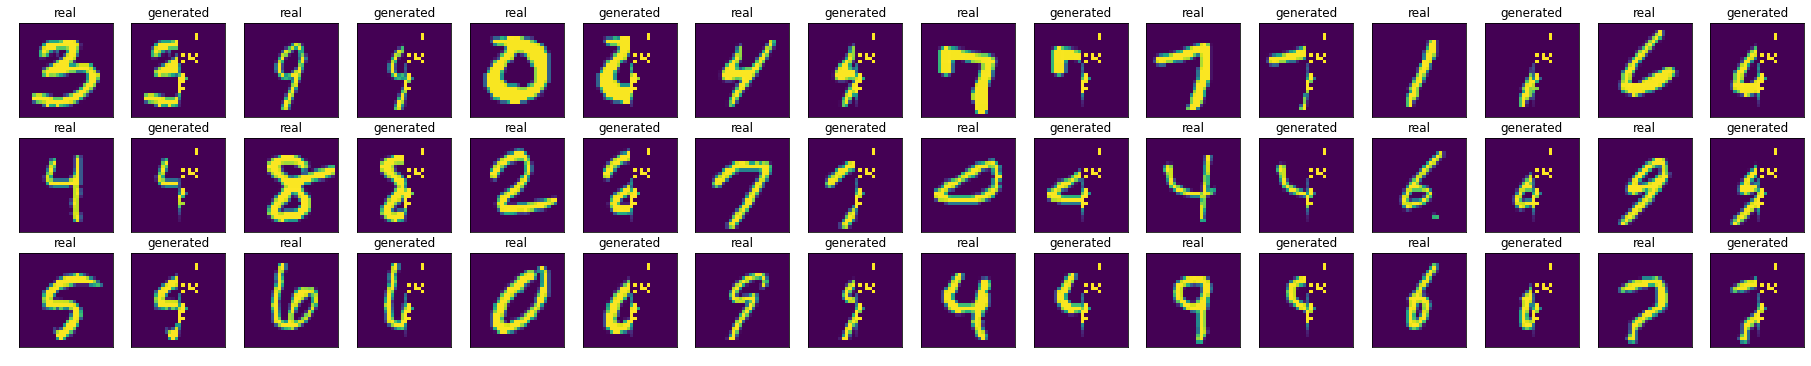

Discriminator Loss: 2.5635e+01 and generator loss is: 3.1788e+01
Epoch 86 ended in 6.09 secs.


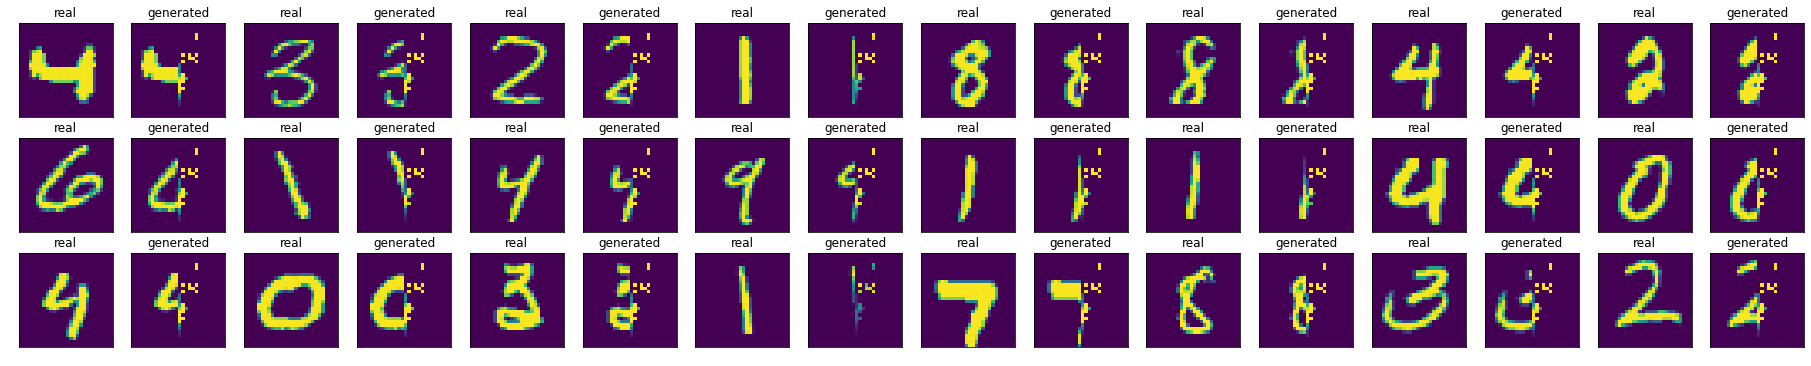

Discriminator Loss: 2.5536e+01 and generator loss is: 3.1892e+01
Epoch 87 ended in 6.10 secs.


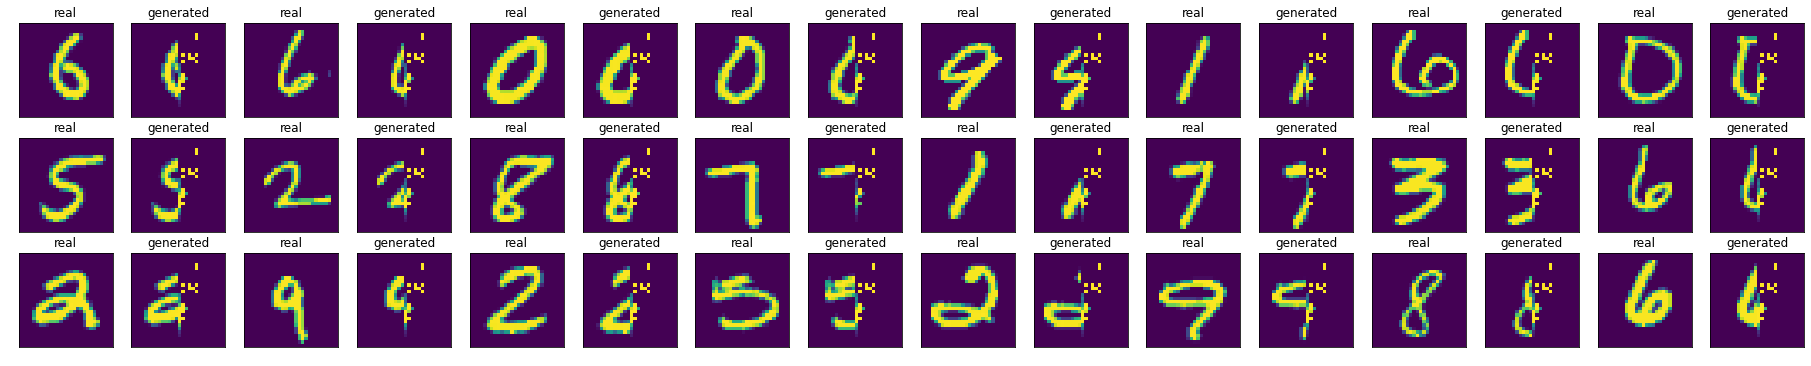

Discriminator Loss: 2.5437e+01 and generator loss is: 3.1840e+01
Epoch 88 ended in 6.09 secs.


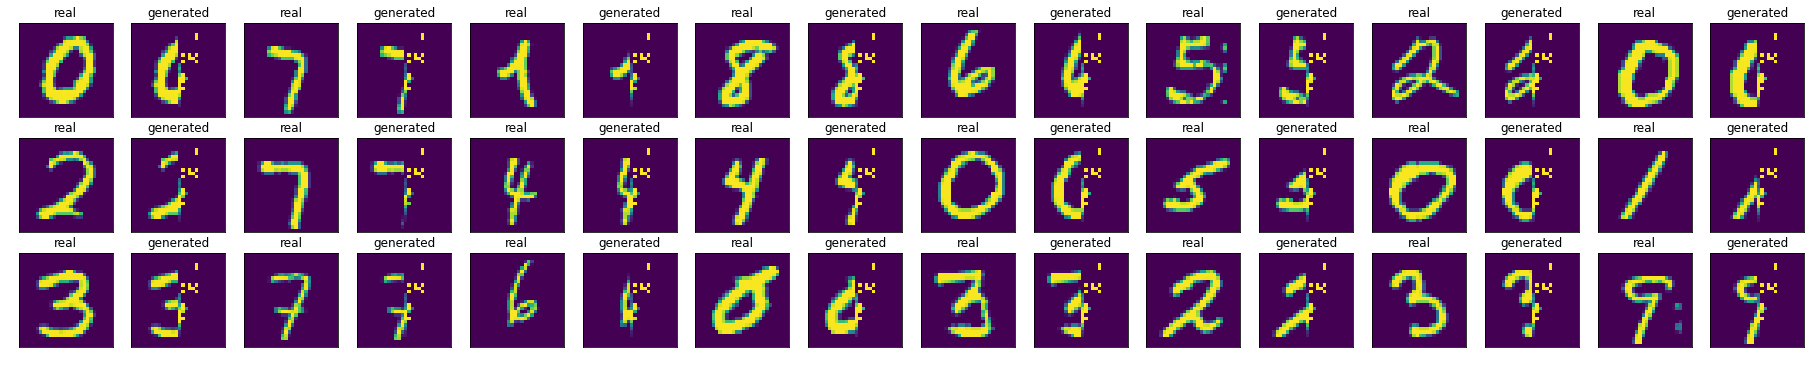

Discriminator Loss: 2.5297e+01 and generator loss is: 3.1826e+01
Epoch 89 ended in 6.10 secs.


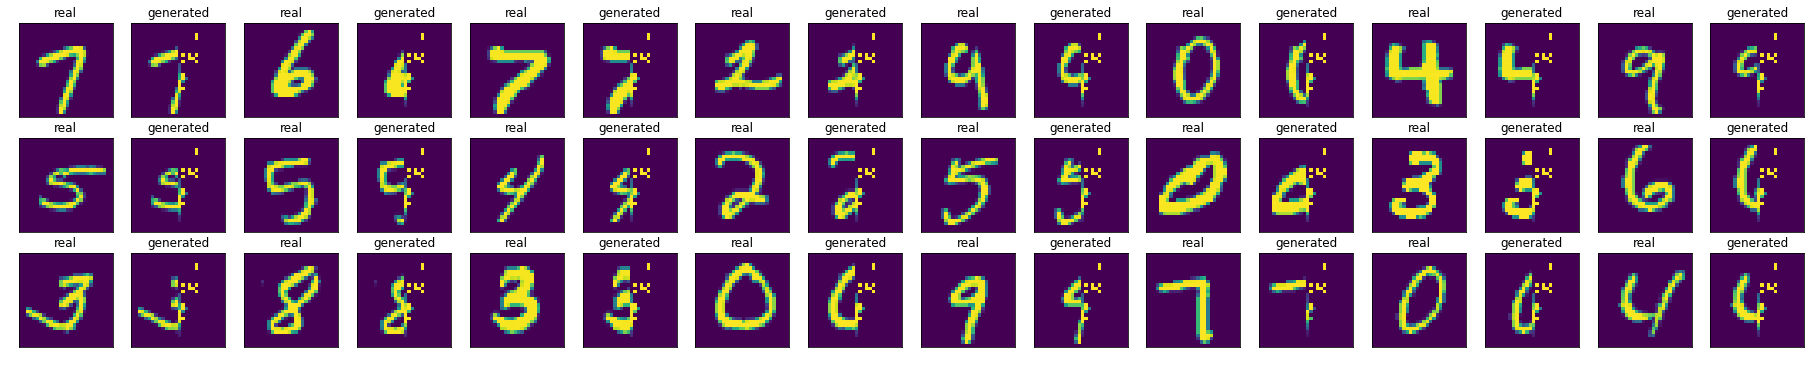

Discriminator Loss: 2.5245e+01 and generator loss is: 3.1868e+01
Epoch 90 ended in 6.11 secs.


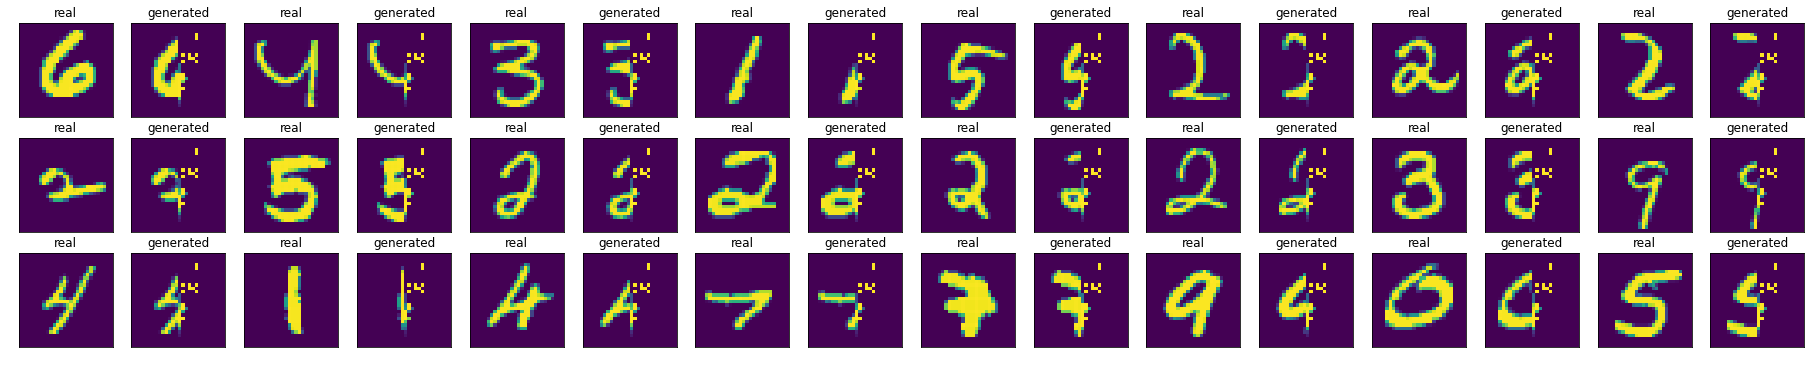

Discriminator Loss: 2.5164e+01 and generator loss is: 3.1935e+01
Epoch 91 ended in 6.10 secs.


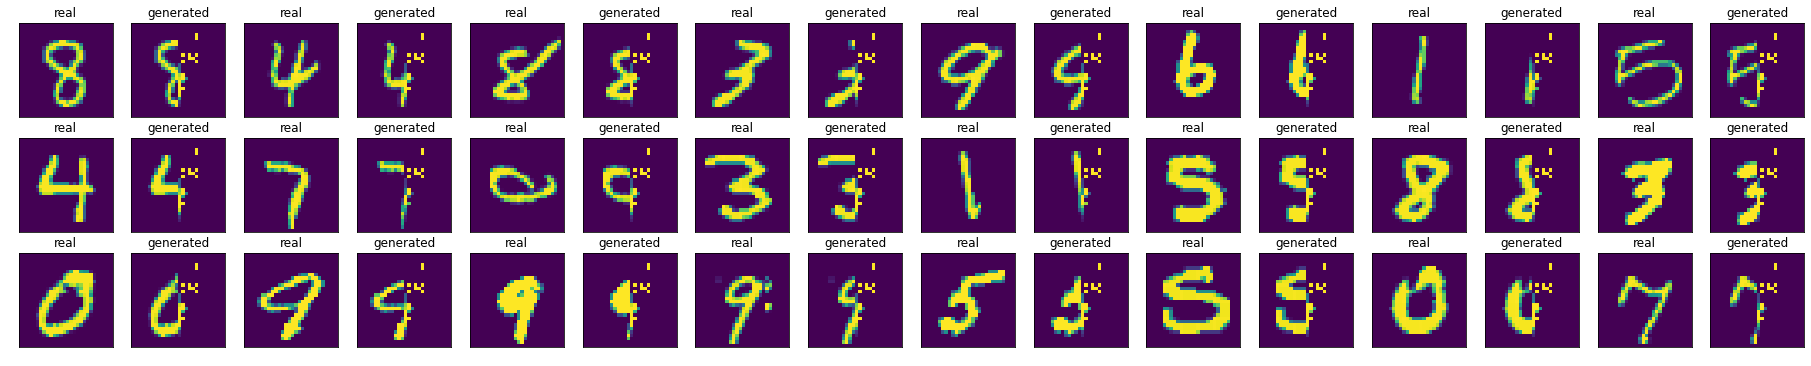

Discriminator Loss: 2.5179e+01 and generator loss is: 3.1771e+01
Epoch 92 ended in 6.10 secs.


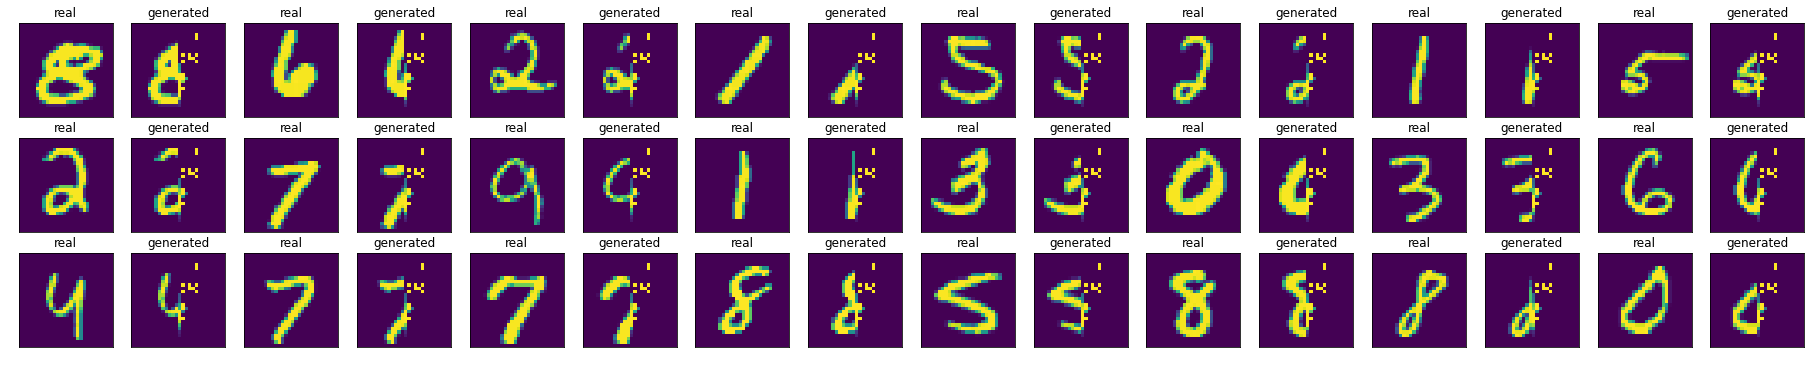

Discriminator Loss: 2.5083e+01 and generator loss is: 3.1938e+01
Epoch 93 ended in 6.10 secs.


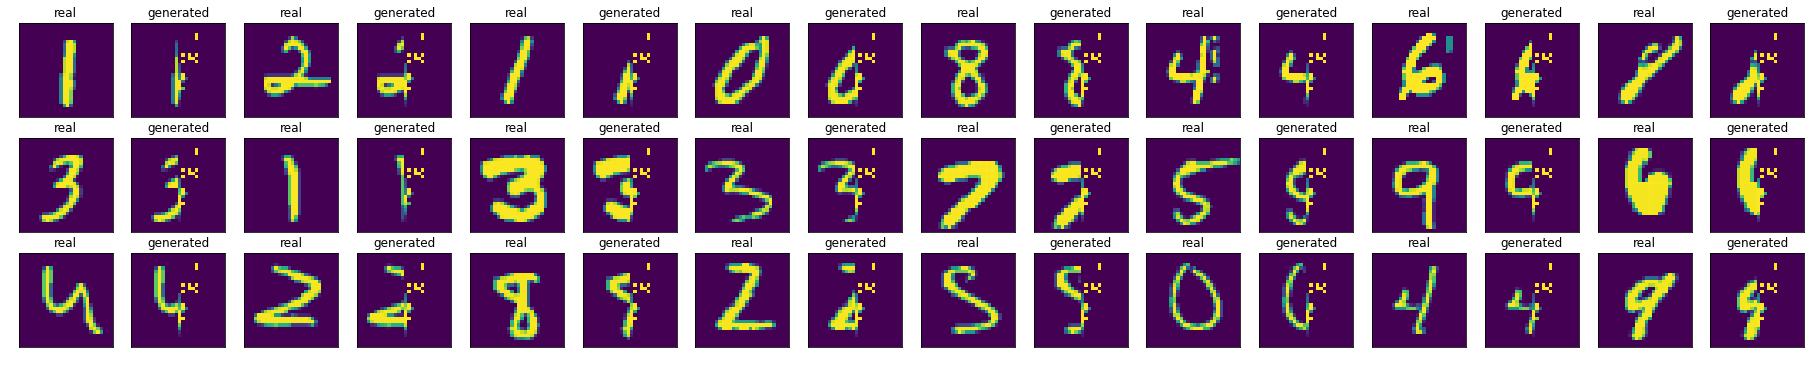

Discriminator Loss: 2.4911e+01 and generator loss is: 3.2016e+01
Epoch 94 ended in 6.09 secs.


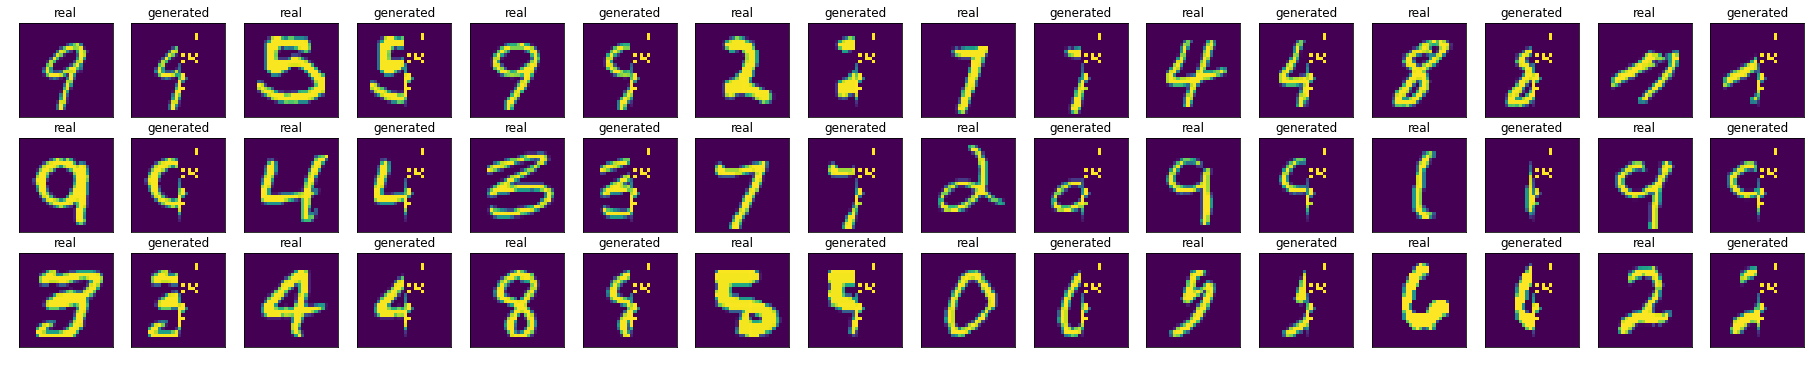

Discriminator Loss: 2.4822e+01 and generator loss is: 3.1950e+01
Epoch 95 ended in 6.10 secs.


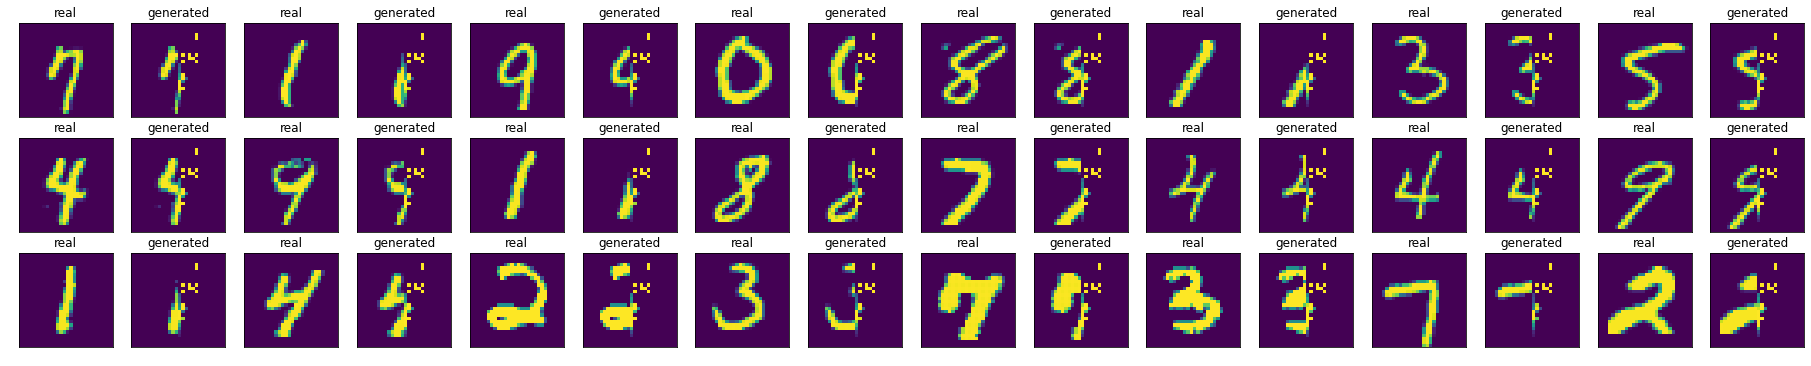

Discriminator Loss: 2.4725e+01 and generator loss is: 3.1944e+01
Epoch 96 ended in 6.10 secs.


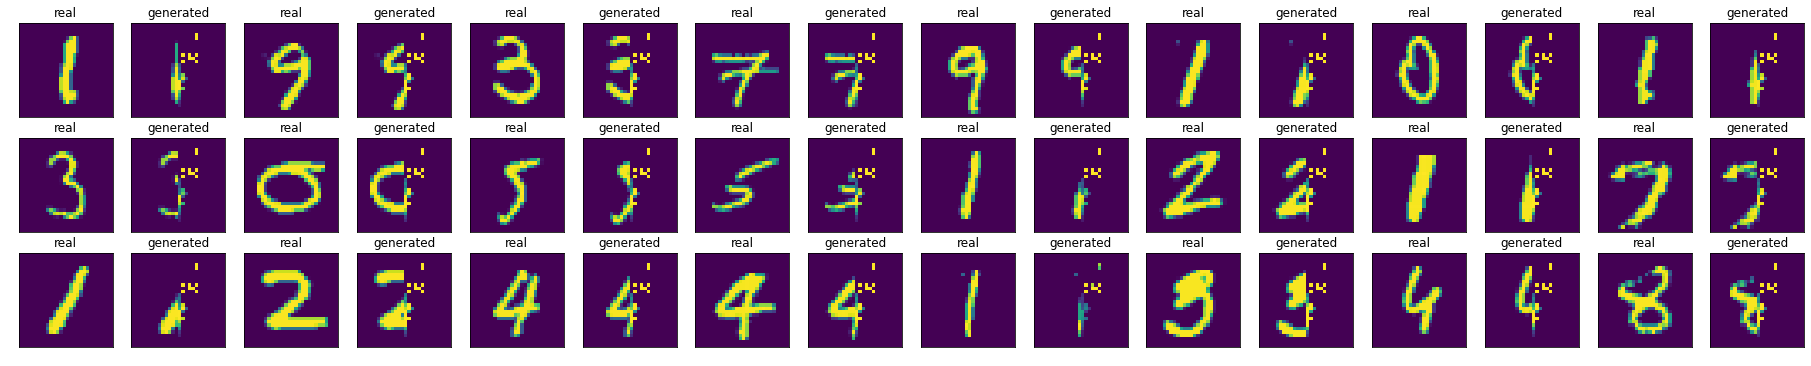

Discriminator Loss: 2.5358e+01 and generator loss is: 3.1490e+01
Epoch 97 ended in 6.10 secs.


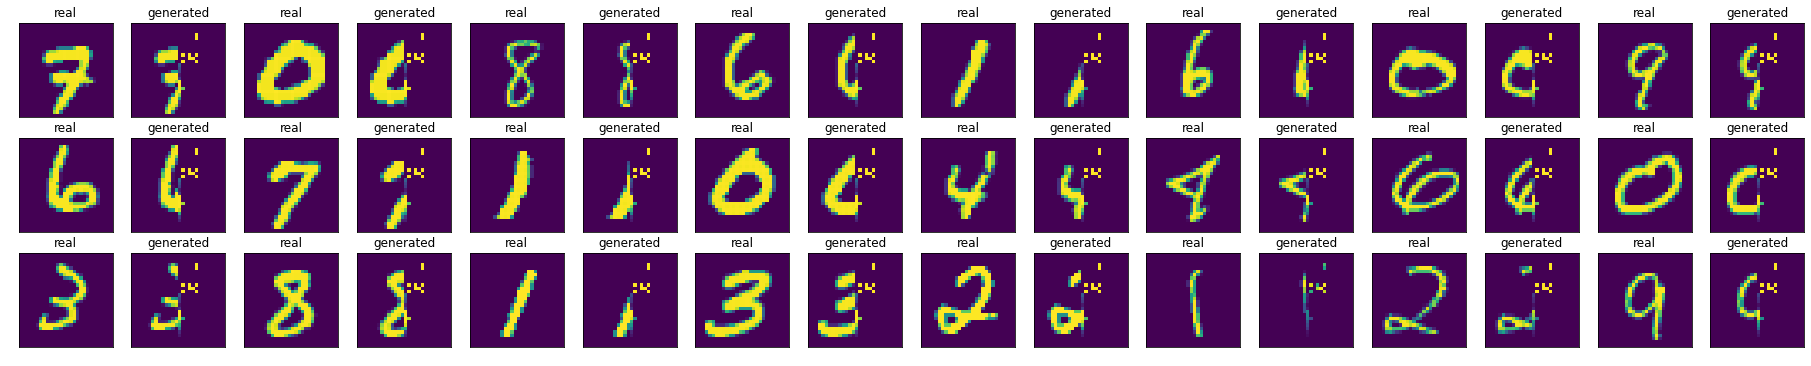

Discriminator Loss: 2.5379e+01 and generator loss is: 3.1578e+01
Epoch 98 ended in 6.10 secs.


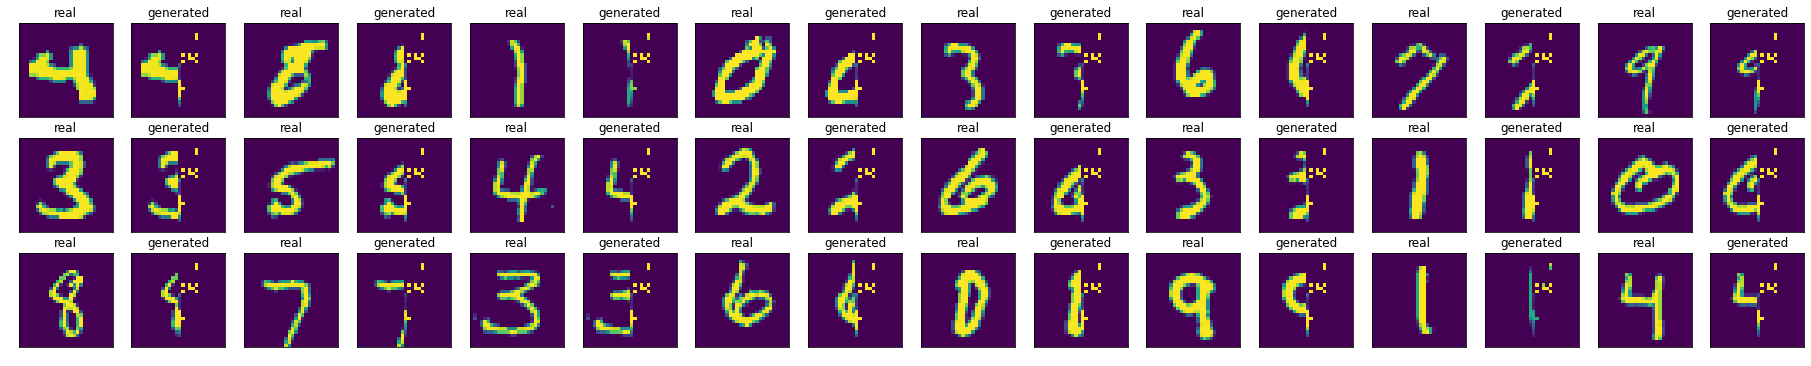

Discriminator Loss: 2.5037e+01 and generator loss is: 3.1891e+01
Epoch 99 ended in 6.10 secs.


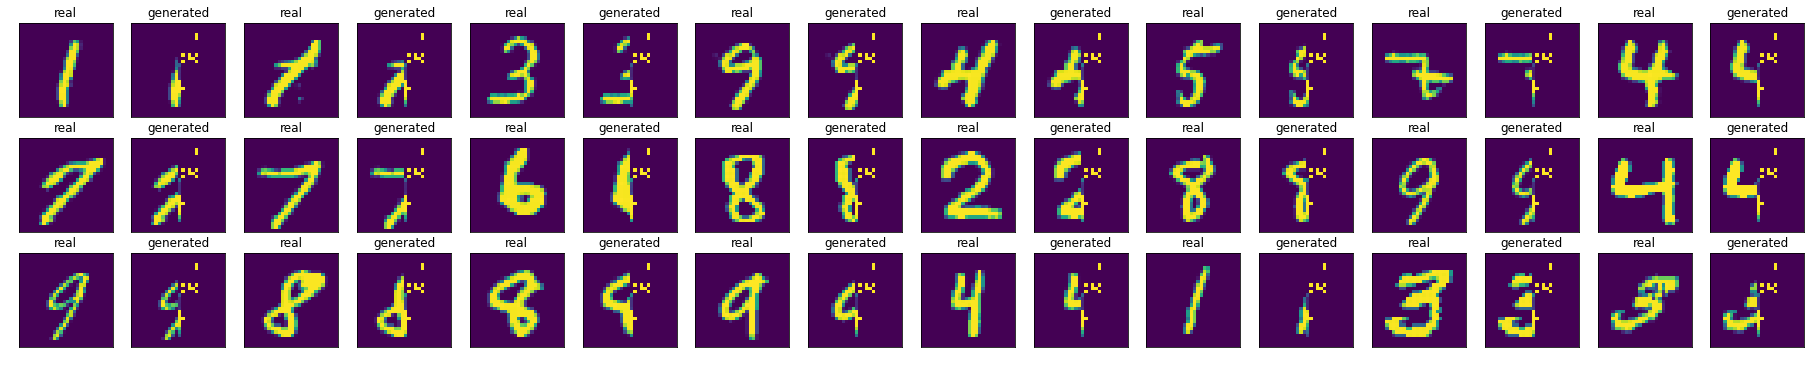

Discriminator Loss: 2.4971e+01 and generator loss is: 3.1840e+01
Epoch 100 ended in 6.09 secs.


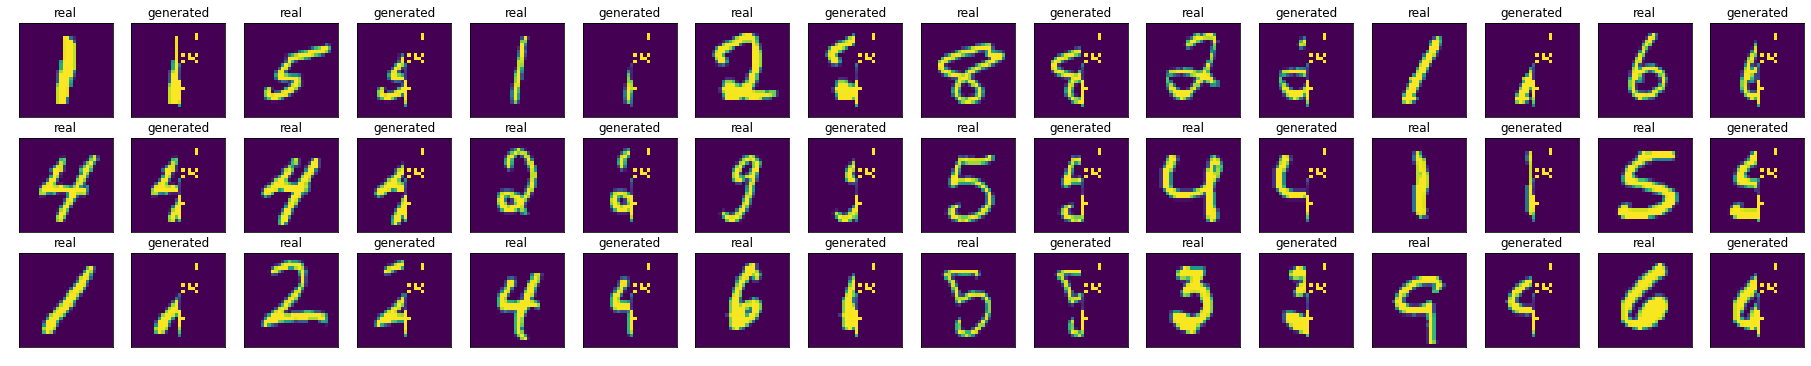

Discriminator Loss: 2.4751e+01 and generator loss is: 3.1992e+01
Epoch 101 ended in 6.11 secs.


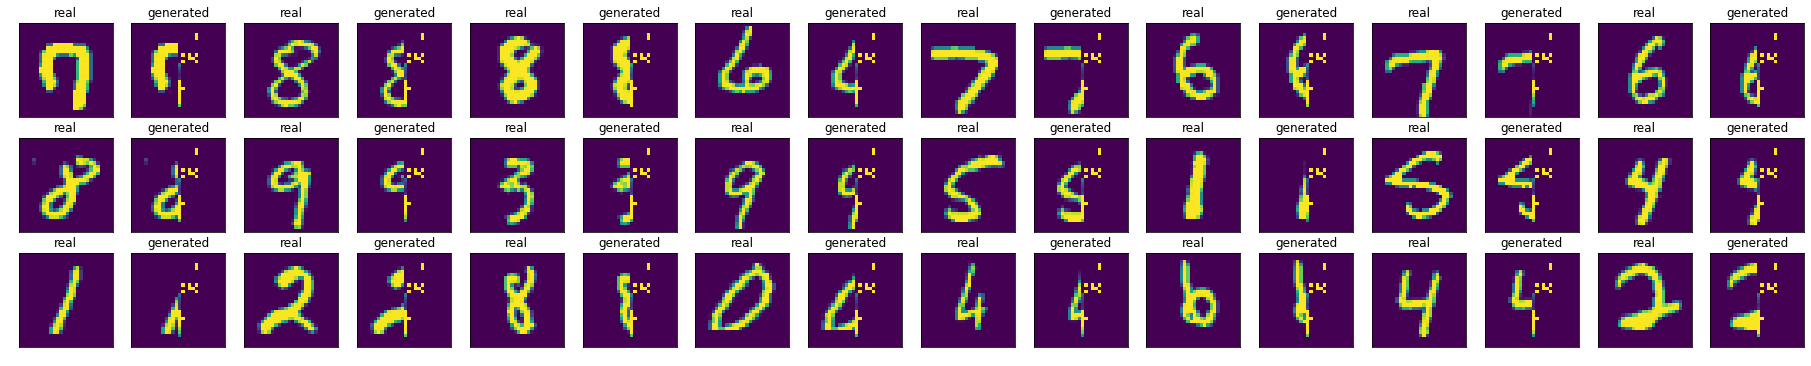

Discriminator Loss: 2.4759e+01 and generator loss is: 3.2030e+01
Epoch 102 ended in 6.10 secs.


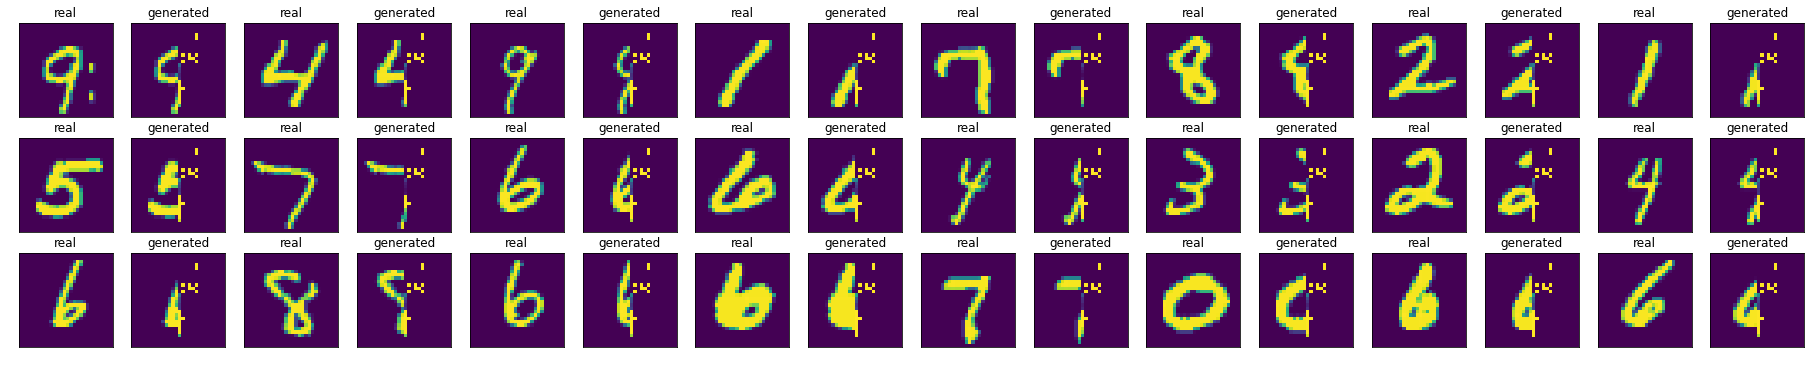

Discriminator Loss: 2.4715e+01 and generator loss is: 3.2133e+01
Epoch 103 ended in 6.09 secs.


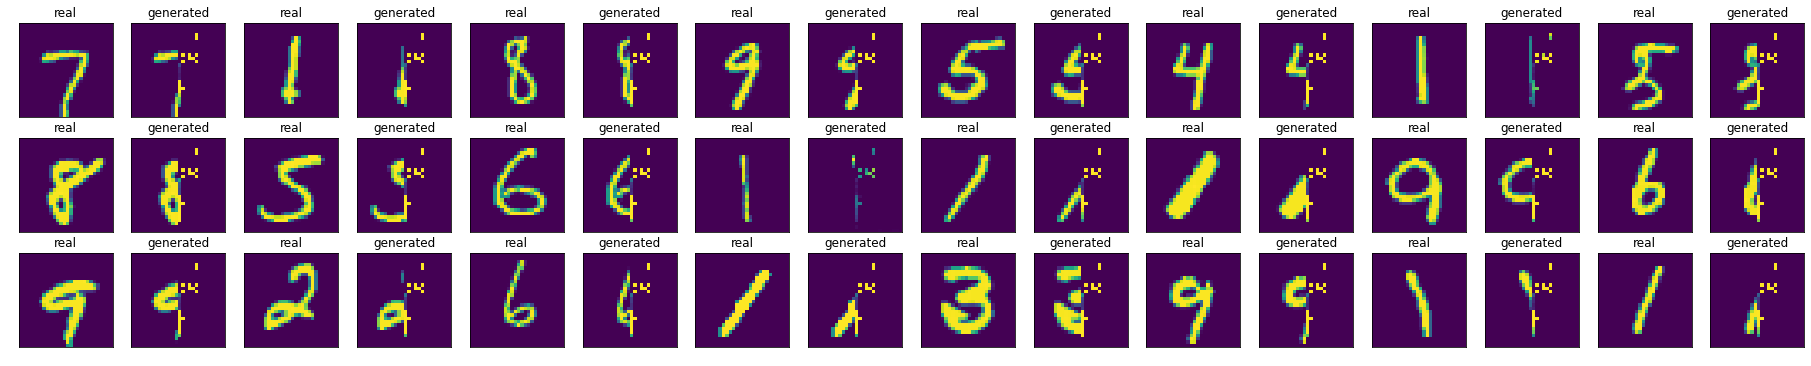

Discriminator Loss: 2.4623e+01 and generator loss is: 3.1927e+01
Epoch 104 ended in 6.10 secs.


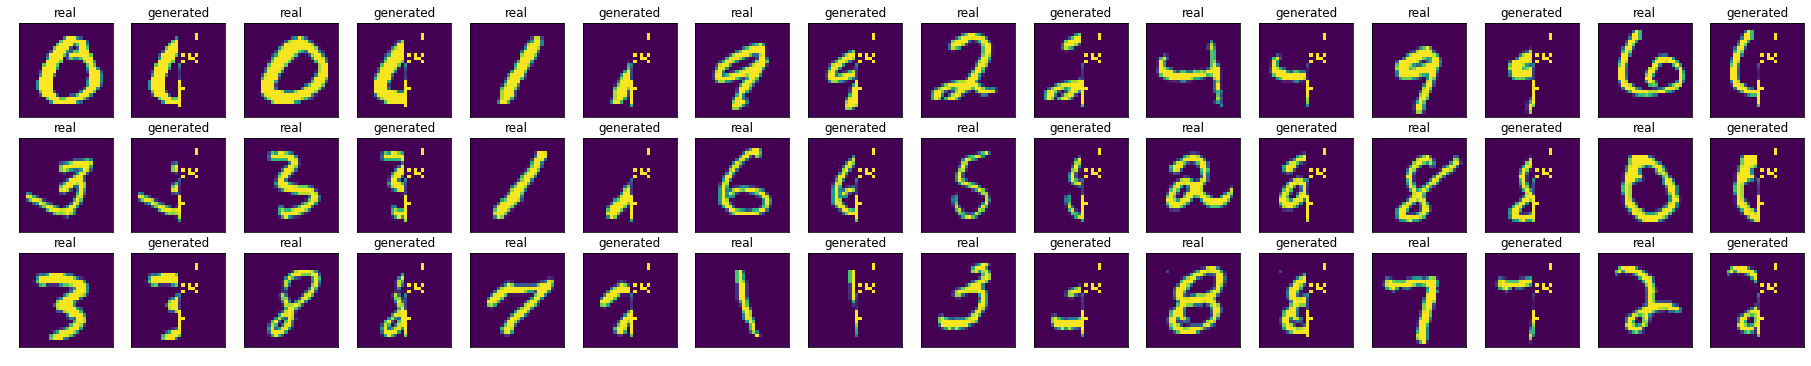

Discriminator Loss: 2.4491e+01 and generator loss is: 3.2090e+01
Epoch 105 ended in 6.10 secs.


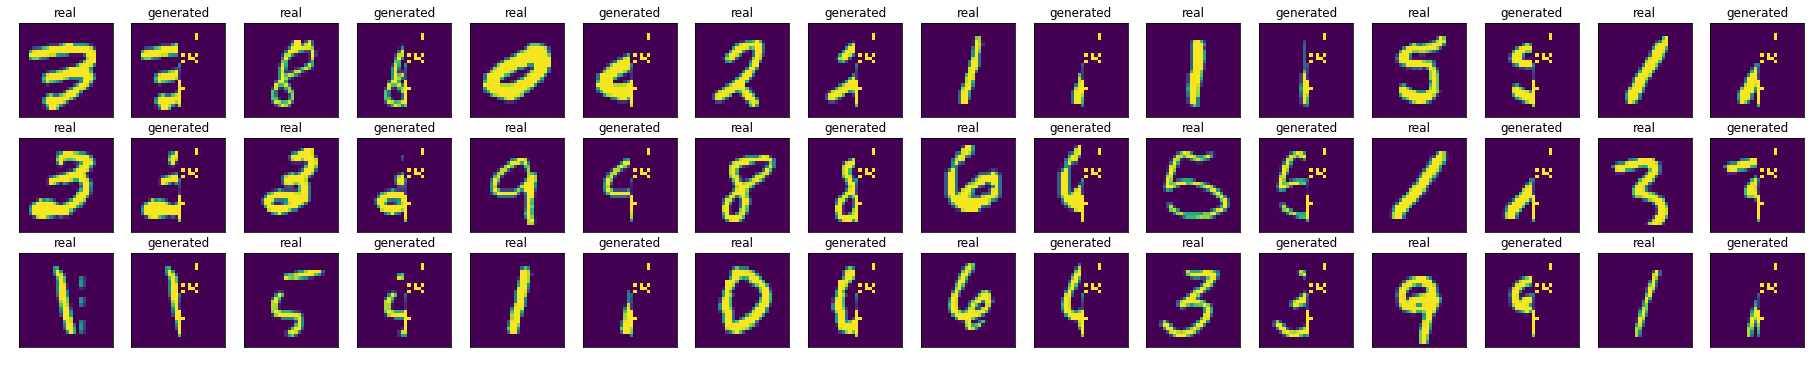

Discriminator Loss: 2.4527e+01 and generator loss is: 3.2058e+01
Epoch 106 ended in 6.09 secs.


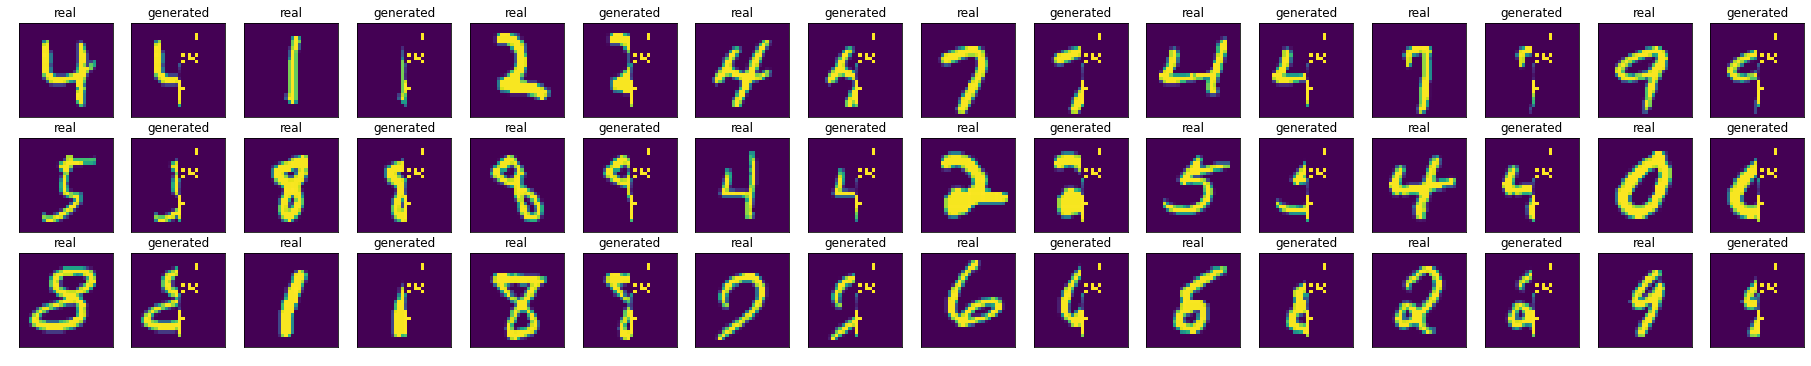

Discriminator Loss: 2.4445e+01 and generator loss is: 3.2037e+01
Epoch 107 ended in 6.09 secs.


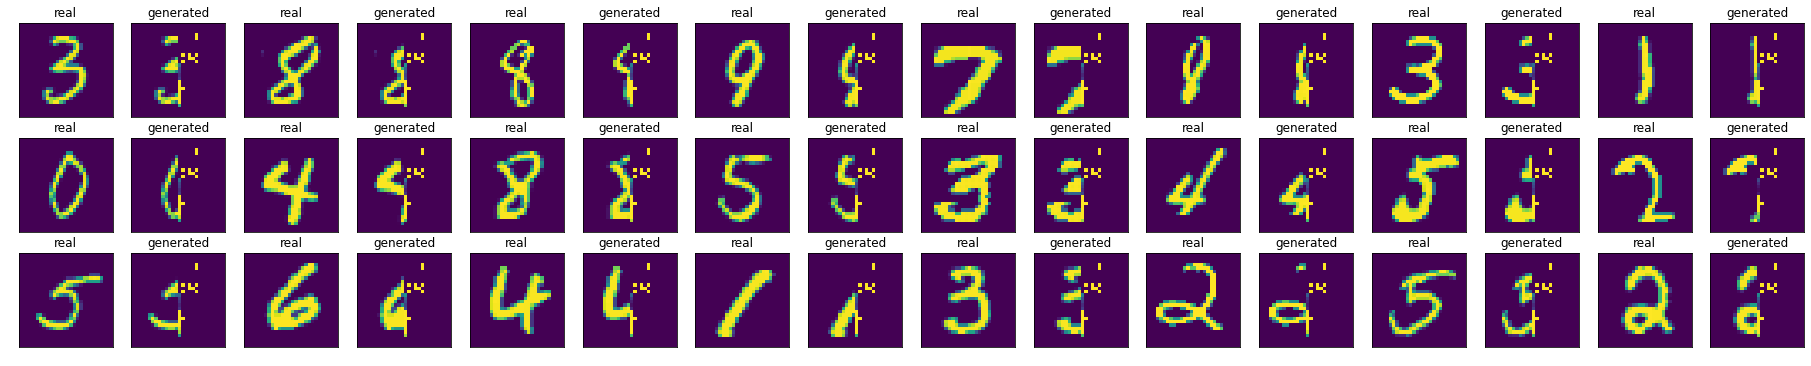

Discriminator Loss: 2.4365e+01 and generator loss is: 3.2128e+01
Epoch 108 ended in 6.10 secs.


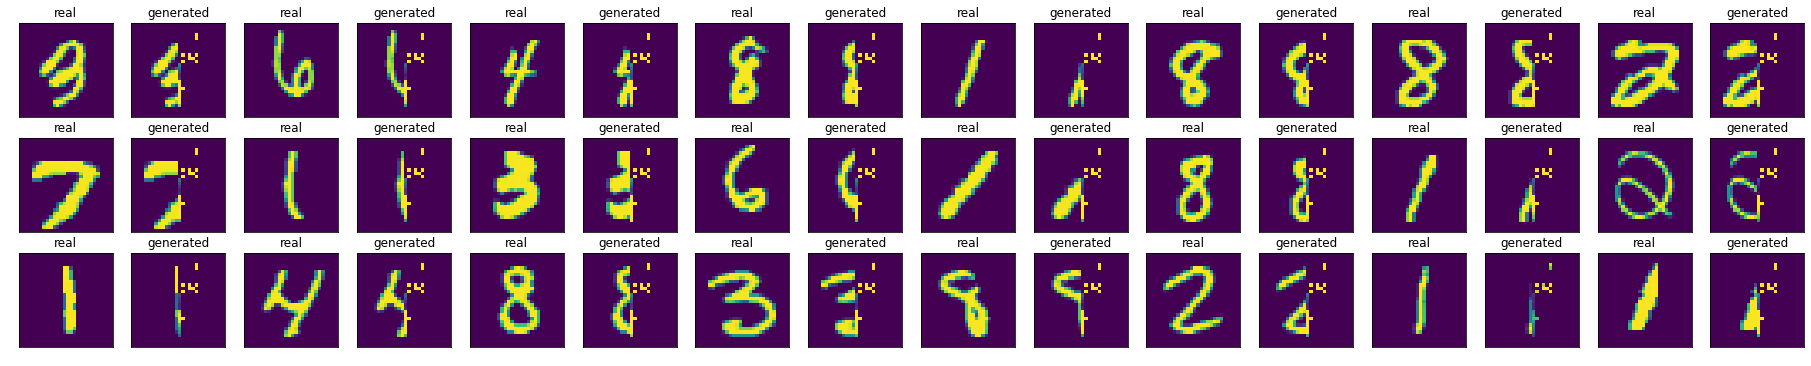

Discriminator Loss: 2.4276e+01 and generator loss is: 3.2321e+01
Epoch 109 ended in 6.10 secs.


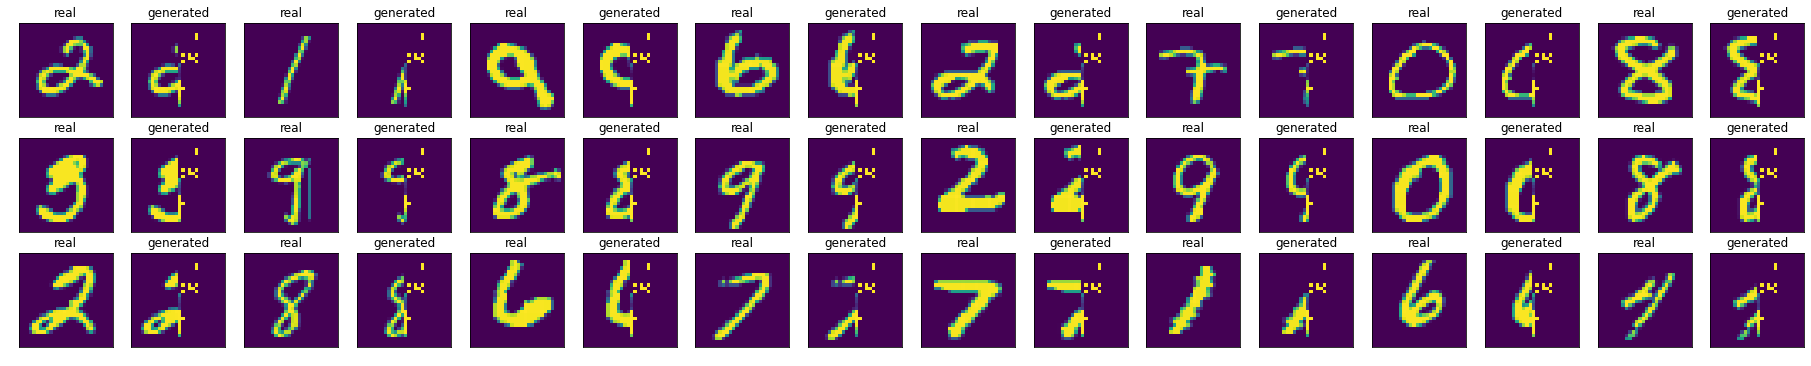

Discriminator Loss: 2.4368e+01 and generator loss is: 3.2022e+01
Epoch 110 ended in 6.10 secs.


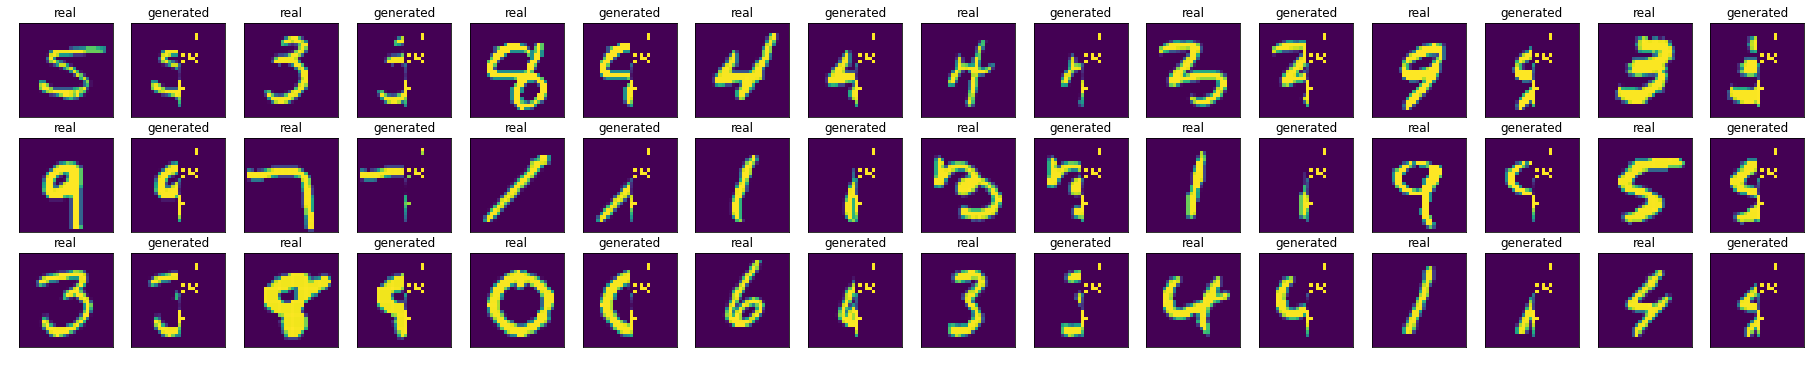

Discriminator Loss: 2.4668e+01 and generator loss is: 3.1969e+01
Epoch 111 ended in 6.11 secs.


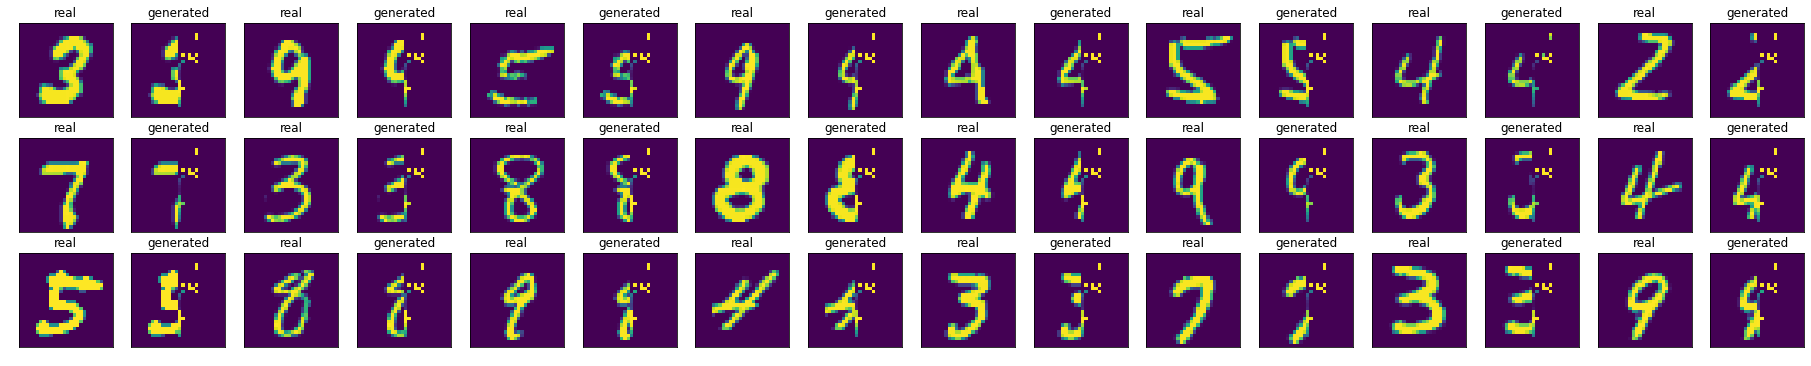

Discriminator Loss: 3.1812e+01 and generator loss is: 2.7082e+01
Epoch 112 ended in 6.10 secs.


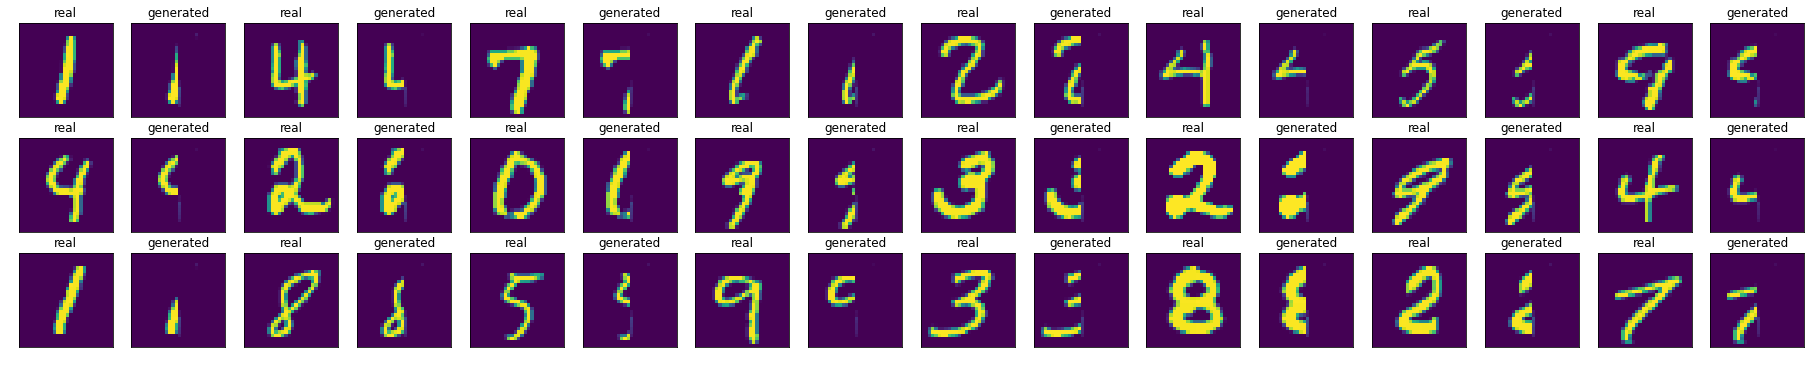

Discriminator Loss: 2.9174e+01 and generator loss is: 2.9316e+01
Epoch 113 ended in 6.11 secs.


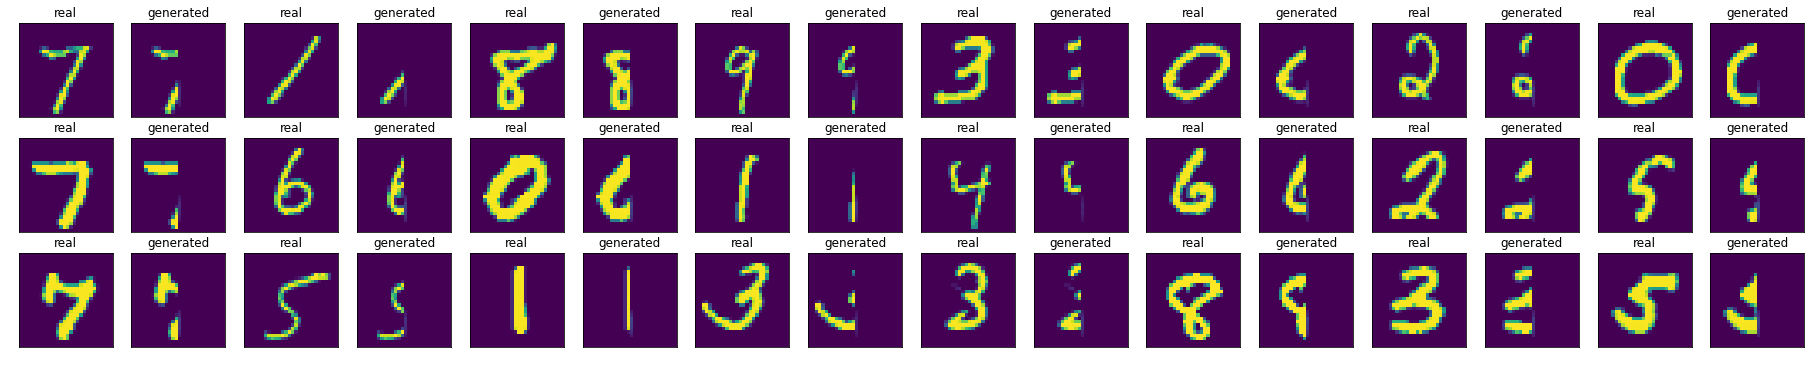

Discriminator Loss: 2.7784e+01 and generator loss is: 3.0489e+01
Epoch 114 ended in 6.10 secs.


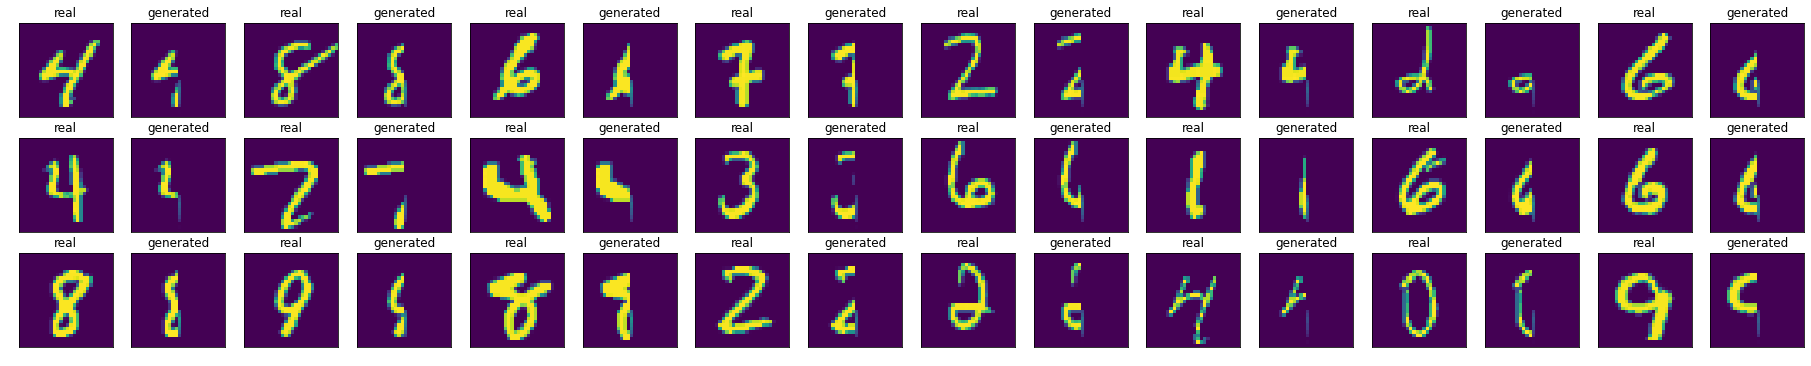

Discriminator Loss: 2.7620e+01 and generator loss is: 3.0436e+01
Epoch 115 ended in 6.09 secs.


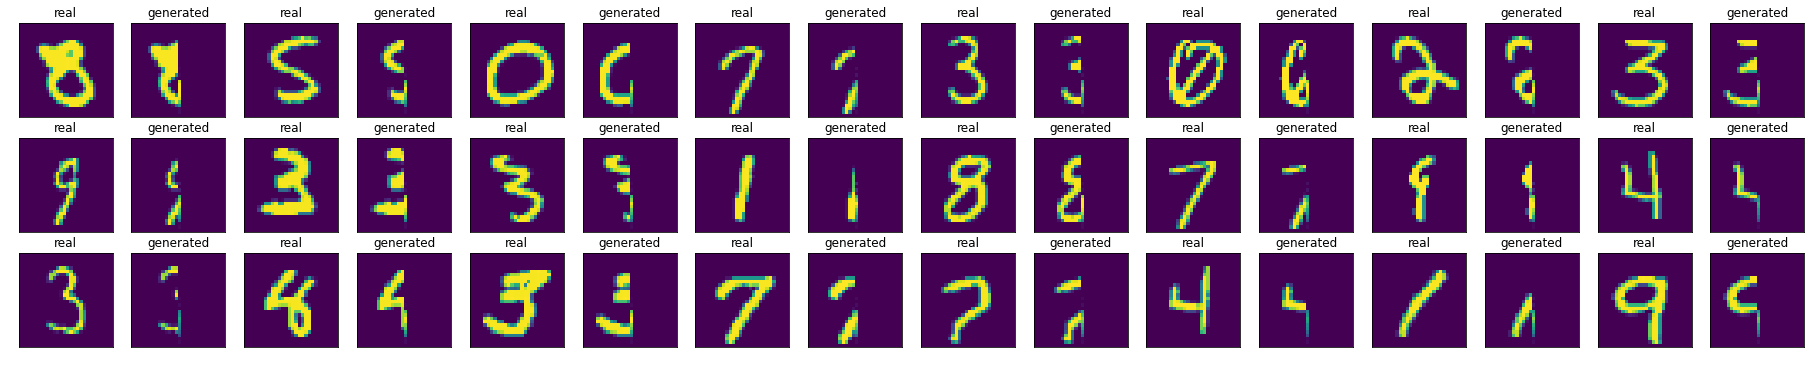

Discriminator Loss: 2.7972e+01 and generator loss is: 3.0422e+01
Epoch 116 ended in 6.10 secs.


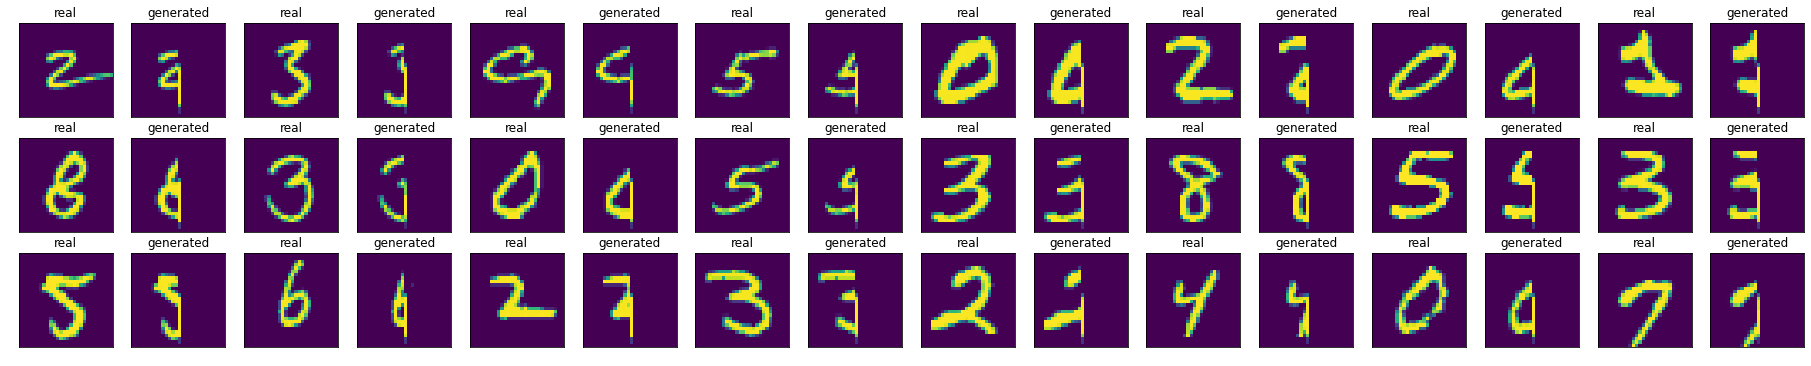

Discriminator Loss: 2.7158e+01 and generator loss is: 3.1473e+01
Epoch 117 ended in 6.10 secs.


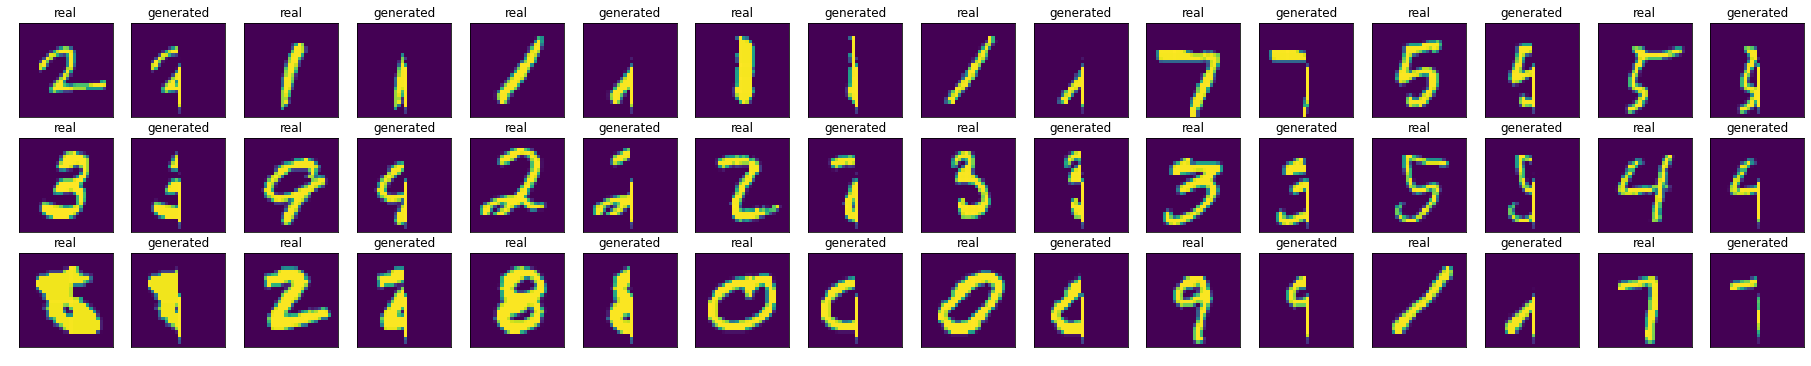

Discriminator Loss: 2.6437e+01 and generator loss is: 3.1542e+01
Epoch 118 ended in 6.09 secs.


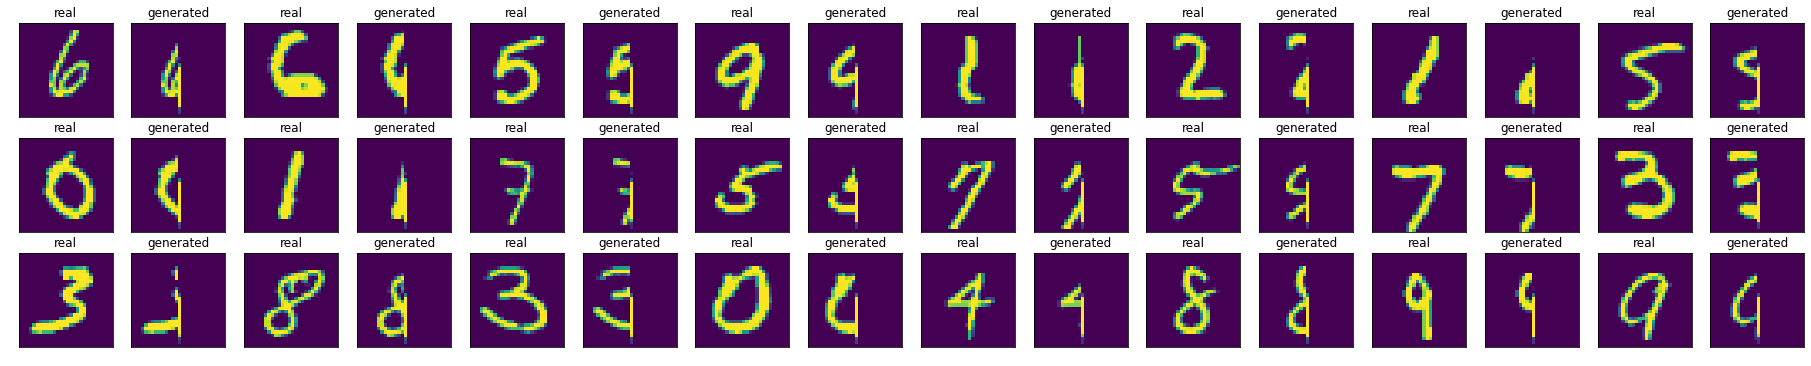

Discriminator Loss: 2.6115e+01 and generator loss is: 3.1665e+01
Epoch 119 ended in 6.10 secs.


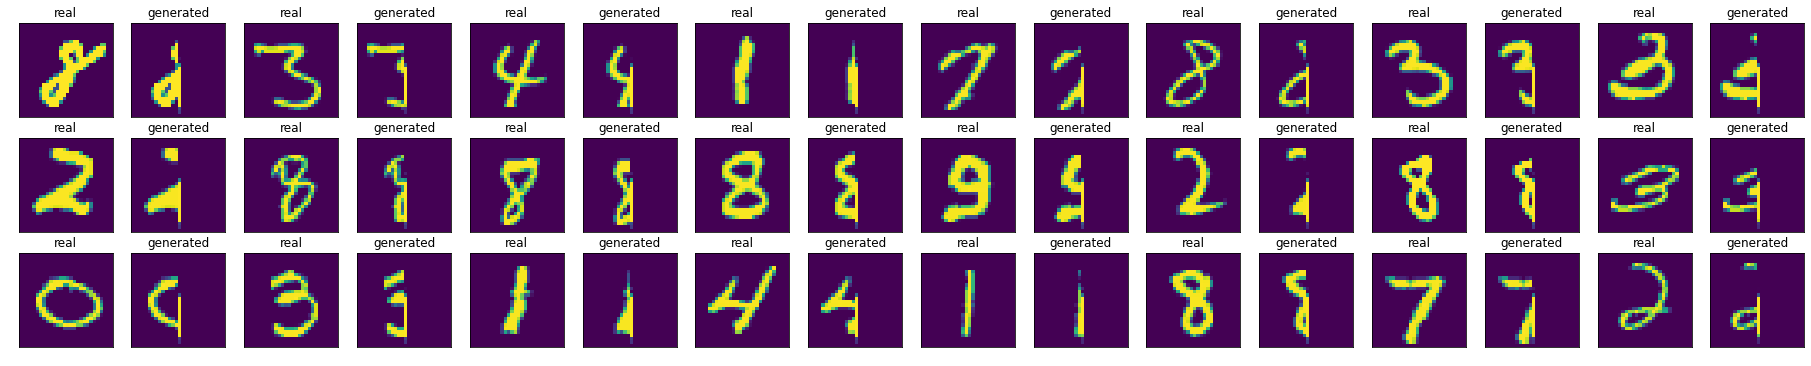

Discriminator Loss: 2.5779e+01 and generator loss is: 3.1818e+01
Epoch 120 ended in 6.09 secs.


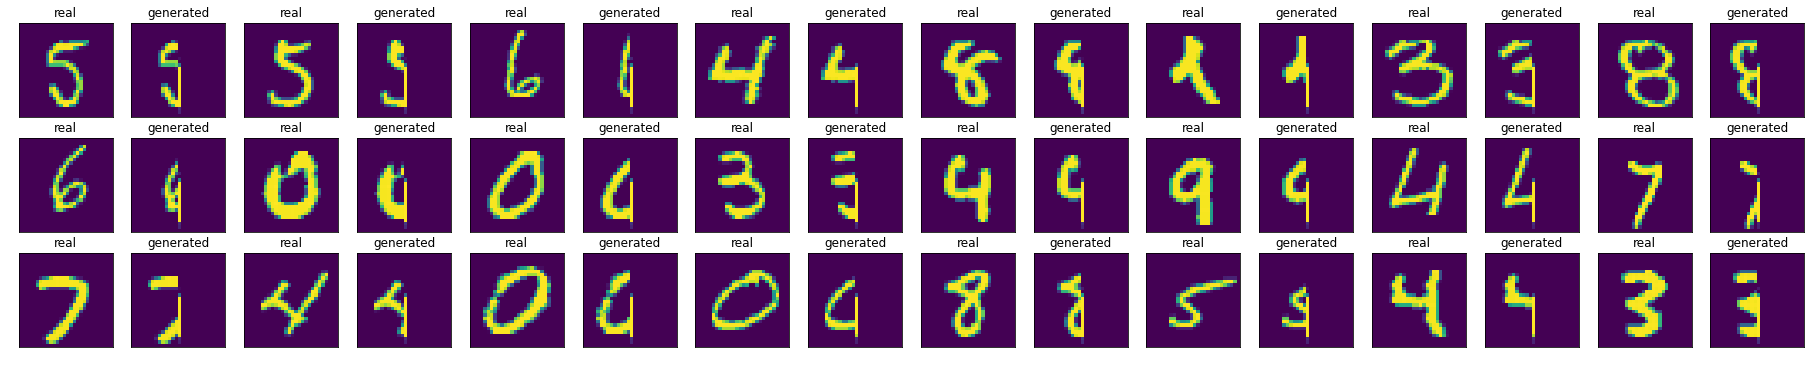

Discriminator Loss: 2.5608e+01 and generator loss is: 3.1827e+01
Epoch 121 ended in 6.10 secs.


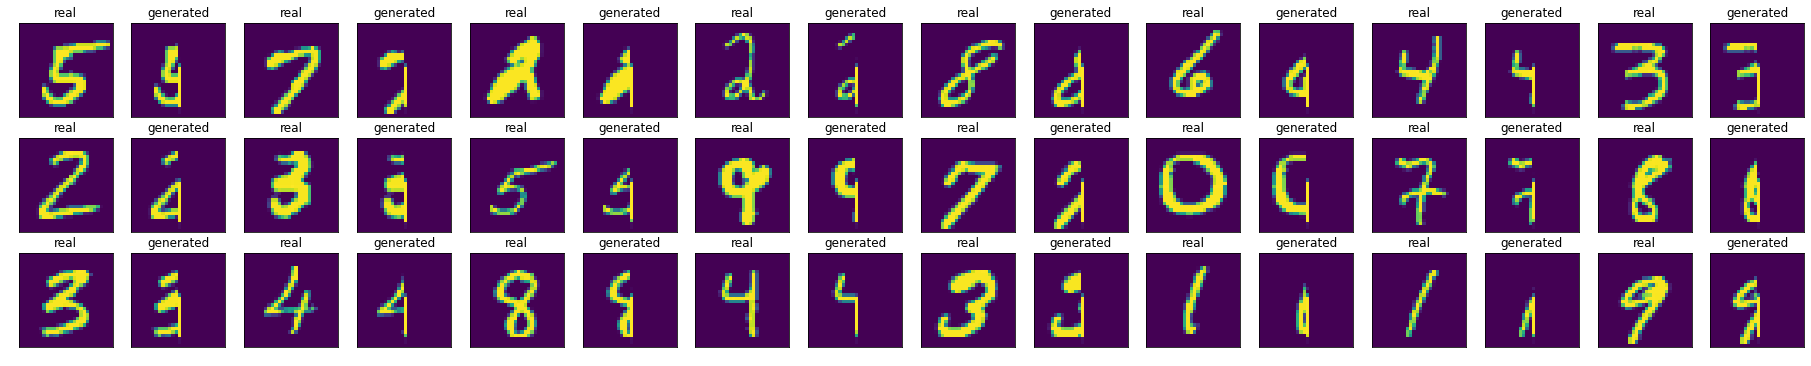

Discriminator Loss: 2.5268e+01 and generator loss is: 3.1844e+01
Epoch 122 ended in 6.09 secs.


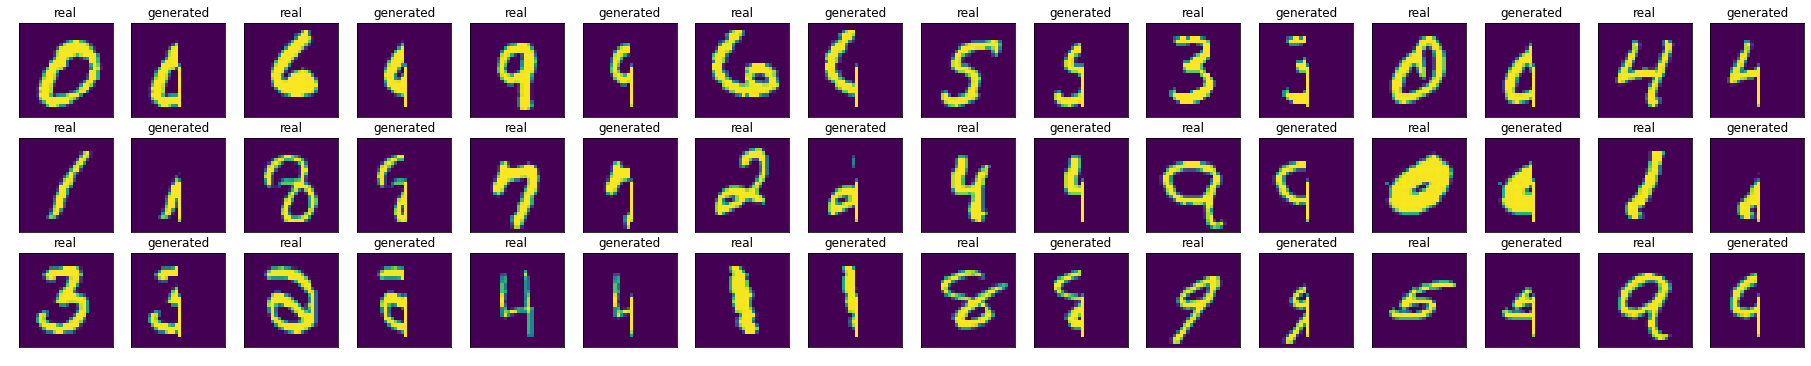

Discriminator Loss: 2.5204e+01 and generator loss is: 3.1942e+01
Epoch 123 ended in 6.11 secs.


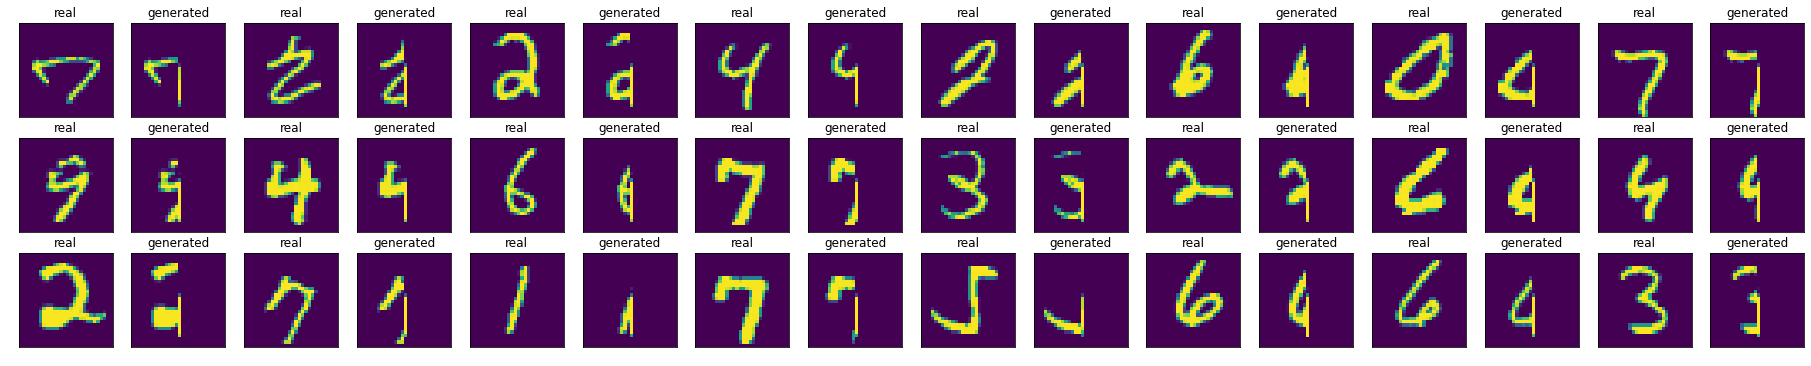

Discriminator Loss: 2.4998e+01 and generator loss is: 3.1990e+01
Epoch 124 ended in 6.11 secs.


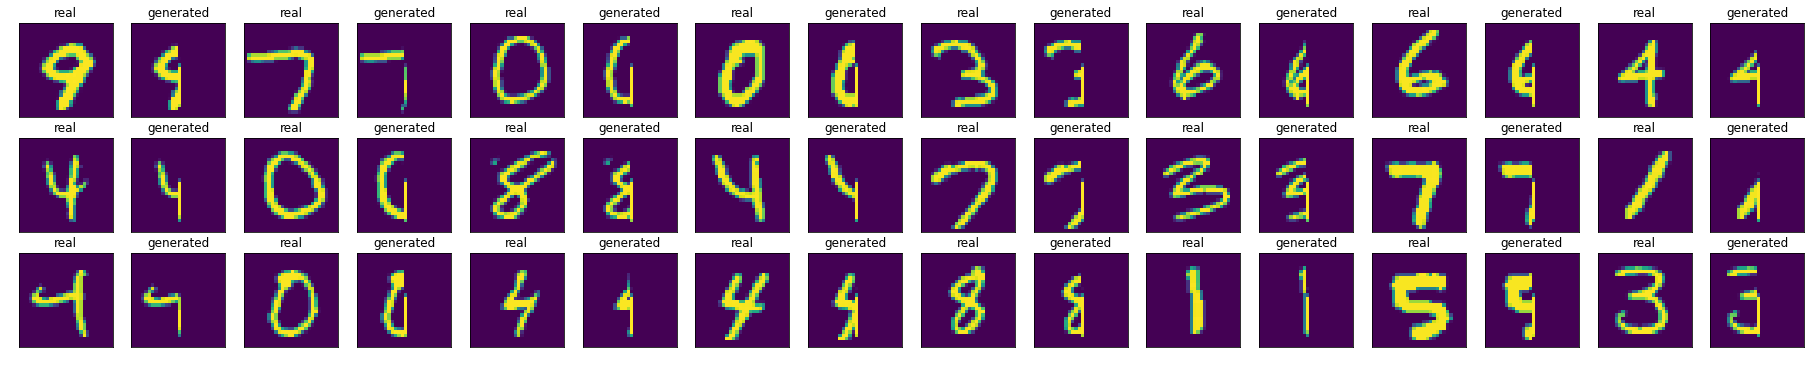

Discriminator Loss: 2.5035e+01 and generator loss is: 3.1805e+01
Epoch 125 ended in 6.11 secs.


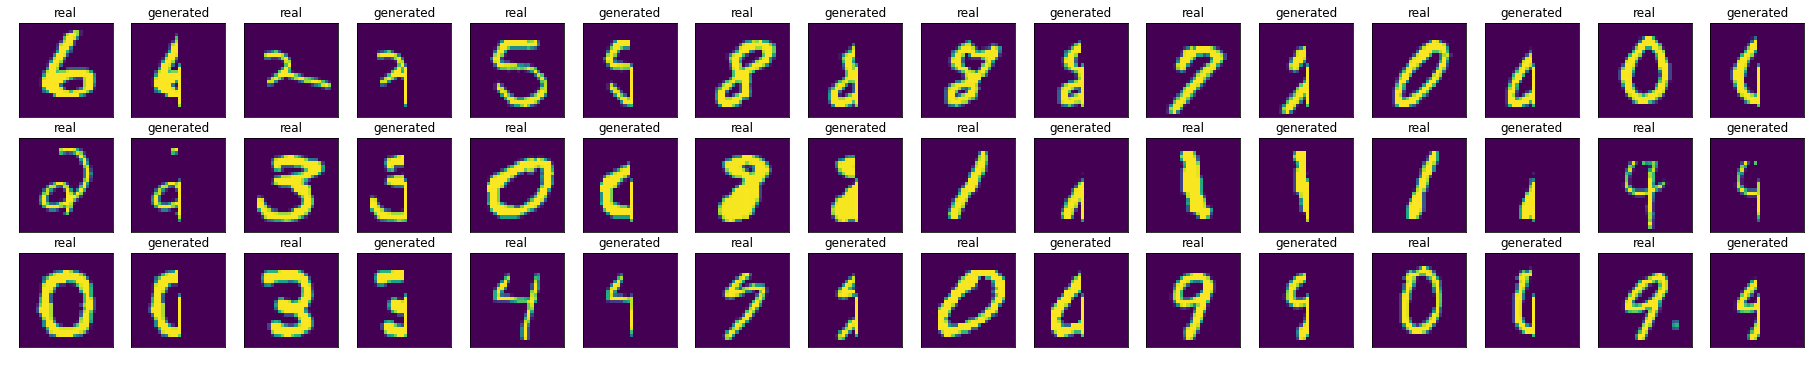

Discriminator Loss: 2.4770e+01 and generator loss is: 3.1978e+01
Epoch 126 ended in 6.10 secs.


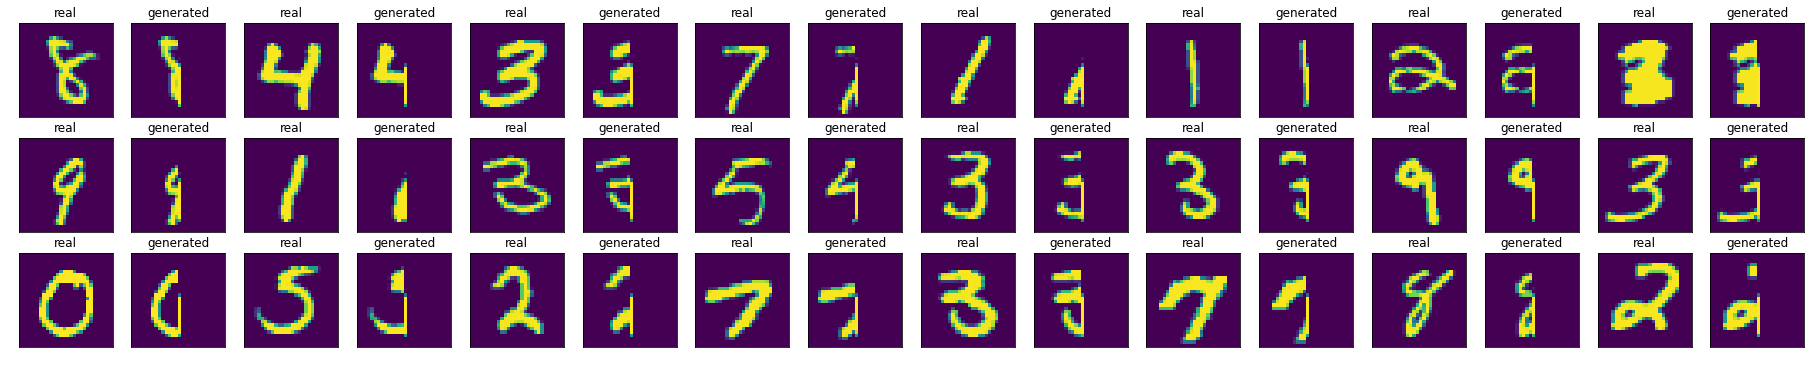

Discriminator Loss: 2.4553e+01 and generator loss is: 3.1916e+01
Epoch 127 ended in 6.09 secs.


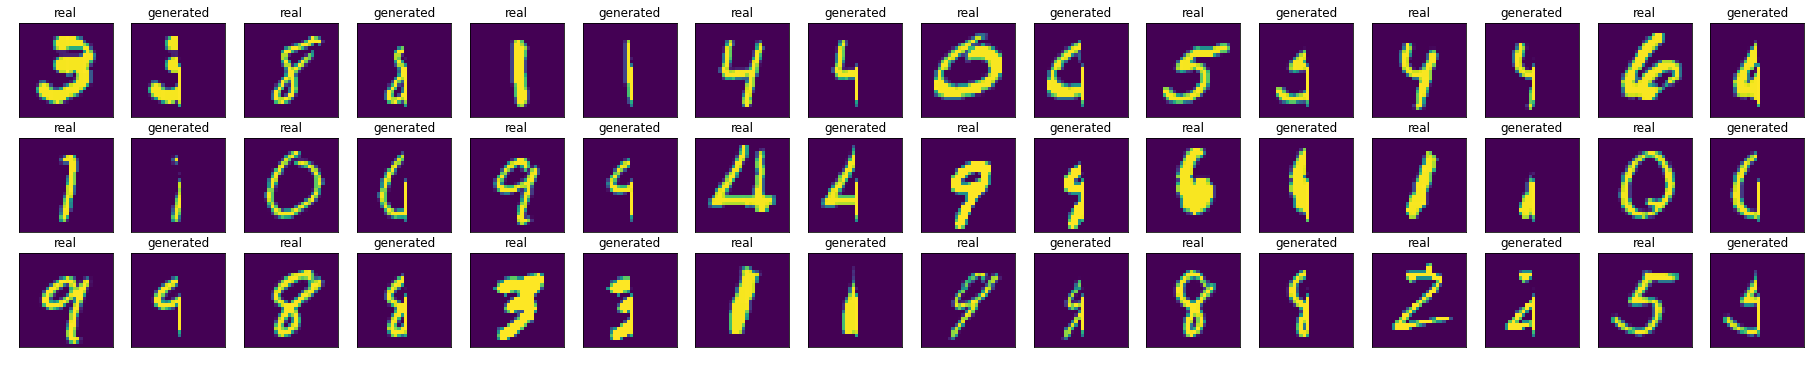

Discriminator Loss: 2.4647e+01 and generator loss is: 3.1943e+01
Epoch 128 ended in 6.09 secs.


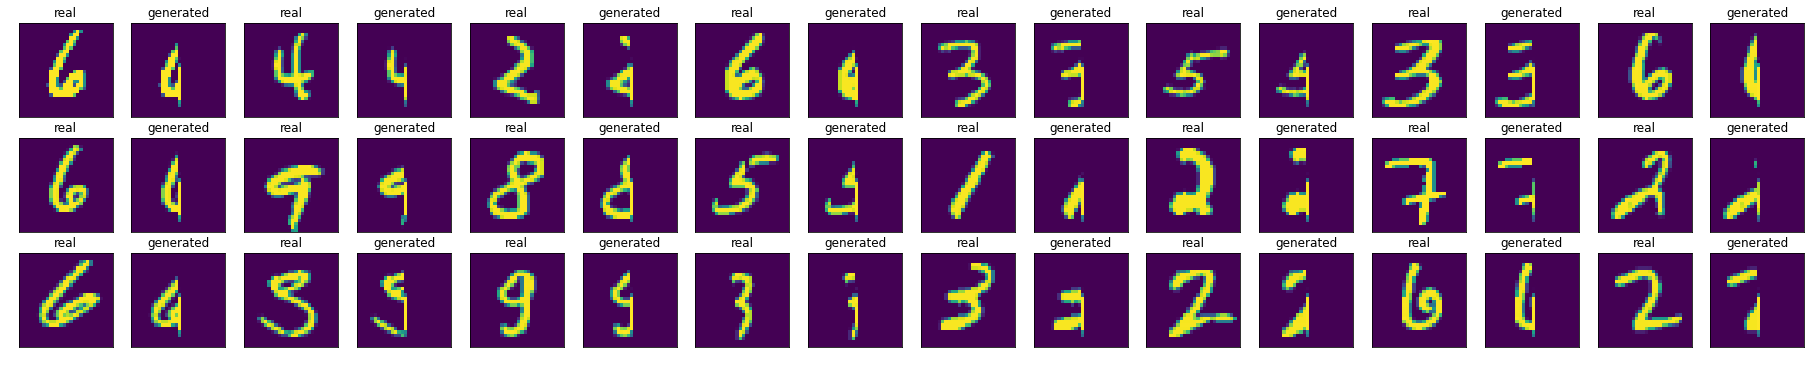

Discriminator Loss: 2.4526e+01 and generator loss is: 3.2027e+01
Epoch 129 ended in 6.08 secs.


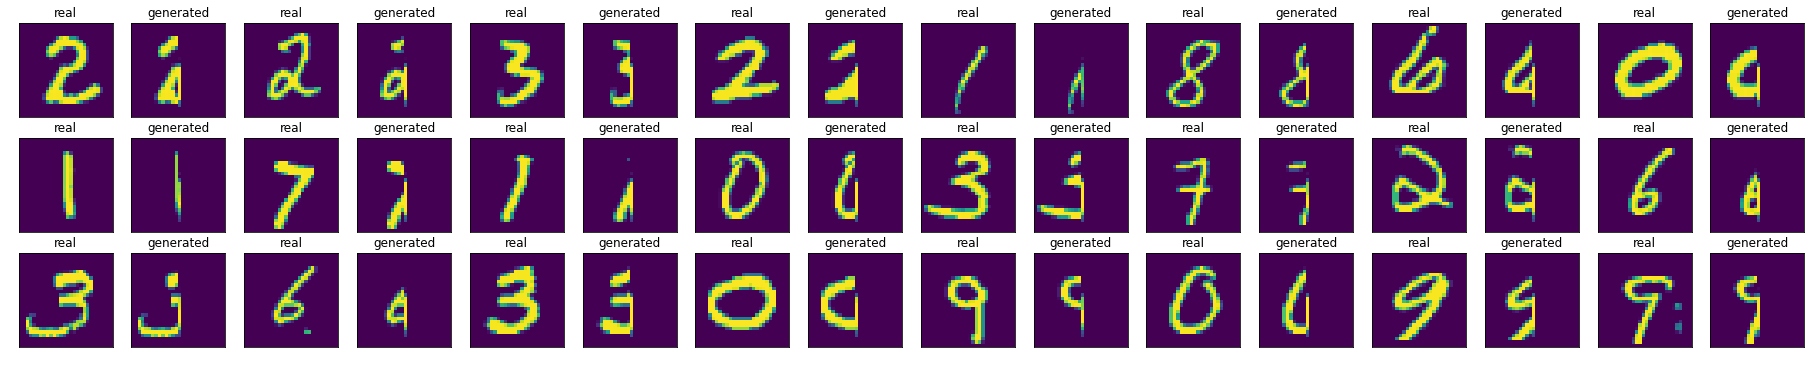

Discriminator Loss: 2.4649e+01 and generator loss is: 3.1893e+01
Epoch 130 ended in 6.10 secs.


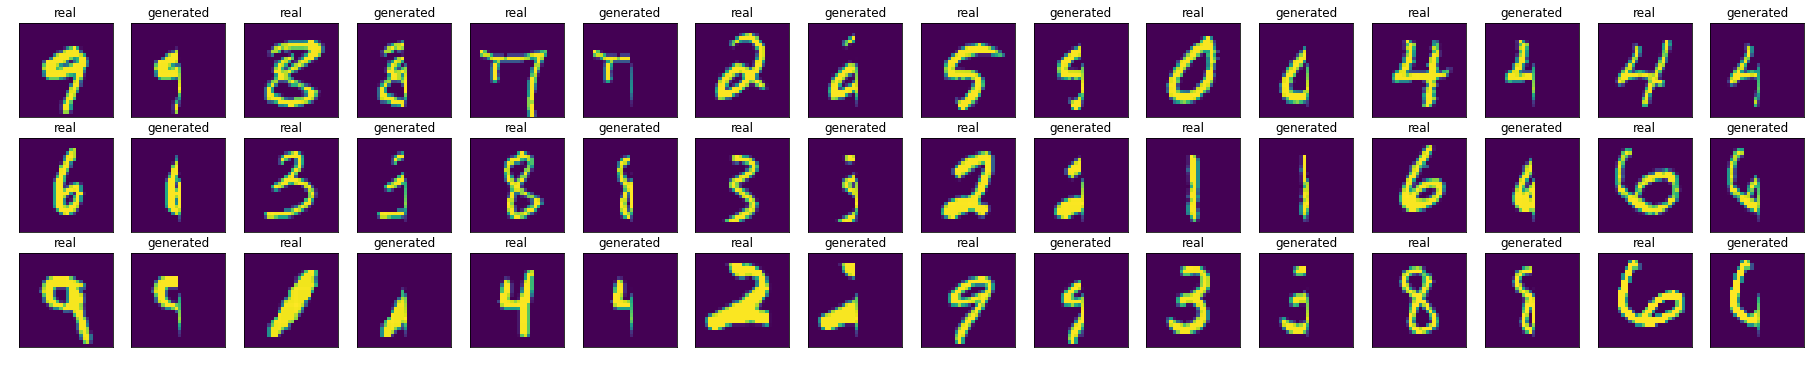

Discriminator Loss: 2.4477e+01 and generator loss is: 3.1751e+01
Epoch 131 ended in 6.10 secs.


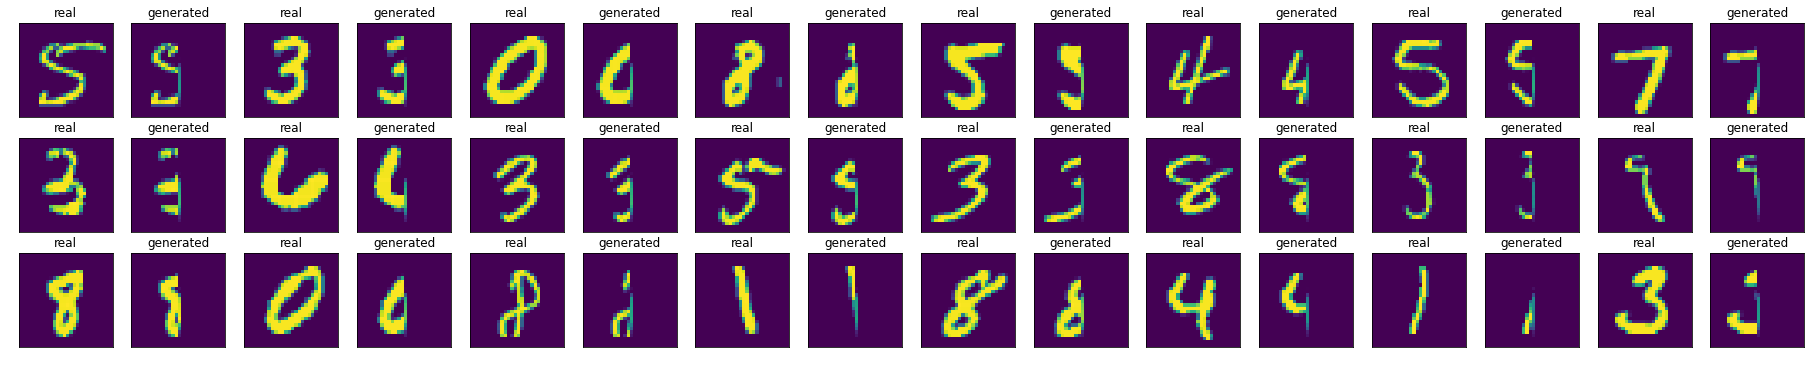

Discriminator Loss: 2.4436e+01 and generator loss is: 3.1904e+01
Epoch 132 ended in 6.11 secs.


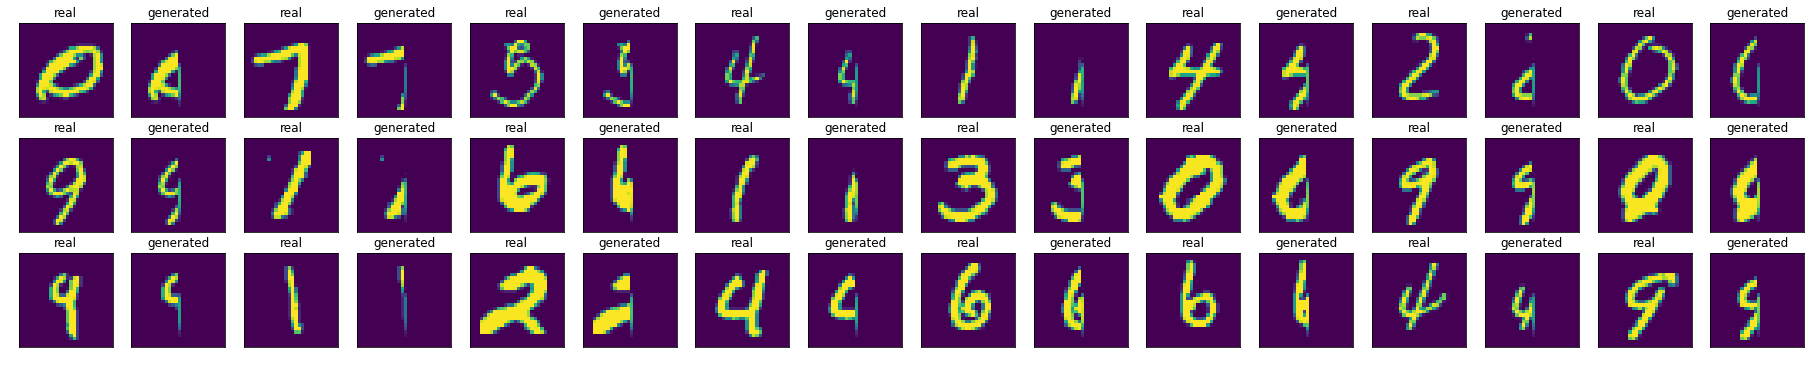

Discriminator Loss: 2.4402e+01 and generator loss is: 3.1919e+01
Epoch 133 ended in 6.11 secs.


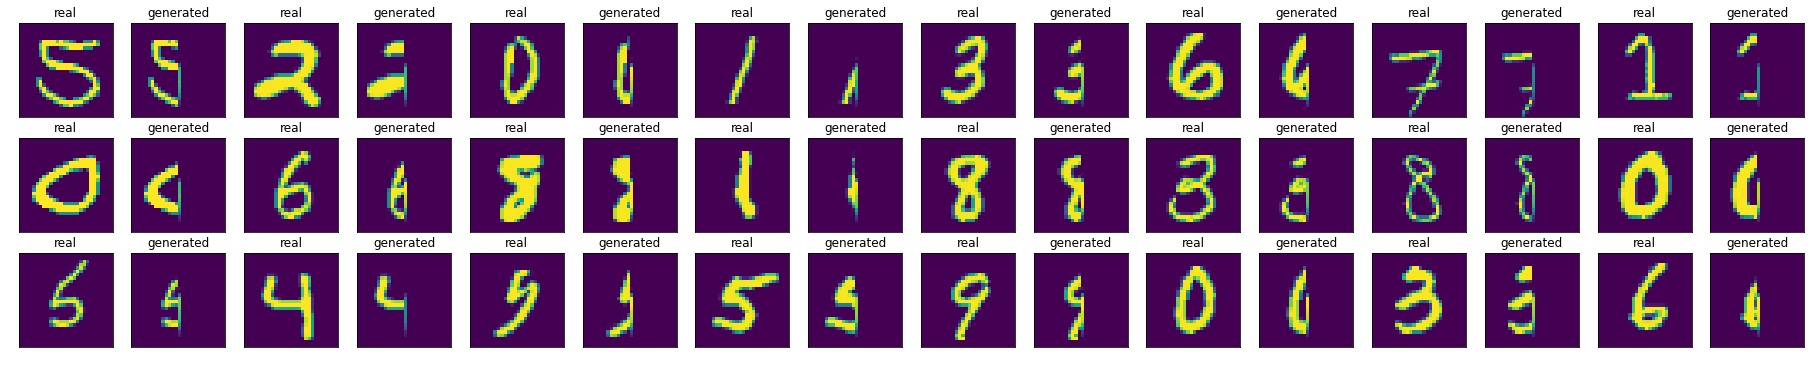

Discriminator Loss: 2.4330e+01 and generator loss is: 3.2002e+01
Epoch 134 ended in 6.10 secs.


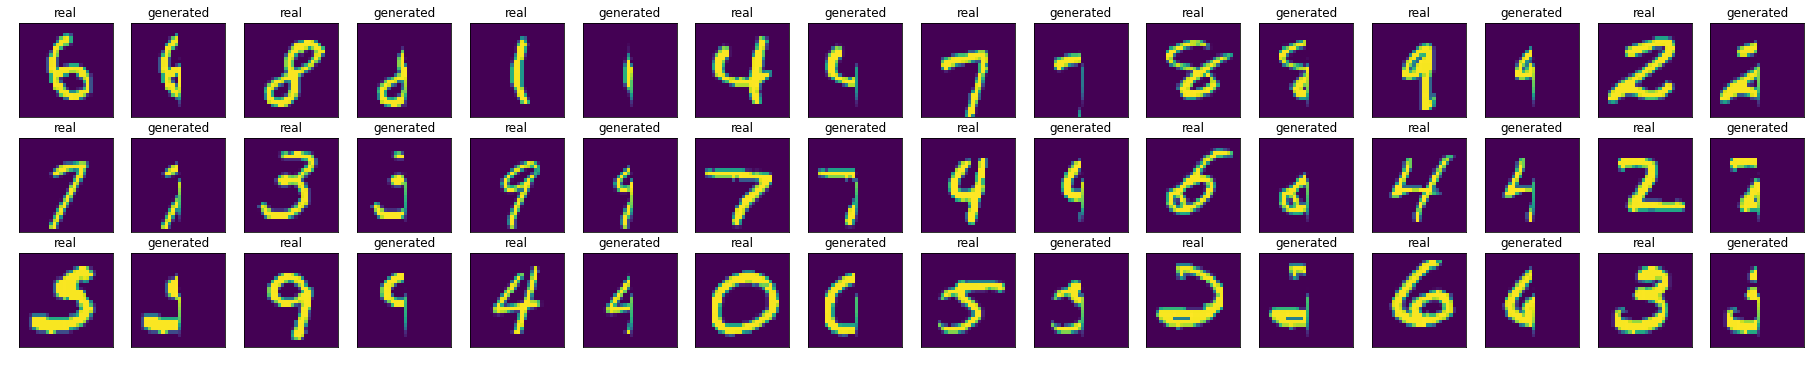

Discriminator Loss: 2.4241e+01 and generator loss is: 3.2178e+01
Epoch 135 ended in 6.10 secs.


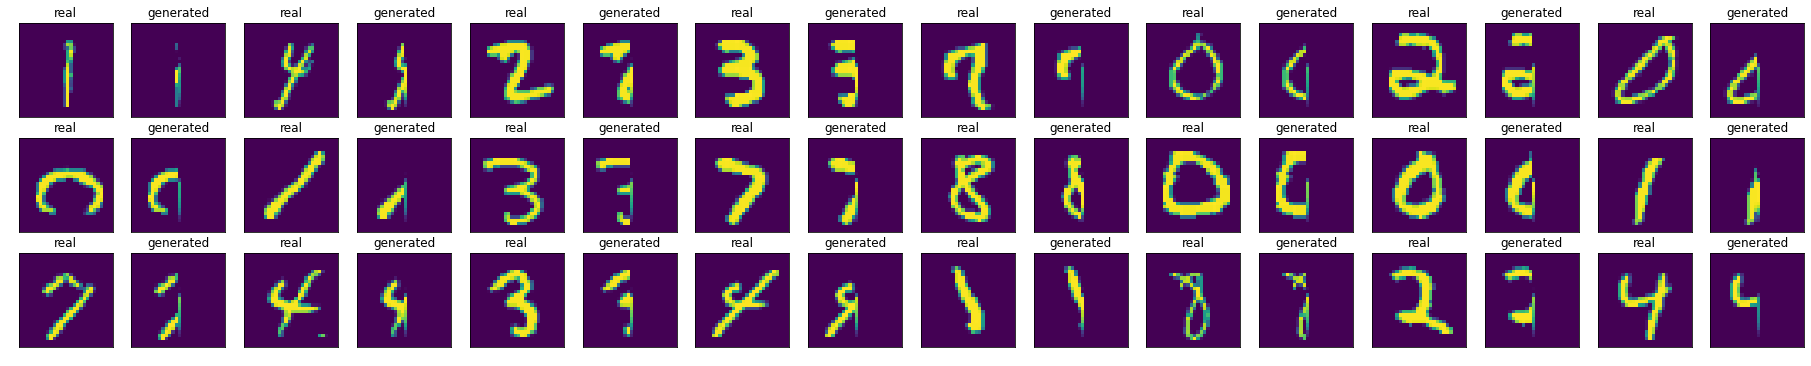

Discriminator Loss: 2.4218e+01 and generator loss is: 3.2012e+01
Epoch 136 ended in 6.10 secs.


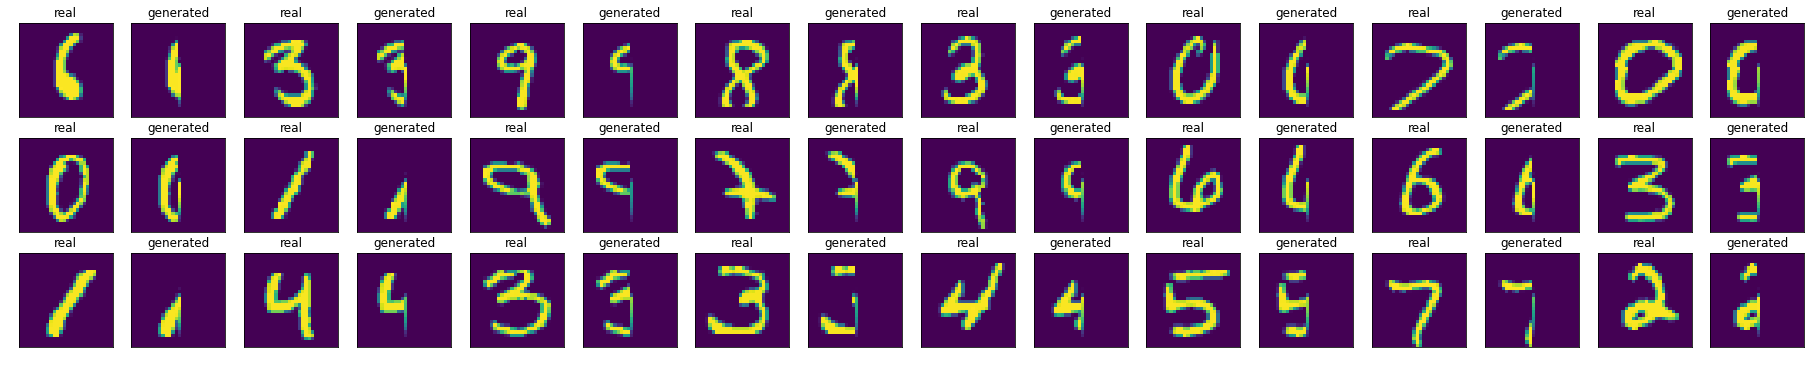

Discriminator Loss: 2.4187e+01 and generator loss is: 3.2142e+01
Epoch 137 ended in 6.09 secs.


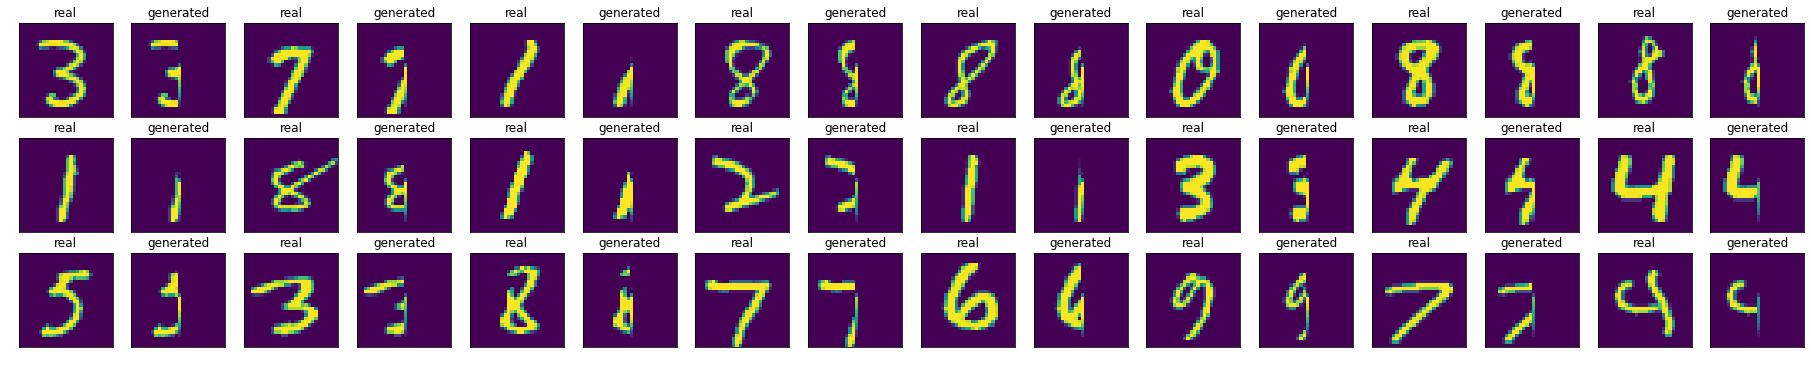

Discriminator Loss: 2.4048e+01 and generator loss is: 3.2225e+01
Epoch 138 ended in 6.11 secs.


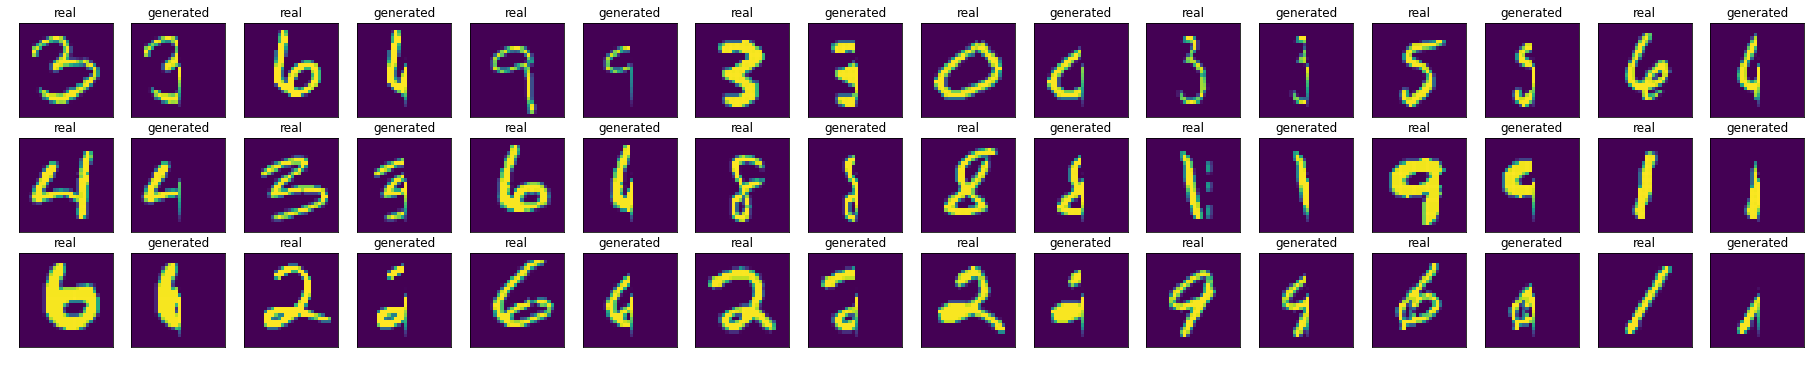

Discriminator Loss: 2.4030e+01 and generator loss is: 3.2184e+01
Epoch 139 ended in 6.10 secs.


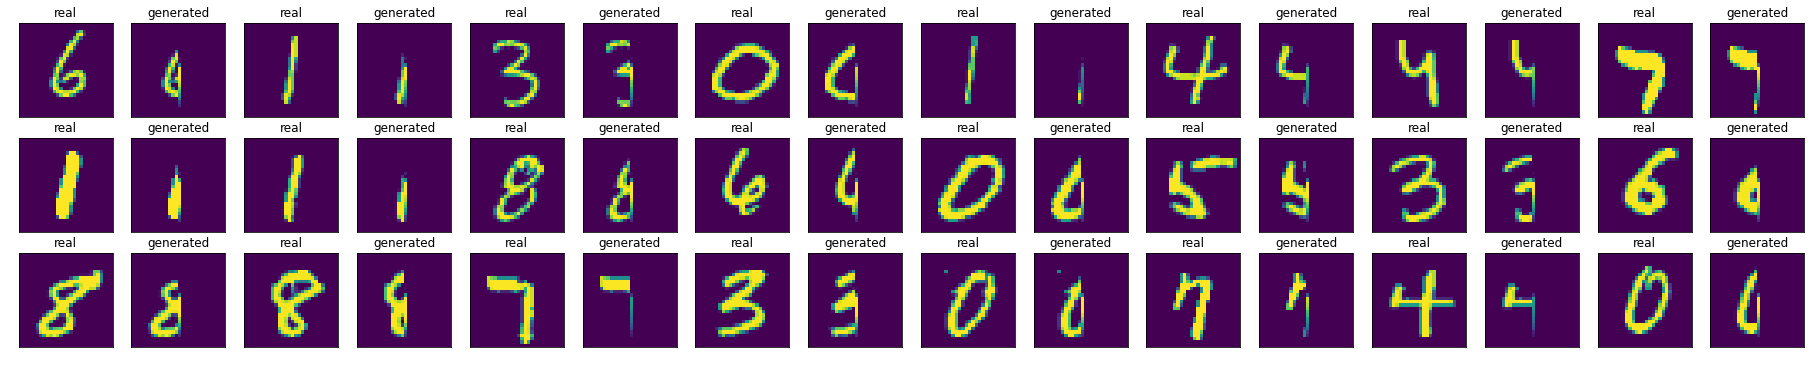

Discriminator Loss: 2.4062e+01 and generator loss is: 3.2105e+01
Epoch 140 ended in 6.11 secs.


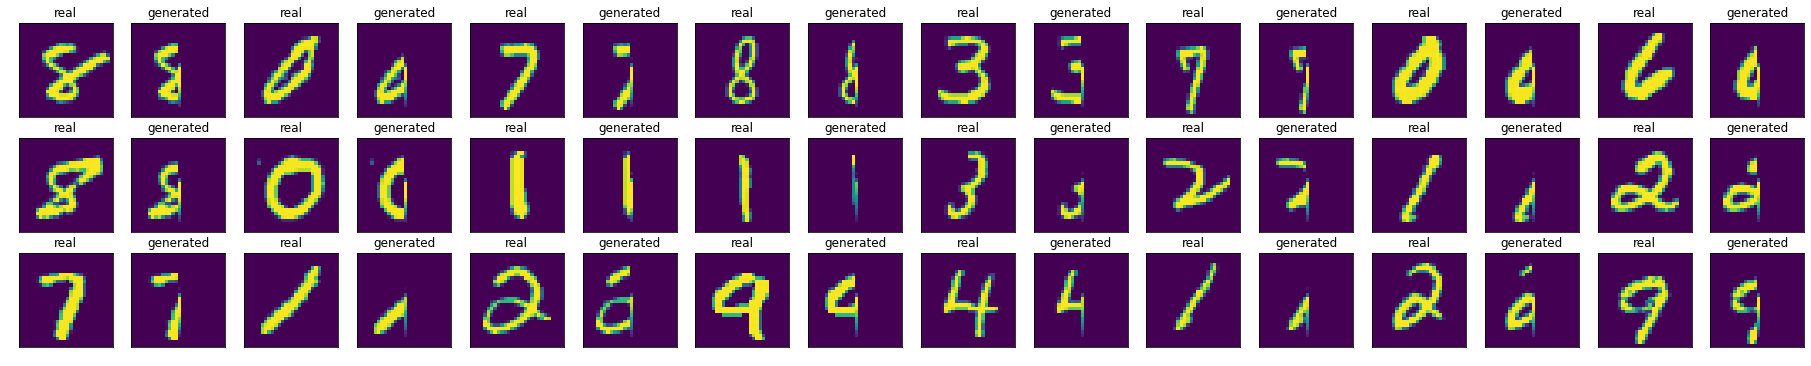

Discriminator Loss: 2.3980e+01 and generator loss is: 3.2107e+01
Epoch 141 ended in 6.10 secs.


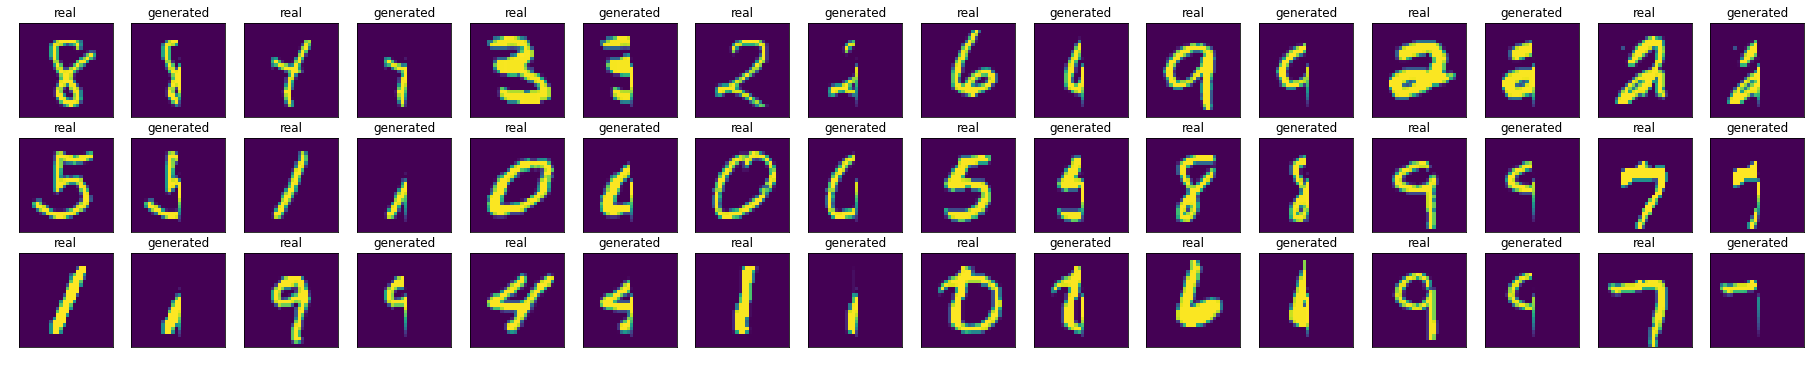

Discriminator Loss: 2.3974e+01 and generator loss is: 3.2289e+01
Epoch 142 ended in 6.10 secs.


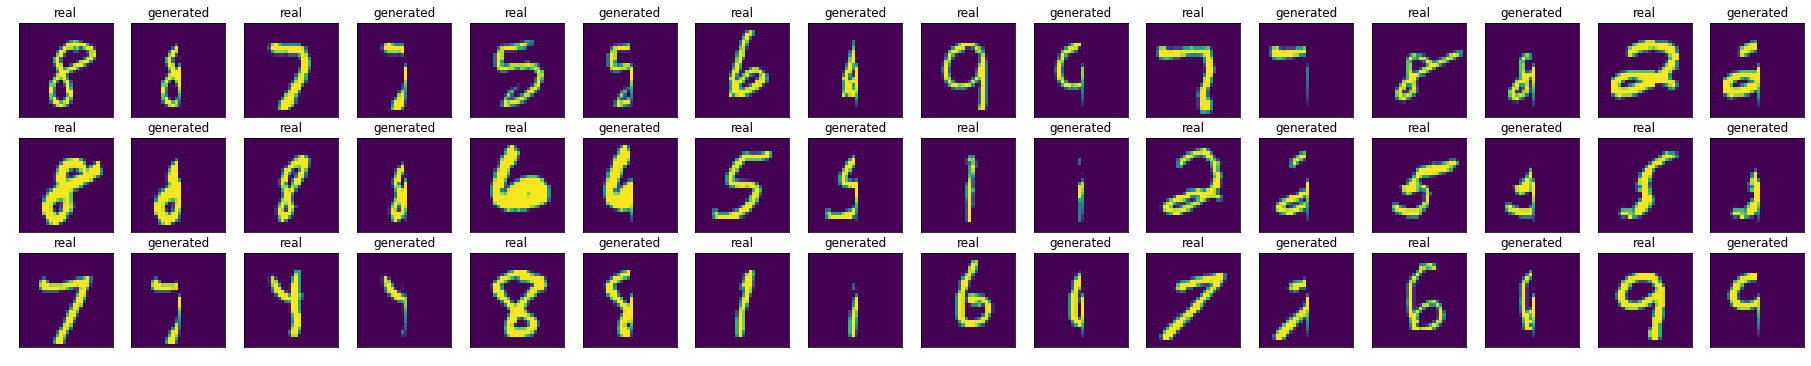

Discriminator Loss: 2.3940e+01 and generator loss is: 3.2106e+01
Epoch 143 ended in 6.10 secs.


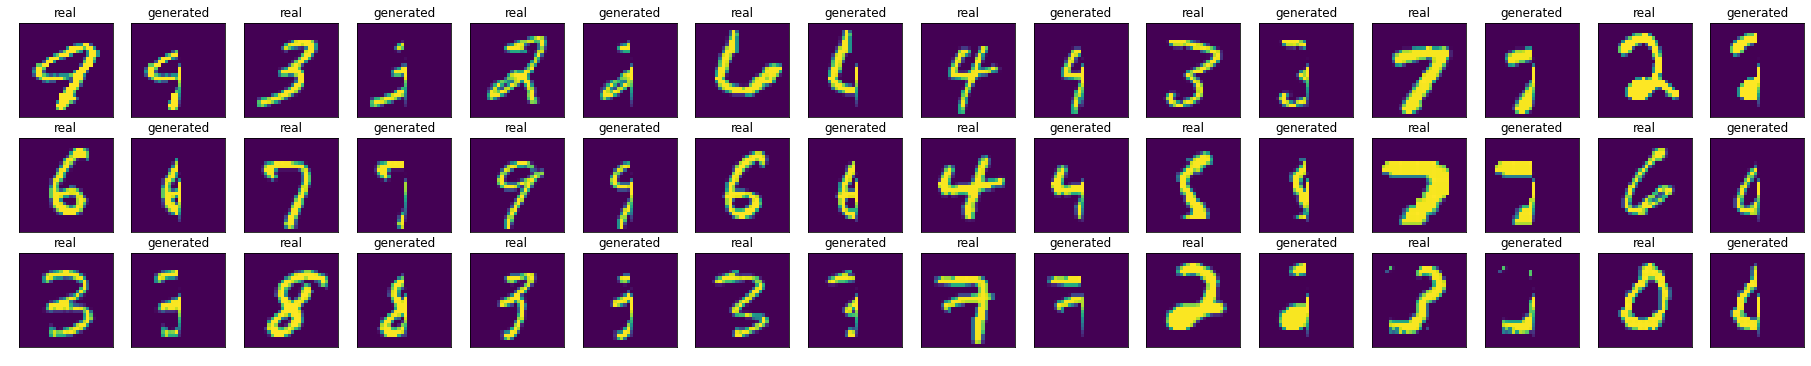

Discriminator Loss: 2.3751e+01 and generator loss is: 3.2220e+01
Epoch 144 ended in 6.11 secs.


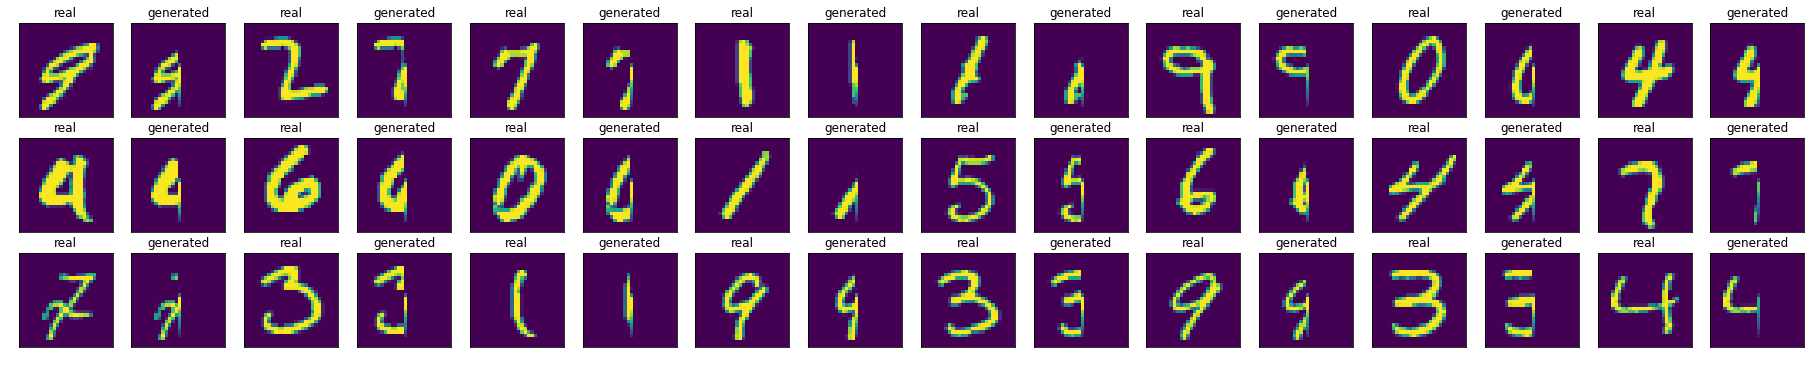

Discriminator Loss: 2.3745e+01 and generator loss is: 3.2104e+01
Epoch 145 ended in 6.11 secs.


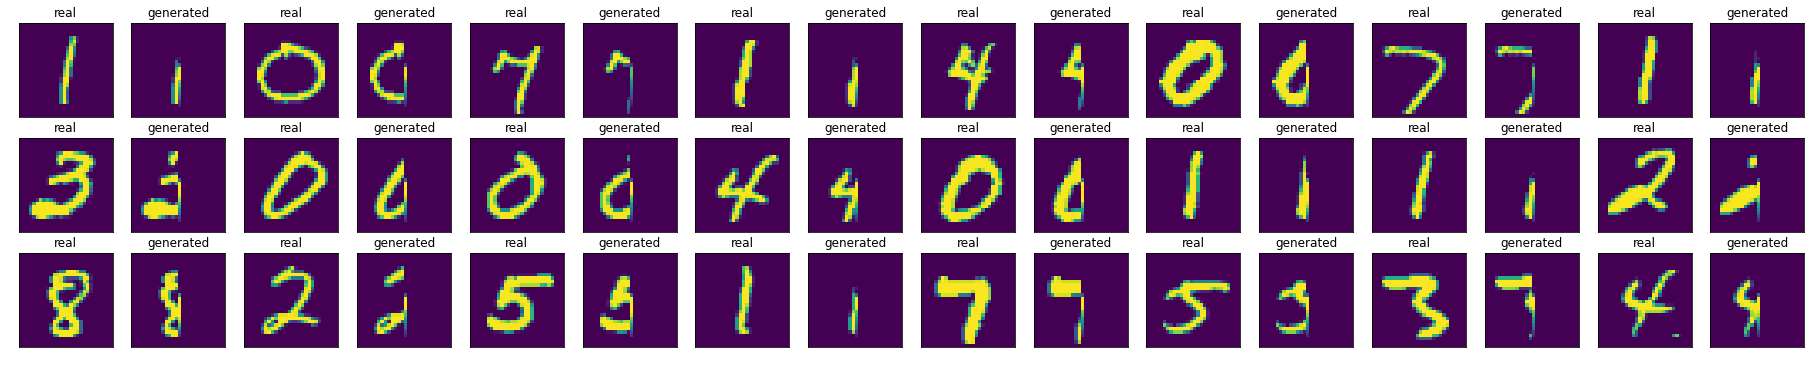

Discriminator Loss: 2.3876e+01 and generator loss is: 3.2100e+01
Epoch 146 ended in 6.11 secs.


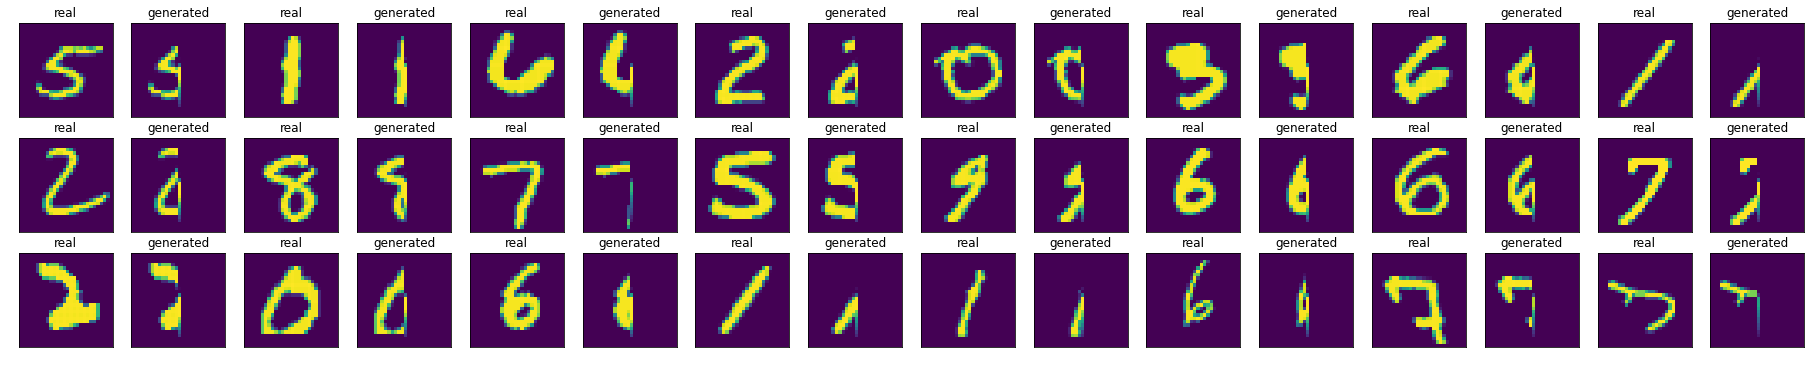

Discriminator Loss: 2.3713e+01 and generator loss is: 3.2178e+01
Epoch 147 ended in 6.11 secs.


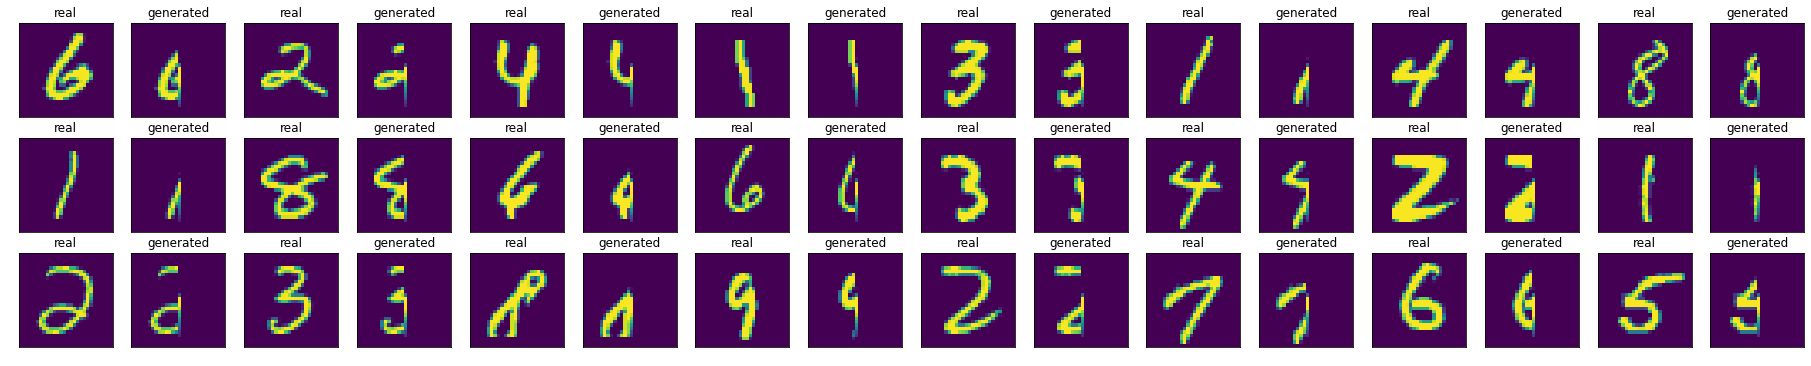

Discriminator Loss: 2.3747e+01 and generator loss is: 3.2422e+01
Epoch 148 ended in 6.11 secs.


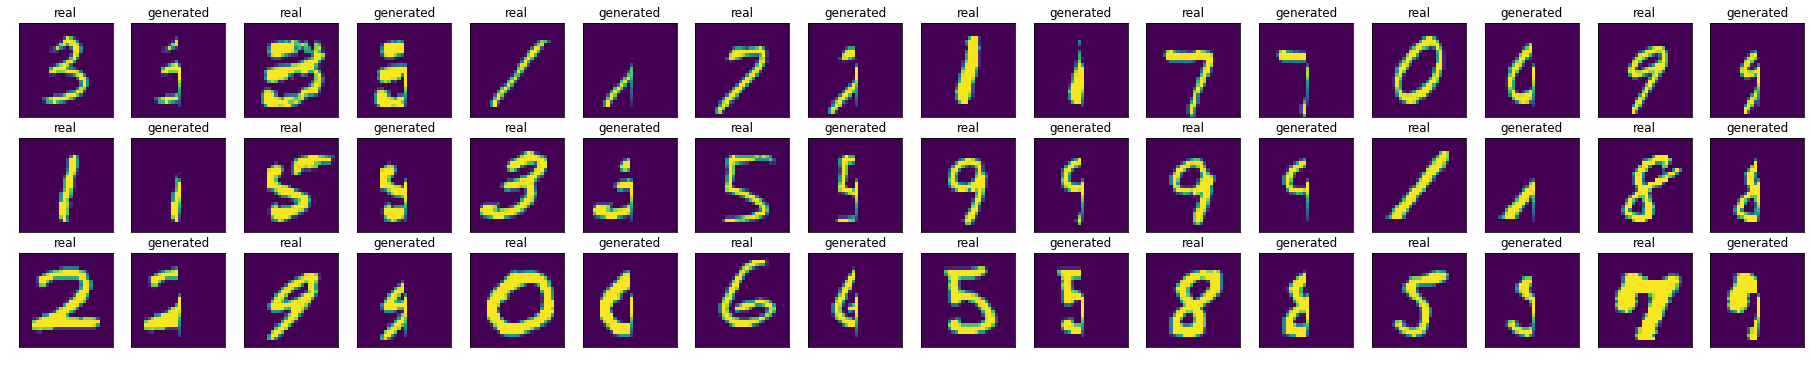

Discriminator Loss: 2.3723e+01 and generator loss is: 3.2223e+01
Epoch 149 ended in 6.10 secs.


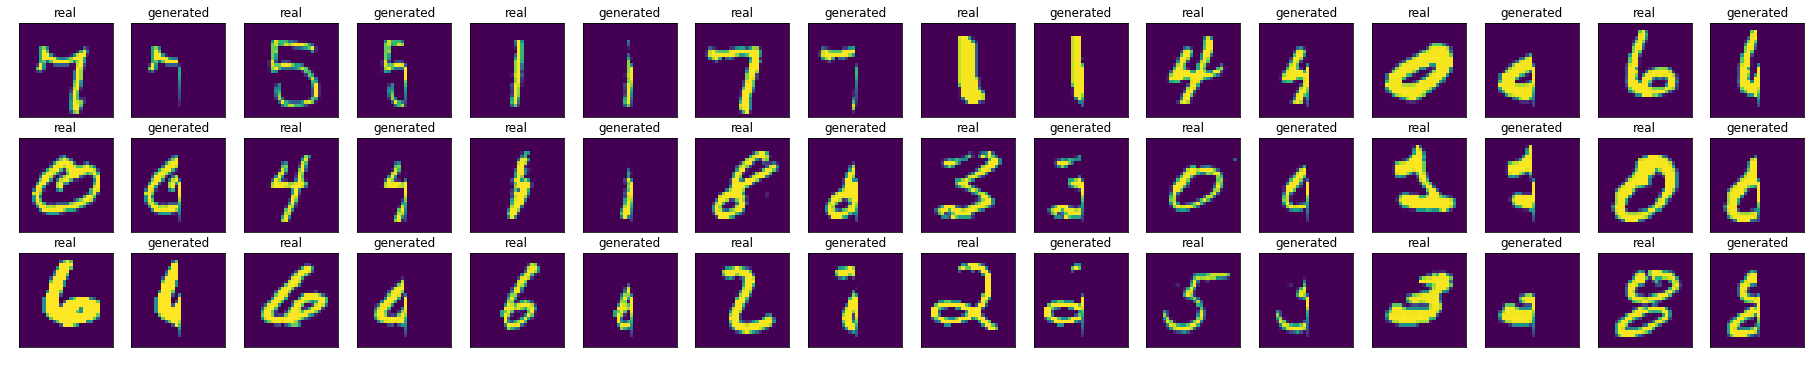

In [30]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    gen_loss = 0
    # torch.
    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]
        batch = x_train[batch_inds]


        if iter % 6 == 0:
            gen_epoch_loss = generator_trainer(generator, discriminator, batch, gen_optimizer, criterion, device)
            gen_loss += float(gen_epoch_loss)
        
        else:      
            loss = discriminator_trainer(criterion, discriminator, generator, batch, device)

            epoch_loss += float(loss)


    print(f'Discriminator Loss: {epoch_loss:.4e} and generator loss is: {gen_loss:.4e}')
    
    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))

    display(generator, x_val, 8, 3)

    torch.save({
            'epoch': e,
            'discriminator_loss': epoch_loss,
            'discriminator': discriminator,
            'generator_loss': gen_loss,
            'generator': generator,
            
        }, 'epoch_%d_state.pt' % e)